# Mixture of Gaussians Example 
We consider the following model for the data as in Minka (2001b) for Expectation Propagation:

$p(\pmb{y}|\pmb{x})=(1-w)\mathcal{N}(\pmb{y};\pmb{x}, \pmb{I})+w\mathcal{N}(\pmb{y};\pmb{0}, a\pmb{I})$

which is a specific example of the general case for the heteroscedastic finite mixture models with only Gaussian distribution:

$p(\pmb{y}|\pmb{\Xi})=\sum_i w_i \mathcal{N}(\pmb{y};\pmb{\mu}_i, \pmb{\Lambda}_i)$, where $\sum_i w_i=1$ and $w_i>0$

Justification for considering Mixture Models:
- They typically arise in practice, for instance, in Medicine
    - Hence an area where local data privacy is considered, and Federated Learning should be applied, since data might be split across clients, e.g. hospitals
- This model is fully misspecified since we fit a single normal to a mixture distribution, i.e. the $\mathcal{M}$-open world

## Imports

In [1128]:
%load_ext autoreload
%autoreload 2

import os
import sys
import logging

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from pathlib import Path

import math
from __future__ import division
import copy


import torch
import torch.utils.data
import torch.nn as nn
from torch import distributions, nn, optim
from torchvision import transforms, datasets
from scipy.stats import multivariate_normal
import scipy.stats as stats
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tqdm.auto as tqdm
import pandas as pd

#JITTER = 1e-2

%matplotlib inline
torch.set_default_dtype(torch.float64)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Helper Functions

In [560]:
def homogeneous_split(data, partitions):
    rng = np.random.default_rng()
    perm = rng.permutation(len(data))
    
    client_data = []
    for i in range(partitions):
        client_idx = perm[i::partitions]
        client_data.append(data[client_idx])
    
    return client_data

def get_batch(data, length):
    assert length > 0, "Can't use batch of size 0"
    rng = np.random.default_rng()
    perm = rng.permutation(len(data))
    idx_0 = perm[0]
    batch = torch.atleast_2d(data[idx_0])
    l = min(len(data), length)
    
    for i in range(1, l):
        client_idx = perm[i]
        samp = torch.atleast_2d(data[client_idx])
        batch = torch.cat((batch, samp), 0)
    return batch

# Will generate random sized partitions of the data, dependent on the size of the previous partitions
def heterogeneous_split(data, partitions):
    
    l = len(data)
    weights = []
    for i in range(partitions-1):
        w_i = torch.distributions.uniform.Uniform(torch.tensor([1.]), (l-partitions+i)).sample()
        w = torch.floor(w_i)
        weights.append(w.numpy())
        l -= w
    weights.append(l.numpy())
    
    client_data = []
    counter = 0
    for w in weights:
        client_x_n = data[counter:int(counter+w[0])]
        client_data.append(client_x_n)
        counter += w[0]
        counter = int(counter)
        
    return client_data
    
def plot_training(training_array):
    x_vals = np.arange(1, len(training_array)+1)
    plt.figure()
    plt.grid(visible=True)
    plt.plot(x_vals, training_array)
    plt.ylabel('ELBO Loss')
    plt.xlabel('Step')
    plt.show()

In [3]:
# Miscellaneous colour map definitions for visualising different contour plots at the same time

cmap1 = ['lightsalmon', 'navy', 'darkorchid', 'mediumvioletred', 'crimson', 'tomato']
cmap2 = ['teal', 'forestgreen', 'limegreen', 'mediumspringgreen', 'aquamarine', 'mediumturquoise']
cmap3 = ['palevioletred', 'navy', 'darkorchid', 'mediumvioletred', 'crimson', 'tomato', 'lightsalmon']


## Definition of function of mixture of two 2D normals
We assume that the covariance matrix is some coefficient times the identity matrix:

$\mathcal{N}(\pmb{y};\pmb{x}, c\pmb{I})=\frac{1}{2\pi |c\pmb{I}|^{1/2}}\exp \{-\frac{1}{2}(\pmb{y}-\pmb{x})^T(c\pmb{I})^{-1}(\pmb{y}-\pmb{x})\}=\frac{1}{2c\pi} \exp \{-\frac{1}{2c}(\pmb{y}-\pmb{x})^T(\pmb{y}-\pmb{x})\}, \; c\in \mathbb{R}, \pmb{x},\pmb{y}\in \mathbb{R}^2, \pmb{I}\in\mathbb{R}^{2\times2}$

$=\frac{1}{2c\pi}\exp \{-\frac{1}{2c}((y_1-x_1)^2+(y_2-x_2)^2)\}$

In [4]:
def Normal(mean, cov_coef, x, D):
    assert D > 0, "negative dimensional data"
    if D > 2:
        s = np.dot((x-mean),(x-mean))
    elif D == 2:
        if torch.is_tensor(x):
            x = x.squeeze(0).numpy()
        s = (x[0] - mean[0]) ** 2 + (x[1] - mean[1]) ** 2
    else:
        s = (x-mean) ** 2
    return np.exp(-(s/(2 * cov_coef))) / ((np.absolute(2 * cov_coef * np.pi)) ** (D/2))

In [424]:
class Gaussian:
    #Change to log sum exp instead of explicitly evaluating this
    
    def Gaussian(mean, cov, theta):
        assert cov.shape[0] > 0, "Dimensionality specified incorrectly"
        if cov.shape[0] == 1:
            return torch.exp(-(((theta - mean) ** 2)/(2 * cov))) / ((torch.abs(2 * cov * np.pi)) ** 0.5)
        else:
            assert mean.shape[0] == cov.shape[1], "Not the same dimension, multiplication not possible"

            vector = theta-mean
            vector.unsqueeze(-1)

            # (\theta - mean)^T \Sigma ^ {-1} (\theta - mean)        
            part = torch.matmul(vector.unsqueeze(0), torch.linalg.solve(cov, vector.unsqueeze(-1)))

            det = torch.linalg.det(cov) ** 0.5

            coef_ = det * ((np.pi * 2) ** (cov.shape[0] / 2))
            
            coef = coef_ ** -1

            return (coef * torch.exp(- part / 2)).squeeze()
        
    def SphericalGaussian(mean, cov, theta, D):
        assert D > 0, "Negative dimension in spherical Gaussian"
        if D == 1:
            return torch.exp(-(((theta - mean) ** 2)/(2 * cov))) / ((torch.abs(2 * cov * np.pi)) ** 0.5)
        else:
            vector = theta-mean
            vector.unsqueeze(-1)

            # (\theta - mean)^T \Sigma ^ {-1} (\theta - mean)        
            part = torch.matmul(vector.unsqueeze(0), vector.unsqueeze(-1)) / cov

            coef_ = torch.pow(torch.abs(cov * np.pi * 2), (D / 2))

            coef = coef_ ** -1

            return (coef * torch.exp(- part / 2)).squeeze()
            
    def GaussianMixture(mean_list, cov_list, theta, parameters, D=None):
        ret = 0.
        assert len(mean_list) == len(parameters), "Different list lengths"
        assert len(mean_list) == len(cov_list), "Different list lengths"
        
        param = 0.
        for w in parameters:
            param += w
            
        if param != 1:
            for k in range(len(parameters)):
                w = parameters[k]
                parameters[k] = w / param
        if D is None:      
            for i in range(len(parameters)):
                ret += parameters[i] * Gaussian.Gaussian(mean_list[i], cov_list[i], theta)
        else:
            for i in range(len(parameters)):
                ret += parameters[i] * Gaussian.SphericalGaussian(mean_list[i], cov_list[i], theta, D)
            
        return ret
    
    def SampleFromMixture(mean_list, cov_list, parameters, num_samples):
        
        param = 0.
        for w in parameters:
            param += w
            
        if param != 1:
            for k in range(len(parameters)):
                w = parameters[k]
                parameters[k] = w / param
        
        sample_nums = torch.distributions.multinomial.Multinomial(num_samples, 
                                                                           parameters).sample()
        component_sample_num = sample_nums.numpy()
        samples = torch.tensor([])
        
        for i in range(len(parameters)):
            if cov_list[i].shape[0] > 1:    
                m_i = torch.distributions.multivariate_normal.MultivariateNormal(mean_list[i],
                                                                                 covariance_matrix=cov_list[i])
            else:
                m_i = torch.distributions.normal.Normal(mean_list[i],cov_list[i])
            
            sample = m_i.sample((int(component_sample_num[i]),))
            samples = torch.cat((samples, sample), 0)
                
        return samples
    
    def HeterogenousSampleMix(mean_list, cov_list, parameters, num_samples):
        
        param = 0.
        for w in parameters:
            param += w
            
        if param != 1:
            for k in range(len(parameters)):
                w = parameters[k]
                parameters[k] = w / param
        
        sample_nums = torch.distributions.multinomial.Multinomial(num_samples, 
                                                                           parameters).sample()
        component_sample_num = sample_nums.numpy()
        
        client_data =[]
        for i in range(len(parameters)):
            if cov_list[i].shape[0] > 1:    
                m_i = torch.distributions.multivariate_normal.MultivariateNormal(mean_list[i],
                                                                                 covariance_matrix=cov_list[i])
            else:
                m_i = torch.distributions.normal.Normal(mean_list[i],cov_list[i])
            
            sample = m_i.sample((int(component_sample_num[i]),))
            client_data.append(sample)
                
        return client_data
        

### Applying the mixture of Normals

In [6]:
def Mixture(x, w, mean_1, cov_coef_1, mean_2, cov_coef_2, D):
    return (1 - w) * Normal(mean_1, cov_coef_1, x, D) + w * Normal(mean_2, cov_coef_2, x, D)

### One Dimensional Case of probability distributions

In [7]:
def Normal1d(mean, var, x):
    return np.exp(-((x-mean) ** 2)/(2 * var))/ ((np.absolute(2 * var * np.pi)) ** 0.5)

def Mix(x, w, m_1, var_1, m_2, var_2):
    return (1-w)* Normal1d(m_1, var_1, x) + w * Normal1d(m_2, var_2, x)

## Generate Data from Multivariate Normal distribution
For this experiment we set $\pmb{x}=[2.,2.]^T$ and $w = 0.4$


#### Numpy implementation

In [8]:
mean_ = [2.,2.]
cov_ = [[1.,0.],[0.,1.]]
mean_2 = [0.,0.]
cov_2 = [[10.,0.],[0.,10.]]
w = 0.5

l = np.random.default_rng().binomial(size=20, n=1, p=w)
x_ = []
y_ = []
for i in l:
    if i == 0:
        x, y = np.random.default_rng().multivariate_normal(mean_, cov_, 1).T 
    else:
        x, y = np.random.default_rng().multivariate_normal(mean_2, cov_2, 1).T

    x_.append(x[0])
    y_.append(y[0])
    
#x_1, y_1 = np.random.default_rng(seed=42).multivariate_normal(mean_, cov_, 100).T
#x_2, y_2 = np.random.default_rng(seed=42).multivariate_normal(mean_2, cov_2, 100).T

#x_ = (w_ * x_1) + (w * x_2)
#y_ = (w_ * y_1) + (w * y_2)
#x_ = x_1.tolist() + x_2.tolist()
#y_ = y_1.tolist() + y_2.tolist()


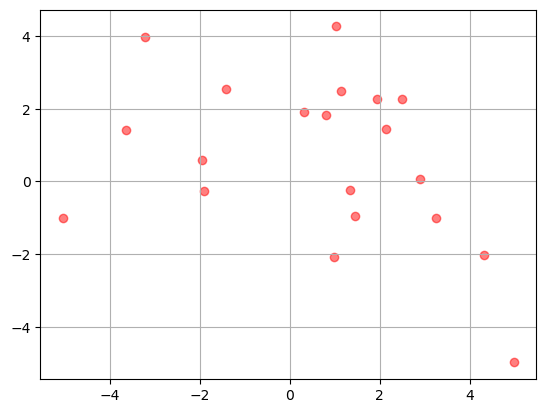

In [9]:
plt.scatter(x_, y_, c="r", alpha =.5)
plt.grid(visible=True)

#### One Dimensional Normal distribution

In [10]:
mean_1d = 3.
var_1d = 1.
mean2_1d = -1.
var2_1d = 2.

w = 0.5
l = np.random.default_rng(seed=42).binomial(size=20, n=1, p=w)
x_1d = []
y_1d = []
for i in l:
    if i == 0:
        x = np.random.default_rng().normal(mean_1d, var_1d, 1).T 
    else:
        x = np.random.default_rng().normal(mean2_1d, var2_1d, 1).T

    x_1d.append(x[0])

### Histogram of data density

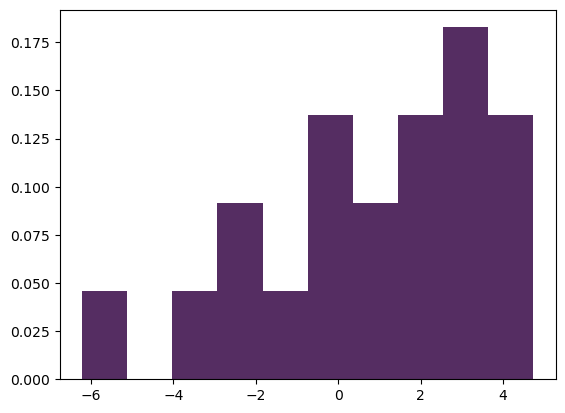

In [11]:
plt.hist(x_1d, bins=10, density=True, color='#552D62')
plt.grid(visible=False)

### Data density against joint distribution

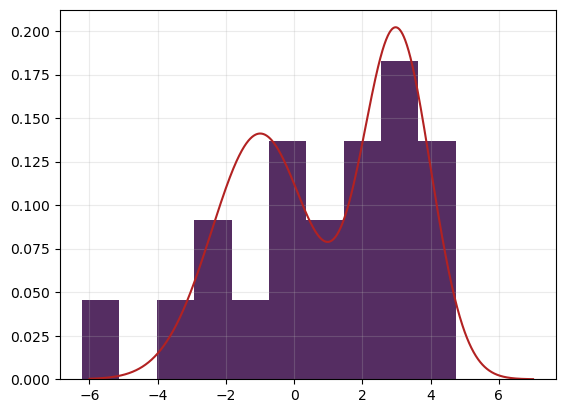

In [12]:
x = np.linspace(-6, 7, 1000)

plt.plot(x, Mix(x, w, mean_1d, var_1d, mean2_1d, var2_1d), color='firebrick')
plt.hist(x_1d, density=True, bins=10, color='#552D62')
plt.grid(visible=True, alpha=.25)

## Calling the mixture of Normals for plotting

In [13]:
x = np.linspace(-7, 7, 100)
y = np.linspace(-7, 7, 100)
X, Y = np.meshgrid(x, y)

### Individual Components

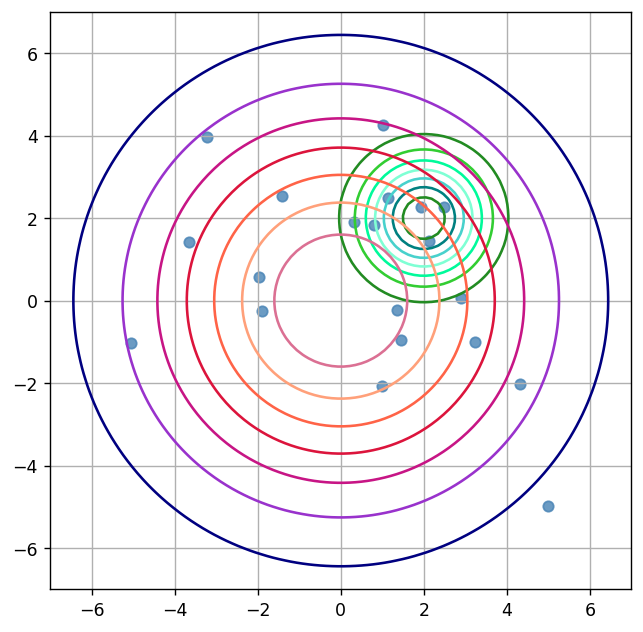

In [14]:
Z_1 = Normal(np.array([2.,2.]), 1, [X,Y], 2)
Z_2 = Normal(np.array([0.,0.]), 10, [X, Y], 2)

plt.figure(figsize=(6,6), dpi=125)
plt.contour(X,Y,Z_1, colors=cmap2)
plt.contour(X,Y,Z_2, colors=cmap3)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
plt.scatter(x_, y_, c="steelblue", alpha = .8)
plt.grid(visible=True)

### Joint Distribution

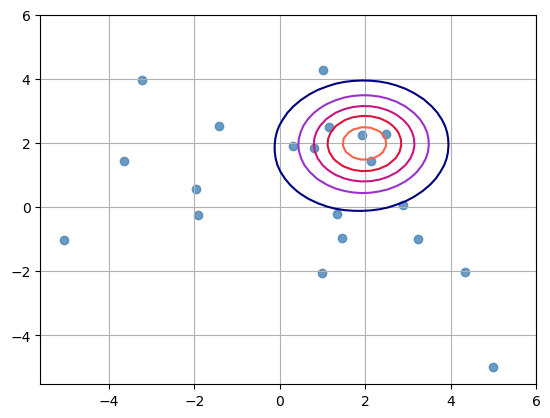

In [15]:
x = y = np.linspace(-4,6)
X_, Y_ = np.meshgrid(x, y)

Z_ = Mixture([X_, Y_], 0.5, [2.,2.], 1., [0.,0.], 10., 2)

plt.contour(X_,Y_,Z_, colors=cmap1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
plt.scatter(x_, y_, c="steelblue", alpha=.8)
plt.grid(visible=True)

## Expectation Propagation Approach for the Clutter Problem as stated in Minka (2001b)

We follow the steps, originally shown in Minka (2001b), from Chapter 10.7 in Bishop (2006).

The problem is formulated as follows:

The true likelihood and assumed prior are given below:

$p(\pmb{x}|\pmb{\theta})=(1-w)\mathcal{N}(\pmb{x}|\pmb{\theta}, \pmb{I}_d)+w\mathcal{N}(\pmb{x}|\pmb{0}, a\pmb{I}_d) \\
p(\pmb{\theta})=\mathcal{N}(\pmb{\theta}|\pmb{0}, b\pmb{I}_d)$

Over N observation we get the joint distribution of data $\mathcal{D}= \{\pmb{x}_1,...,\pmb{x}_N\}$:

$p(\mathcal{D},\pmb{\theta})=p(\pmb{\theta})\prod_{n=1}^Np(\pmb{x}_n|\pmb{\theta})\,, \; \mathrm{where}\; p(\pmb{x}_n|\pmb{\theta})=(1-w)\mathcal{N}(\pmb{x}_n|\pmb{\theta}, \pmb{I}_d)+w\mathcal{N}(\pmb{x}_n|\pmb{0}, a\pmb{I}_d)$

We select approximation 

$q(\pmb{\theta}):=\mathcal{N}(\pmb{\theta}|\pmb{m}, v\pmb{I}_d)$,

with approximating factors --- not true distributions --- $t_n(\pmb{\theta})$:

$t_n(\pmb{\theta}):=s_n \exp \{-\frac{1}{2v_n}(\pmb{\theta}-\pmb{m}_n)^T(\pmb{\theta}-\pmb{m}_n)\},\; n\in [N],\; t_0(\pmb{\theta})=p(\pmb{\theta})$

Such that we have:

$q(\pmb{\theta})=\prod_{n=0}^Nt_n(\pmb{\theta})$

The EP algorithm, stated in Algorithm ... in the paper reduces to the following:

We initialize $q(\pmb{\theta})=p(\pmb{\theta})$ by setting $t_i(\pmb{\theta})=1, \; \forall i\in 1,...,N$

We initialize this through setting $s_n=(2\pi v_n)^{D/2}$ where we are setting $v_n=\infty\implies v_n^{-1}=0$, and $\pmb{m}_n=\pmb{0}$. Each client has one datapoint in this experiment, we have 100 datapoints therefore 100 clients. 

### Step 1:
The algorithm reduces to be finding the cavity distribution $q^{\backslash n}(\pmb{\theta})$ through finding the mean and variance:

$\pmb{m}^{\backslash n} = \pmb{m} + v^{\backslash n}v_n^{-1}(\pmb{m}-\pmb{m}_n) \\
(v^{\backslash n})^{-1}=v^{-1} - v_n^{-1} \\
Z_n = (1-w) \mathcal{N}(\pmb{x}_n|\pmb{m}^{\backslash n}, (v^{\backslash n} +1)\pmb{I}_d) + w\mathcal{N}(\pmb{x}_n|\pmb{0}, a\pmb{I}_d)
$

### Step 2:
We find the new approximate posterior $q^{\mathrm{new}}(\pmb{\theta})$ by computing the new mean and variance parameters through the following equations:

$\pmb{m}^{\mathrm{new}}=\pmb{m}^{\backslash n}+\rho_n\frac{v^{\backslash n}}{v^{\backslash n}+1}(\pmb{x}_n-\pmb{m}^{\backslash n}) \\
v^{\mathrm{new}}=v^{\backslash n}-\rho_n\frac{(v^{\backslash n})^2}{v^{\backslash n}+1}+\rho_n(1-\rho_n) \frac{(v^{\backslash n})^2||\pmb{x}_n-\pmb{m}^{\backslash n}||^2}{D(v^{\backslash n}+1)^2}
$

where $\rho_n$ is given by:
$\rho_n:=1-\frac{w}{Z_n}\mathcal{N}(\pmb{x}_n|\pmb{0},a\pmb{I}_d)
$

### Step 3:
We can then compute the new factor $t_n^{\mathrm{new}}(\pmb{\theta})$ as:

$v_n^{-1}=(v^{\mathrm{new}})^{-1}-(v^{\backslash n})^{-1}\\
\pmb{m}_n=\pmb{m}^{\backslash n}+(v_n+v^{\backslash n})(v^{\backslash n})^{-1}(\pmb{m}^{\mathrm{new}}-\pmb{m}^{\backslash n}) \\
s_n = Z_n\,/\,{(2\pi v_n)^{D/2}}\mathcal{N}(\pmb{m}_n|\pmb{m}^{\backslash n}, (v_n+v^{\backslash n})\pmb{I}_d)
$

### EP Implementation

In [16]:
def norm_2(vector):
    s = 0.
    for p in vector:
        s += p ** 2
        
    return s

In [17]:
def trueDistribution2D(parameters, clients, min_1, max_1, min_2=None, max_2=None, plot=False):
    if min_2 == None:   
        x = y = np.linspace(min_1,max_1)
    else:
        x = np.linspace(min_1,max_1)
        y = np.linspace(min_2,max_2)
    X, Y = np.meshgrid(x, y)
    theta = [X, Y]
    
    prior = Normal(np.zeros(2), parameters["b"], theta, 2)
    distribution = prior
    
    for client in clients:
        mix = Mixture(client["x_n"], parameters["w"], theta, 1, np.zeros(2), 10, 2)
        
        temp = distribution * mix
        
        distribution = temp
        
    if plot:
        plt.figure(figsize=(6,6), dpi=100)
        plt.contour(X,Y,distribution, colors=cmap2)
        plt.grid(visible=True)

    return distribution
    

In [18]:
def trueDistribution1D(parameters, clients, min_, max_):
    x = np.linspace(min_,max_, 1000)
    theta = x
    
    prior = Normal(0., parameters["b"], theta, 1)
    distribution = prior
    
    for client in clients:
        
        mix = Mixture(client["x_n"], parameters["w"], theta, 1, 0., parameters["a"], 1)
        
        temp = distribution * mix
        
        distribution = temp
    
    plt.plot(x,distribution, color="firebrick")
    plt.grid(visible=True)
    
    return distribution

In [19]:
#Not yet implemented
def minibatchEP(client, batchsize, q_global, parameters):
    assert batchsize > 0, "Negative batch size"
    
    size = len(client["x_n"])
    if batchsize >= size:
        batchsize = size
    
    rng = np.random.default_rng()
    
    l = rng.choice(size, batchsize, replace=False)
    
    
    for e in l:
        client_data = client["x_n"][e]
        singleStepEP(client, q_global, parameters, client_data)
               
        

In [20]:
#Model evidence calculation approximation:
def evidence(q_global, clients, parameters):
    B = (((q_global["mean"][0] ** 2) + (q_global["mean"][1] ** 2)) / q_global["variance"])
    prod = 1.
    for i in range(parameters["N"]):
        t = ((clients[i]["mean"][0] ** 2) + (clients[i]["mean"][1] ** 2)) * clients[i]["variance_inverse"]
        B -= t
        
        #Include infinite variance
        if clients[i]["variance_inverse"] == 0:
            continue
        temp = clients[i]["normaliser"] / (2 * clients[i]["variance"] * np.pi)
        temp_prod = temp * prod
        prod = temp_prod
    
    ret = (2 * q_global["variance"] * np.pi) * np.exp(B/2) * prod
    
    #print("===========================================")
    #print("p(D): ", ret)
    return ret

In [21]:
#Model evidence calculation approximation:
def evidence1D(q_global, clients, parameters):
    B = ((q_global["mean"] ** 2) / q_global["variance"])
    prod = 1.
    for i in range(parameters["N"]):
        t = (clients[i]["mean"] ** 2) * clients[i]["variance_inverse"]
        B -= t
        
        #Include infinite variance
        if clients[i]["variance_inverse"] == 0:
            continue
        temp = clients[i]["normaliser"] / (2 * clients[i]["variance"] * np.pi)
        temp_prod = temp * prod
        prod = temp_prod
    
    ret = (2 * q_global["variance"] * np.pi) * np.exp(B/2) * prod
    
    return ret

In [22]:
def ExpectationPropagation(clients, q_global, parameters):
    
    #Setting the Default to be Minka's default setting in Minka (2001b)
    if parameters["w"] is not None:
        w = parameters["w"]
    else:
        print("Warning! No 'w' specified. Might not match data generating mechanism.")
        w = 0.5
        
    if parameters["a"] is not None:
        a = parameters["a"]
    else: 
        print("Warning! No 'a' specified. Might not match data generating mechanism.")       
        a = 10
        
    if parameters["b"] is not None:
        b = parameters["b"]
    else:
        b = 100
    
    if parameters["D"] is not None:
        D = parameters["D"]
    else:
        D = len(q_global["mean"])
    
    if parameters["N"] is not None:
        N = parameters["N"]
    else:
        N = len(clients)
    
    if parameters["Epochs"] is not None:
        Epochs = parameters["Epochs"]
    else:
        Epochs = 50
    
    for i in range(Epochs):
        print("===========================================")
        print(f"Iteration {i+1}:")
        for n in range(N):
            ###############################################
            # Step 1:
            ###############################################
            #print(f"STEP {n}:")
            
            v_bar_n_inverse = q_global["variance"] ** (-1) - clients[n]["variance_inverse"]
            v_bar_n = v_bar_n_inverse ** (-1)
            
            part = (v_bar_n) * clients[n]["variance_inverse"] * (q_global["mean"] - clients[n]["mean"])
            
            m_bar_n = q_global["mean"] + part

            Z_n = Mixture(clients[n]["x_n"], w, m_bar_n, (v_bar_n + 1), np.zeros(D), a, D)

            ###############################################
            #Step 2:
            ###############################################

            rho_n = 1 - (w/Z_n) * Normal(np.zeros(D), a, clients[n]["x_n"], D)

            m_new = m_bar_n + rho_n * v_bar_n * (clients[n]["x_n"] - m_bar_n) / (v_bar_n + 1)

            term_1 = rho_n * (v_bar_n ** 2) / (v_bar_n + 1)
            
            norm = (np.linalg.norm(clients[n]["x_n"] - m_bar_n) ** 2)
            term_2 = rho_n * (1 - rho_n) * (v_bar_n ** 2) * norm
            term_3 = D * ((v_bar_n + 1) ** 2)
            
            v_new = v_bar_n - term_1 + (term_2 / term_3)

            ###############################################
            #Step 3:
            ###############################################

            v_n_inverse = (v_new ** (-1)) - v_bar_n_inverse
            
            if v_n_inverse == 0.0:
                v_n = np.inf
            else:
                v_n = v_n_inverse ** (-1)
            
            # using the convention that 0 * np.inf = 0
            if rho_n == 0.0:    
                m_n = m_bar_n
            else:
                m_n = m_bar_n + (v_n + v_bar_n) * v_bar_n_inverse * (m_new - m_bar_n)

            if v_n == np.inf:
                s_n = Z_n
            else:
                s_n = Z_n / (((np.absolute(2 * v_n * np.pi)) ** (D / 2)) * Normal(m_bar_n, (v_n + v_bar_n), m_n, D))

            ###############################################
            # Updating Results for client and global approximation:
            ###############################################

            q_global["mean"] = m_new
            q_global["variance"] = v_new

            clients[n]["mean"] = m_n
            clients[n]["variance"] = v_n
            clients[n]["variance_inverse"] = v_n_inverse
            clients[n]["normaliser"] = s_n
            clients[n]["iteration"] = i + 1

        print("New global q: ", q_global)
    return q_global, clients

### Two Dimensional Example
#### Initializing each client

In [23]:
#Parameters Definitions:
parameters_ep = {
    "w": 0.5,
    "a": 10,
    "b": 100,
    "D": 2,
    "N": 20,
    "Epochs": 10
}

q_global_ep = {
    "mean": np.array([0.,0.]),
    "variance": parameters_ep["b"]
}

clients_ep = []

for i in range(len(x_)):
    clients_ep.append({
        "client_idx": i,
        "x_n": np.array([x_[i], y_[i]]),
        "mean": np.array([0.,0.]),
        "variance": np.inf,
        "variance_inverse": 0.,
        "normaliser": 1.,
        "iteration": 0
    })


In [24]:
q_new_ep, clients_new_ep = ExpectationPropagation(clients_ep, q_global_ep, parameters_ep)
evidence(q_new_ep, clients_new_ep, parameters_ep)

Iteration 1:
New global q:  {'mean': array([1.12017219, 0.43619706]), 'variance': 1.0983741432058594}
Iteration 2:
New global q:  {'mean': array([1.49131258, 1.64571911]), 'variance': 0.3614517230115771}
Iteration 3:
New global q:  {'mean': array([1.48522912, 1.66024369]), 'variance': 0.33522263032001676}
Iteration 4:
New global q:  {'mean': array([1.48239846, 1.63303007]), 'variance': 0.360527707697433}
Iteration 5:
New global q:  {'mean': array([1.48460829, 1.63397252]), 'variance': 0.3630831733632593}
Iteration 6:
New global q:  {'mean': array([1.48392143, 1.63424947]), 'variance': 0.36223100716918827}
Iteration 7:
New global q:  {'mean': array([1.4839232 , 1.63422631]), 'variance': 0.36212700694471267}
Iteration 8:
New global q:  {'mean': array([1.48393234, 1.63422279]), 'variance': 0.3621473026369734}
Iteration 9:
New global q:  {'mean': array([1.48393277, 1.63422459]), 'variance': 0.3621524100294553}
Iteration 10:
New global q:  {'mean': array([1.48393242, 1.6342244 ]), 'variance

/var/folders/6x/7wzwn4g54n38_8rfbfx611n00000gn/T/ipykernel_41877/729114468.py:90: RuntimeWarning: divide by zero encountered in scalar divide
  s_n = Z_n / (((np.absolute(2 * v_n * np.pi)) ** (D / 2)) * Normal(m_bar_n, (v_n + v_bar_n), m_n, D))
/var/folders/6x/7wzwn4g54n38_8rfbfx611n00000gn/T/ipykernel_41877/1576307971.py:11: RuntimeWarning: overflow encountered in exp
  return np.exp(-(s/(2 * cov_coef))) / ((np.absolute(2 * cov_coef * np.pi)) ** (D/2))
/var/folders/6x/7wzwn4g54n38_8rfbfx611n00000gn/T/ipykernel_41877/3280548343.py:16: RuntimeWarning: overflow encountered in exp
  ret = (2 * q_global["variance"] * np.pi) * np.exp(B/2) * prod
/var/folders/6x/7wzwn4g54n38_8rfbfx611n00000gn/T/ipykernel_41877/3280548343.py:16: RuntimeWarning: invalid value encountered in scalar multiply
  ret = (2 * q_global["variance"] * np.pi) * np.exp(B/2) * prod


nan

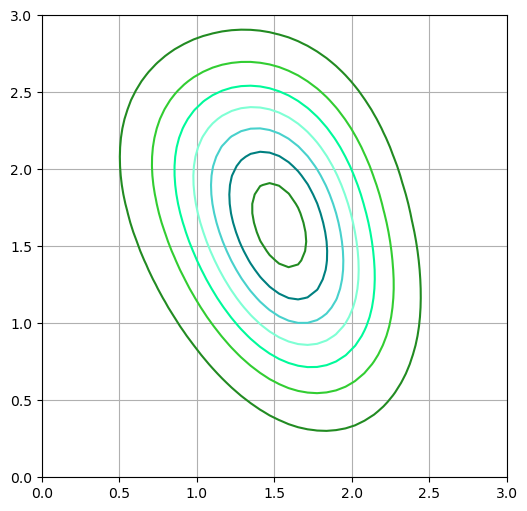

In [156]:
Z_true = trueDistribution2D(parameters_ep, clients_ep, 0, 3, plot=True)

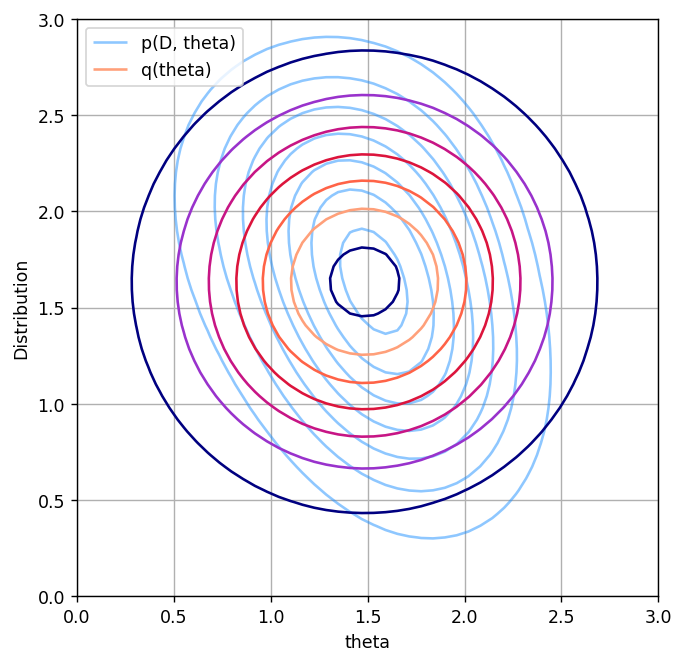

In [157]:
x = y = np.linspace(0,3)
X_q, Y_q = np.meshgrid(x, y)
plt.figure(figsize=(6,6), dpi=125)
trial_var = 1 / q_new_ep["variance"]
Z_q = Normal(q_new_ep["mean"], q_new_ep["variance"], [X_q, Y_q], parameters_ep["D"])

c1 = plt.contour(X_q,Y_q,Z_true, colors='dodgerblue', alpha=.5)
c2 = plt.contour(X_q,Y_q,Z_q, colors=cmap1)
h1,_=c1.legend_elements()
h2,_=c2.legend_elements()
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend([h1[0],h2[0]], ["p(D, theta)", "q(theta)"], loc="upper left")
plt.grid(visible=True)

### One Dimensional Example

In [27]:
#Parameters Definitions:
parameters_ep_ = {
    "w": 0.5,
    "a": 2.,
    "b": 100.,
    "D": 1,
    "N": 20,
    "Epochs": 10
}

q_global_ep_ = {
    "mean": 0.,
    "variance": parameters_ep_["b"]
}

clients_ep_ = []
for i in range(len(x_1d)):
    clients_ep_.append({
        "client_idx": i,
        "x_n": x_1d[i],
        "mean": 0.,
        "variance": np.inf,
        "variance_inverse": 0.,
        "normaliser": 1.,
        "iteration": 0
    })

In [28]:
q_new_ep_, clients_new_ep_ = ExpectationPropagation(clients_ep_, q_global_ep_, parameters_ep_)

Iteration 1:
New global q:  {'mean': array([-4.6369825]), 'variance': array([2.2446662])}
Iteration 2:
New global q:  {'mean': array([-3.9558498]), 'variance': array([0.7484995])}
Iteration 3:
New global q:  {'mean': array([2.1163927]), 'variance': array([0.76409569])}
Iteration 4:
New global q:  {'mean': array([3.44668343]), 'variance': array([0.17466718])}
Iteration 5:
New global q:  {'mean': array([3.37337397]), 'variance': array([0.19283979])}
Iteration 6:
New global q:  {'mean': array([3.37461874]), 'variance': array([0.1917635])}
Iteration 7:
New global q:  {'mean': array([3.37460817]), 'variance': array([0.19174375])}
Iteration 8:
New global q:  {'mean': array([3.37460668]), 'variance': array([0.19174363])}
Iteration 9:
New global q:  {'mean': array([3.37460668]), 'variance': array([0.19174363])}
Iteration 10:
New global q:  {'mean': array([3.37460668]), 'variance': array([0.19174363])}


In [29]:
evidence1D(q_new_ep_, clients_new_ep_, parameters_ep_)

array([9.22327572e-74])

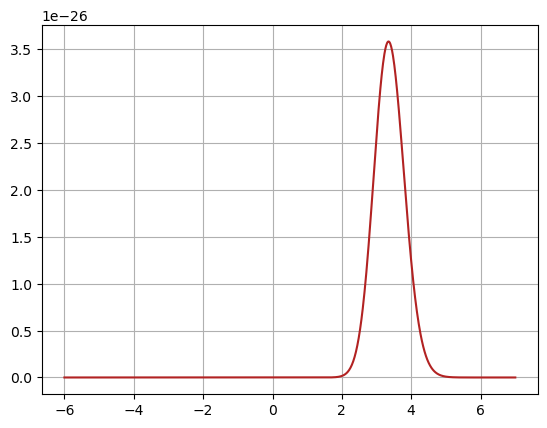

In [30]:
true_joint = trueDistribution1D(parameters_ep_, clients_ep_, -6,7)

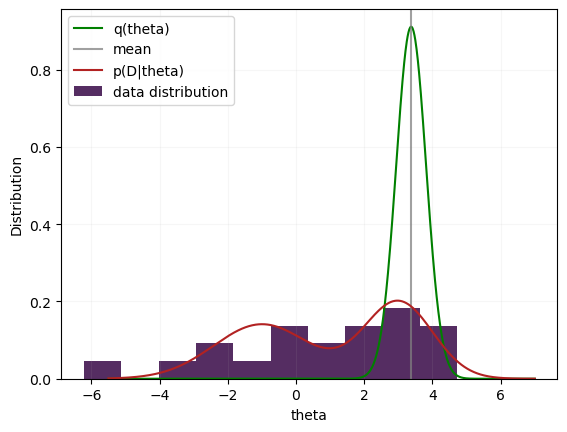

In [31]:
x = np.linspace(-5.5, 7, 1000)


plt.plot(x, Normal(q_new_ep_["mean"], q_new_ep_["variance"], x, 1), 
         label="q(theta)", color='green')
plt.axvline(q_new_ep_["mean"], color ="grey", label = "mean", alpha=.75)
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, w, mean_1d, var_1d, mean2_1d, var2_1d), color="firebrick", label="p(D|theta)")
plt.hist(x_1d, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)
#plt.savefig('outlier.png')

## Partitioned Variational Inference for the Clutter Problem

We initialize the approximating distributions as in the EP algorithm, we repeat this here for clarity:
The problem is formulated as follows:

The true likelihood and assumed prior are given below:

$p(\pmb{x}|\pmb{\theta})=(1-w)\mathcal{N}(\pmb{x}|\pmb{\theta}, \pmb{I}_d)+w\mathcal{N}(\pmb{x}|\pmb{0}, a\pmb{I}_d) \\
\pi(\pmb{\theta})=\mathcal{N}(\pmb{\theta}|\pmb{0}, b\pmb{I}_d)$

Over N observation we get the joint distribution of data $\mathcal{D}= \{\pmb{x}_1,...,\pmb{x}_N\}$:

$p(\mathcal{D},\pmb{\theta})=p(\pmb{\theta})\prod_{k=1}^Np(\pmb{x}_k|\pmb{\theta})$

We select approximation 

$q(\pmb{\theta}):=\mathcal{N}(\pmb{\theta}|\pmb{m}, v\pmb{I}_d)$,

with approximating factors --- not true distributions --- $t_n(\pmb{\theta})$:

$t_n(\pmb{\theta}):=s_n \exp \{-\frac{1}{2v_n}(\pmb{\theta}-\pmb{m}_n)^T(\pmb{\theta}-\pmb{m}_n)\},\; n\in [M],\; t_0(\pmb{\theta})=p(\pmb{\theta})$

Such that we have:

$q(\pmb{\theta})=\pi(\pmb{\theta})\prod_{n=1}^Mt_n(\pmb{\theta})$

The PVI algorithm, stated in Algorithm ... in my paper reduces to the following:
### PVI Algorithm Initialization:
We initialize $q(\pmb{\theta})=p(\pmb{\theta})$ by setting $t_i(\pmb{\theta})=1, \; \forall i\in 1,...,M$

We initialize this through setting $s_n=1$ where we are setting $v_n=\infty\implies v_n^{-1}=0$, and $\pmb{m}_n=\pmb{0}$. Each client has one datapoint in this experiment, we have 100 datapoints therefore 100 clients. 

For each iteration $i$ until convergence do:

For each client $n\in{1,...,M}$, do:

### Step 1

$q^{new}(\pmb{\theta})=\mathrm{arg\, max}_{q\in\mathcal{Q}}\int \log \frac{q^{(i-1)}(\pmb{\theta})p(\pmb{y}_n|\pmb{\theta})}{t_n^{(i-1)}(\pmb{\theta})q(\pmb{\theta})}dq(\pmb{\theta}) = 
\mathrm{arg\, min}_{q\in\mathcal{Q}}\mathrm{KL}\bigl(q(\pmb{\theta})\big|\big|\frac{1}{Z_n}\frac{q^{(i-1)}(\pmb{\theta})}{t_n^{(i-1)}(\pmb{\theta})}p(\pmb{y}_n|\pmb{\theta})\bigr), Z_n=\int\frac{q^{(i-1)}(\pmb{\theta})}{t_n^{(i-1)}(\pmb{\theta})}p(\pmb{y}_n|\pmb{\theta})d\pmb{\theta}$

$=\mathrm{arg\,max}_{q\in\mathcal{Q}} \Big\{ \sum_{k\neq \{0,n\}}^N\mathbb{E}_{q(\pmb{\theta})}\big[\log t_k^{(i-1)}(\pmb{\theta})\big]+\sum_{j\in n}\mathbb{E}_{q(\pmb{\theta})}\big[ \log p(\pmb{y}_{n_k}|\pmb{\theta}) \big]  - \mathrm{KL}\bigl(q(\pmb{\theta})\big|\big|\pi(\pmb{\theta})\bigr)\Big\}
$

$ =\mathrm{arg\,min}_{q\in\mathcal{Q}} \Big\{\mathrm{KL}\bigl(q(\pmb{\theta})\big|\big|q^{\backslash n}(\pmb{\theta})\bigr) -\sum_{j\in n}\mathbb{E}_{q(\pmb{\theta})}\big[ \log p(\pmb{y}_{n_j}|\pmb{\theta}) \big] \Big\}
$
### Step 2

Update $t_n(\pmb{\theta})$:

$t^{(i)}_n(\pmb{\theta})\propto \frac{q^{new}(\pmb{\theta})}{q^{(i-1)}(\pmb{\theta})}t^{(i-1)}_n(\pmb{\theta})$

and pass $\Delta_n(\pmb{\theta}) = \frac{t^{(i)}_n(\pmb{\theta})}{t^{(i-1)}_n(\pmb{\theta})}$ to the server.

### Step 3

At the server, update the global approximate likelihood $q^{(i)}(\pmb{\theta})$:

$q^{(i)}(\pmb{\theta})=q^{(i-1)}(\pmb{\theta})\Delta_n(\pmb{\theta})$

#### KLD between two Multivariate Gaussians
The KLD between two $d$-dimensional Multivariate Gaussians $q(\theta)\sim \mathcal{N}(\mu,\Sigma)$ and $p(\theta)\sim\mathcal{N}(\eta,\Lambda)$ is defined as follows:

$\mathrm{KLD}(q(\theta)||p(\theta))= \frac{1}{2}\bigl((\eta-\mu)^\top\Lambda^{-1}(\eta-\mu)+\mathrm{tr}(\Lambda^{-1}\Sigma)+\log \frac{|\Lambda|}{|\Sigma|}-d\bigr)
$

Which, in the case of spherical Gaussians, i.e. $q(\theta)\sim \mathcal{N}(\mu,\alpha\mathrm{I}_d)$ and $p(\theta)\sim\mathcal{N}(\eta,\beta\mathrm{I}_d)$, redused to the following:

$\mathrm{KLD}(q(\theta)||p(\theta))= \frac{1}{2}\bigl(\frac{1}{\beta}(\eta-\mu)^\top(\eta-\mu) +d\frac{\alpha}{\beta}-d\log\frac{\alpha}{\beta} -d\bigr)
$

#### The Alpha Renyi Divergence between two spherical Gaussians is

$\mathrm{D}_{AR}^{(\alpha)}(q(\theta)||\pi(\theta))= \frac{(\mu-\eta)^\top(\mu-\eta)}{2(\alpha\lambda +(1-\alpha)\sigma)} - \frac{D}{2\alpha(\alpha-1)}\log\frac{\alpha \lambda +(1-\alpha)\sigma}{\sigma^{1-\alpha}\:\lambda^{\alpha}}$

$= \frac{(\mu-\eta)^\top(\mu-\eta)}{2(\alpha\lambda +(1-\alpha)\sigma)} - \frac{D}{2\alpha(\alpha-1)}(\log (\alpha \lambda +(1-\alpha)\sigma) - \log (\sigma^{1-\alpha}\:\lambda^{\alpha}))$

$= \frac{(\mu-\eta)^\top(\mu-\eta)}{2(\alpha\lambda +(1-\alpha)\sigma)} + \frac{D}{2\alpha(\alpha-1)}(\log (\sigma^{1-\alpha}\:\lambda^{\alpha})-\log (\alpha \lambda +(1-\alpha)\sigma))$

$= \frac{(\mu-\eta)^\top(\mu-\eta)}{2(\alpha\lambda +(1-\alpha)\sigma)} - \frac{D}{2\alpha}\log (\sigma) + \frac{D}{2(\alpha-1)}\log(\lambda)-\frac{D}{2\alpha(\alpha-1)}\log (\alpha \lambda +(1-\alpha)\sigma))$

In [1037]:
def Divergence(q_original, p_likelihood, client, parameters):
    
    div = parameters["Divergence"]
    
    q_approximation = copy.deepcopy(q_original)
    
    if div == "KLD":
        print("Not implemented")
    elif div == "Alpha":
        print("Not implemented")
    elif div == "AR":
        print("Not implemented")
    
    return None  

def kl_gaussians(loc_1, loc_2, cov_1, cov_2):
        # Compute KL(p||q)= E_p(x)[log p(x) - log q(x)]
    assert loc_1.shape == loc_2.shape, "Not same dimension of means"
    assert cov_1.shape == cov_2.shape, "Not same Cov Matrix dimension"
    assert cov_1.shape[0] == cov_1.shape[1], "Not square matrix"

    d = cov_1.shape[0]
    diff = loc_2 - loc_1
    part_1 = torch.matmul(diff.unsqueeze(0), torch.linalg.solve(cov_2, diff.unsqueeze(-1))).squeeze()
    part_2 = torch.trace(torch.linalg.solve(cov_2, cov_1)).squeeze()
    part_3 = (torch.log(torch.linalg.det(cov_2)) - torch.log(torch.linalg.det(cov_1))).squeeze()

    #print(part_1, part_2, part_3, d)

    return (part_1 + part_2 + part_3 - d) / 2
    
def kl_spherical_gaussian(loc_1, loc_2, cov_1, cov_2, config):    
    
    diff = loc_2 - loc_1
    
    part_1 = torch.matmul(diff.unsqueeze(0), diff.unsqueeze(-1)).squeeze() / cov_2
    
    part_2 = config["D"] * cov_1 / cov_2
    
    part_3 = config["D"] * torch.log(torch.abs(cov_1) / torch.abs(cov_2))
    
    return (part_1 + part_2 - part_3 - config["D"]) / 2
    
def alpha_renyi(loc_1, loc_2, cov_1, cov_2, config):
    
    alpha = config["alpha"]
    
    diff = loc_2 - loc_1
    
    lin = (alpha * cov_2) + ((1 - alpha) * cov_1)
    
    part_1 = torch.matmul(diff.unsqueeze(0), torch.linalg.solve(lin, diff.unsqueeze(-1))).squeeze()
    
    part_2 = torch.log(torch.linalg.det(lin)).squeeze() / (alpha * (alpha - 1))
    
    part_3 = torch.log(torch.linalg.det(cov_1)).squeeze() / alpha
    
    part_4 = torch.log(torch.linalg.det(cov_2)).squeeze() / (1 - alpha)
    
    return (part_1 - part_2 - part_3 - part_4) / 2
    
def alpha_renyi_spherical(loc_1, loc_2, var_1, var_2, config):
    
    diff = loc_1 - loc_2
    
    part_1_ = torch.matmul(diff.unsqueeze(0), diff.unsqueeze(-1)).squeeze()
    
    lin = (config["alpha"] * var_2 + (1 - config["alpha"]) * var_1)
    
    part_1 = part_1_ / (2 * lin)
    
    coef_1 = config["D"] / (2 * config["alpha"])
    
    coef_2 = config["D"] / (2 * (config["alpha"] - 1))
    
    coef_3 = config["D"] / (2 * config["alpha"] * (config["alpha"] - 1))
    
    part_2 = coef_1 * torch.log(var_1)
    
    part_3 = coef_2 * torch.log(var_2)
    
    part_4 = coef_3 * torch.log(lin)
    
    return part_1 - part_2 + part_3 - part_4

def gamma_spherical(loc_1, loc_2, var_1, var_2, config):
    
    D = config["D"]
    gamma = config["gamma"]
    
    diff = loc_1 - loc_2
    part_1_ = torch.matmul(diff.unsqueeze(0), diff.unsqueeze(-1)).squeeze()
    lin = (torch.abs(var_2) + (gamma - 1) * torch.abs(var_1))
    part_1 = (part_1_ / (2 * lin)).squeeze()
    
    part_2 = (D / (2*gamma - 2)) * torch.log(lin).squeeze()
    
    part_3 = (D / (gamma -1)) * torch.log(torch.abs(var_1)).squeeze()
    
    #Only parts 1-3 are relevant for optimisation but taking out the constants might make convergence metrics
    #have different numbers that the ELBO converges to
    
    part_4 = (gamma/(gamma-1))*torch.log(torch.tensor(2*np.pi))
    
    part_5 = ((D*gamma)/(2*gamma - 2))*torch.log(torch.abs(var_2)).squeeze()
    
    part_6 = (D/2)*torch.log(torch.tensor(2*np.pi)).squeeze()
    
    part_7 = (D/(2*gamma - 2))*torch.log(torch.tensor(gamma)).squeeze()
    
    const = part_6 - part_7 - part_5 - part_4
    #const = 0.
    
    return part_1 + part_2 + part_3 + const
    

In [1038]:
def PartitionedVariationalInference(q_global, clients, parameters, is_1d=False, minibatch=False):
    # Implementation of Partitioned Variational Inference for Federated Learning (Bui et al. 2018, Ashman et al. 2022)
    
    # Initialization:
    
    D = parameters["D"]
    
    if parameters["Divergence"] != "AR":
        alpha = None
    else:
        alpha = parameters["alpha"]
    if parameters["Divergence"] != "G":
            gamma = None
    else:
        gamma = parameters["gamma"]
        
    if minibatch:
        batchsize = parameters["batch_size"]
    else:
        batchsize = np.inf
        
    config = {
        "D": D,
        "epochs": parameters["Epochs"], 
        "samples": parameters["samples"],
        "lr_scheduler_params": {"lr_lambda": lambda epoch: 1.0},
        "optim_epochs": parameters["optim_epochs"],
        "is_1d": is_1d,
        "alpha": alpha,
        "gamma": gamma,
        "early_stopping": False,
        "minibatch": minibatch,
        "batchsize": batchsize
    }
        
    print("Starting global q: ", q_global)
    
    for i in range(config["epochs"]):
    
        print("===========================================")
        print(f"Iteration {i+1}:")
        for n in range(len(clients)):
            q_global, t_new = Client.update_q(clients[n], q_global, parameters, config)
            
            clients[n]["mean"] = t_new["mean"]
            clients[n]["variance"] = t_new["variance"]
            clients[n]["variance_inverse"] = t_new["variance_inverse"]
            clients[n]["iteration"] += 1
            

        print("New global q: \n loc: ", q_global["loc"], "\n var: ", q_global["var"])
            
    return q_global, clients
    

In [1039]:
def SynchronousPVI(q_global, clients, parameters, is_1d=False, minibatch=False):
    # Implementation of Partitioned Variational Inference for Federated Learning (Bui et al. 2018, Ashman et al. 2022)
    
    # Initialization:
    
    D = parameters["D"]
    
    if parameters["Divergence"] != "AR":
        alpha = None
    else:
        alpha = parameters["alpha"]
    if parameters["Divergence"] != "G":
            gamma = None
    else:
        gamma = parameters["gamma"]
        
    if minibatch:
        batchsize = parameters["batch_size"]
    else:
        batchsize = np.inf
        
    config = {
        "D": D,
        "epochs": parameters["Epochs"], 
        "samples": parameters["samples"],
        "lr_scheduler_params": {"lr_lambda": lambda epoch: 1.0},
        "optim_epochs": parameters["optim_epochs"],
        "is_1d": is_1d,
        "alpha": alpha,
        "gamma": gamma,
        "early_stopping": False,
        "minibatch": minibatch,
        "batchsize": batchsize
    }
        
    print("Starting global q: ", q_global)
    
    for i in range(config["epochs"]):
    
        print("===========================================")
        print(f"Iteration {i+1}:")
        elbo_i = 0.
        
        q_global_list = []
        for n in range(len(clients)):
            temp = copy.deepcopy(q_global)
            q_global_list.append(temp)
            
        for n in range(len(clients)):
            print(f"Client {n}")
            q_new_n, t_new = Client.update_q(clients[n], q_global_list[n], parameters, config)
            clients[n]["mean"] = t_new["mean"]
            clients[n]["variance"] = t_new["variance"]
            clients[n]["variance_inverse"] = t_new["variance_inverse"]
            clients[n]["iteration"] += 1
            
            #Can we simply pass the q_global_list? instead of doing this to the clients?
            #clients[n]["q_n"]["loc"] = q_new_n["loc"].detach()
            #clients[n]["q_n"]["var"] = q_new_n["var"].detach()
            
            elbo_i += q_new_n["metrics"]["elbos"][i]
        
        q_global = aggregate_posteriors(q_global, q_global_list, elbo_i)
        
        print("New global q: \n loc: ", q_global["loc"], "\n var: ", q_global["var"])
        #if config["early_stopping"]:
                #break
            
    return q_global, clients

def aggregate_posteriors(q_global, q_global_list, elbo):    
    M = len(q_global_list)
    
    denom_var_inv = (M-1) * torch.linalg.inv(q_global["var"].detach())
    denom_var = torch.linalg.inv(denom_var_inv)
    
    denom_mean = torch.matmul(denom_var, (M-1) * torch.linalg.solve(
        q_global["var"].detach(), q_global["loc"].detach().unsqueeze(-1)))
    
    numer_var_inv = torch.zeros_like(q_global["var"].detach())
    for q in q_global_list:
        numer_var_inv += torch.linalg.inv(q["var"].detach())
        
    numer_var = torch.linalg.inv(numer_var_inv)
    
    numer_var_mean = torch.linalg.solve(
        q_global_list[0]["var"].detach(), q_global_list[0]["loc"].detach().unsqueeze(-1))
    
    for i in range(1, len(q_global_list)):
        numer_var_mean += torch.linalg.solve(
            q_global_list[i]["var"].detach(), q_global_list[i]["loc"].detach().unsqueeze(-1))
        
    numer_mean = torch.matmul(numer_var, numer_var_mean)
    
    q_new_var_inv = numer_var_inv - denom_var_inv
    
    q_new_var = torch.linalg.inv(q_new_var_inv)
    
    q_new_var_mean = torch.matmul(numer_var_inv, numer_mean) - torch.matmul(denom_var_inv, denom_mean)
    
    q_new_mean = torch.matmul(q_new_var, q_new_var_mean).squeeze(-1)
    
    q_new = copy.deepcopy(q_global)
    
    q_new["metrics"]["elbos"].append(elbo)
    q_new.update({"loc": torch.nn.Parameter(q_new_mean), "var": torch.nn.Parameter(q_new_var)})
    
    return q_new

In [1092]:
def AsynchronousPVI(q_global, clients, parameters, is_1d=False, minibatch=False):
    # Implementation of Partitioned Variational Inference for Federated Learning (Bui et al. 2018, Ashman et al. 2022)
    
    # Initialization:
    
    D = parameters["D"]
    
    if parameters["Divergence"] != "AR":
        alpha = None
    else:
        alpha = parameters["alpha"]
    if parameters["Divergence"] != "G":
            gamma = None
    else:
        gamma = parameters["gamma"]
        
    if minibatch:
        batchsize = parameters["batch_size"]
    else:
        batchsize = np.inf
        
    config = {
        "D": D,
        "epochs": parameters["Epochs"], 
        "samples": parameters["samples"],
        "lr_scheduler_params": {"lr_lambda": lambda epoch: 1.0},
        "optim_epochs": parameters["optim_epochs"],
        "is_1d": is_1d,
        "alpha": alpha,
        "gamma": gamma,
        "early_stopping": False,
        "minibatch": minibatch,
        "batchsize": batchsize
    }
        
    print("Starting global q: ", q_global)
    
    for i in range(config["epochs"]):
    
        print("===========================================")
        print(f"Iteration {i}:")
        elbo_i = 0.
        if i > 0:
            for n in range(len(clients)):
                if i % clients[n]["wait_time"] == 0:
                    if clients[n]["wait_time"] <= i:
                        q_global = update_q_async(q_global, clients[n])
              
        for n in range(len(clients)):
            if i % clients[n]["wait_time"] == 0:
                print(f"Client {n} with wait time: ", clients[n]["wait_time"])
                
                clients[n]["q_old"]["loc"] = q_global["loc"].detach()
                clients[n]["q_old"]["var"] = q_global["var"].detach()
                temp = copy.deepcopy(q_global)
                
                q_new_n, t_new = Client.update_q(clients[n], temp, parameters, config)
                clients[n]["q_new"]["loc"] = q_new_n["loc"].detach()
                clients[n]["q_new"]["var"] = q_new_n["var"].detach()
            
                clients[n]["mean"] = t_new["mean"]
                clients[n]["variance"] = t_new["variance"]
                clients[n]["variance_inverse"] = t_new["variance_inverse"]
                clients[n]["iteration"] += 1


        print("New global q: \n loc: ", q_global["loc"], "\n var: ", q_global["var"])
        #if config["early_stopping"]:
                #break      
    return q_global, clients

#Mixture of Experts calculation for q_m * q^i / q_m^old \propto q^(i+1)
def update_q_async(q_global, client):    
    
    var_inv = (torch.linalg.inv(client["q_new"]["var"]) + torch.linalg.inv(q_global["var"].detach()) 
               - torch.linalg.inv(client["q_old"]["var"]))
    
    q_new_var = torch.linalg.inv(var_inv)
    
    q_new_mean = torch.matmul(q_new_var, (torch.linalg.solve(client["q_new"]["var"], client["q_new"]["loc"].unsqueeze(-1)) 
                              + torch.linalg.solve(q_global["var"].detach(), q_global["loc"].detach().unsqueeze(-1))
                              - torch.linalg.solve(client["q_old"]["var"], client["q_old"]["loc"].unsqueeze(-1)))).squeeze(-1)
    
    q_current = copy.deepcopy(q_global)
    
    q_current.update({"loc": torch.nn.Parameter(q_new_mean), "var": torch.nn.Parameter(q_new_var)})
    
    return q_current

In [1040]:
class Client:    
    def get_default_config():
        return {
            "epochs": 20,
            "optimiser": "Adam",
            "optimiser_params": {"lr": 0.05},
            "model_optimiser_params": {},
            "sigma_optimiser_params": {},
            "lr_scheduler": "MultiplicativeLR",
            "lr_scheduler_params": {"lr_lambda": lambda epoch: 1.0},
        }
    
    def update_q(client, q, parameters, config):

        q_new, t_new = Client.gradient_based_update(client, q, parameters, config)

        return q_new, t_new

    def gradient_based_update(client, q, parameters, config):
        q_old = copy.deepcopy(q)
        q_cav = Client.cavity(q, client)

        q_params = list(q.items())
        
        
        q_parameters = [
                        {"params": q["loc"]},
                        {"params": q["var"]}
                    ]    
        
        #print(q_parameters)
        optimiser = torch.optim.Adam(q_parameters, lr=parameters["lr"])
        #print(optimiser)
        
        lr_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(
            optimiser, **config["lr_scheduler_params"])
        
        #epoch_iter = tqdm(
        #    range(config["epochs"]),
        #    desc="Epoch",
        #    leave=True,
        #)
        for i in range(config["optim_epochs"]):
            
            # Calculate the minimization step and iteratively refine the mean and variance parameters
            # Compute argmin(-F(q)) = argmin {KL(q||q_cav) - Sum(E_q[log p(y_k_i | theta)])}
            
            #epoch = defaultdict(lambda: 0.0)
            """if client["iteration"] > 0:
                print(i)
                print(f"q_cav: loc: ",q_cav["loc"], " and var: ",q_cav["var"])
                print(f"Client: loc: ", client["mean"]," var: ", client["variance"], " var_inverse: ", client["variance_inverse"])
                print(f"q current: loc: ", q["loc"].detach(), " and var: ", q["var"].detach())"""
            optimiser.zero_grad()
            
            coef = 1.
            batch = client["x_n"]
            if config["minibatch"]:
                coef = len(client["x_n"]) / config["batchsize"]
                batch = get_batch(client["x_n"], config["batchsize"])
            
            if client["spherical"]:
                if parameters["Divergence"] == "KLD":
                    div = kl_spherical_gaussian(q["loc"], q_cav["loc"], q["var"], q_cav["var"], config)
                elif parameters["Divergence"] == "AR":
                    div = alpha_renyi_spherical(q["loc"], q_cav["loc"], q["var"], q_cav["var"], config)
                elif parameters["Divergence"] == "G":
                    div = gamma_spherical(q["loc"], q_cav["loc"], q["var"], q_cav["var"], config)
                else:
                    print("!!! No Divergence specified !!!")
                    div = 0
            else:
                if parameters["Divergence"] == "KLD":
                    div = kl_gaussians(q["loc"], q_cav["loc"], q["var"], q_cav["var"])
                elif parameters["Divergence"] == "AR":
                    div = alpha_renyi(q["loc"], q_cav["loc"], q["var"], q_cav["var"], config)
                else:
                    print("!!! No Divergence specified !!!")
                    div = 0
                
            if config["is_1d"]:
                if q["var"] > 0:
                    q_dist = torch.distributions.normal.Normal(q["loc"], q["var"])
                else:
                    q_dist = torch.distributions.normal.Normal(q["loc"], torch.abs(q["var"]))                   
            else:
                if client["spherical"]:
                    if q["var"] > 0:
                        q_dist = torch.distributions.multivariate_normal.MultivariateNormal(
                            q["loc"], covariance_matrix=(q["var"] * torch.eye(config["D"])))
                    else:
                        q_dist = torch.distributions.multivariate_normal.MultivariateNormal(
                            q["loc"], covariance_matrix=(torch.abs(q["var"])* torch.eye(config["D"])))
                else:
                    #if parameters["Divergence"] == "KLD":    
                    q_dist = torch.distributions.multivariate_normal.MultivariateNormal(
                            q["loc"], covariance_matrix=q["var"])
                    #else:
                        #q_dist = torch.distributions.multivariate_normal.MultivariateNormal(
                                #q["loc"], covariance_matrix=(q["var"]+ (torch.eye(config["D"]) * JITTER)))
                        
            
            samples = q_dist.rsample((config["samples"],))
            
            ll = Client.expected_log_likelihood(client, batch, samples, parameters, config)
            
            ll = ll*coef
            
            ll /= len(samples)
            
            loss = div - ll
            
            #loss = -ll
            #if i == (config["optim_epochs"]-1):
            #    print(f"KL: {kl}, and log-like: {ll}")
            
            loss.backward()
            optimiser.step()
            
            if i == (config["optim_epochs"]-1):
                q["metrics"]["elbos"].append(-loss.item())
                q["metrics"]["kls"].append(div.item())
                q["metrics"]["lls"].append(ll.item())
        
        t_new = Client.update_client_t(client, q, q_old)
        lr_scheduler.step()
        return q, t_new
        
    def cavity(q, client):
        
        if client["spherical"]:
            v_bar_n_inverse = q["var"].detach() ** (-1) - client["variance_inverse"]
            v_bar_n = v_bar_n_inverse ** (-1)

            part = (v_bar_n) * client["variance_inverse"] * (q["loc"].detach() - client["mean"])

            m_bar_n = q["loc"].detach() + part
        else:
            v_bar_n_inverse = torch.linalg.inv(q["var"].detach()) - client["variance_inverse"]
            v_bar_n = torch.linalg.inv(v_bar_n_inverse)
            
            part = torch.linalg.solve(q["var"].detach(), q["loc"].detach().unsqueeze(-1)) - torch.matmul(client["variance_inverse"], client["mean"].unsqueeze(-1))
            m_bar_n = torch.linalg.solve(v_bar_n_inverse, part).squeeze(-1)
        return {
            "loc": m_bar_n,
            "var": v_bar_n
        }
    
    #This is wrong!!!! The cov for the data isn't always 1*I_d
    def expected_log_likelihood(client, batch, samples, parameters, config):
        ll = 0.
        Dim = None
        if config["is_1d"] or client["spherical"]:
            cov_list = [client["true_v"], client["noise_v"]]
            Dim = parameters["D"] if parameters["D"] > 1 else None
        else:
            cov_list = [client["true_v"], client["noise_v"]]
            
        if type(parameters["w"]) is list:
            params = parameters["w"]
        else:
            params = [(1 - parameters["w"]), parameters["w"]]
            
        for sample in samples:  
            mean_list = [sample, client["noise_m"]]
            for x in batch:
                ll += Gaussian.GaussianMixture(mean_list, cov_list, x, params, Dim).log()
            
        return ll
    
    #Not used and not updated
    def get_elbo(client, q, q_cav, parameters, config):
        
        batch = client["x_n"]
            
        kl = kl_spherical_gaussians(q["loc"], q_cav["loc"], q["var"], q_cav["var"], config)

        samples = q.rsample((parameters["samples"],))

        ll = 0.
        for sample in samples:
            ll += expected_log_likelihood(client, batch, sample, parameters)

        ll /= len(samples)

        loss = kl - ll
        
        return loss
    
    #We udate t according to the product of experts formula for gaussians
    def update_client_t(client, q, q_old):
        old_var = client["variance"]
        old_var_inv = client["variance_inverse"]
        old_mean = client["mean"]
        
        if client["spherical"] != True:
            Sigma = q["var"].detach()
            Lambda = q_old["var"].detach()
            
            mu = q["loc"].detach().unsqueeze(-1)
            eta = q_old["loc"].detach().unsqueeze(-1)
        
            Sigma_inv = torch.linalg.inv(Sigma)
            Lambda_inv = torch.linalg.inv(Lambda)
            
            variance_inverse = Sigma_inv - Lambda_inv + old_var_inv
            
            variance = torch.linalg.inv(variance_inverse)
            
            mean_ = (torch.linalg.solve(Sigma, mu) - torch.linalg.solve(Lambda, eta) +
                   torch.matmul(old_var_inv, old_mean.unsqueeze(-1)))
            
            mean = torch.matmul(variance, mean_).squeeze(-1)
            
            #print(f"New q: Sigma: {Sigma}, and Sigma_inv: {Sigma_inv}, and loc: {mu}")
            #print(f"Old q: Lambda: {Lambda}, and Lambda_inv: {Lambda_inv}, and loc: {eta}")
            
            if client["require_s_n"]:
                s_n = Client.compute_mult_normaliser(client, q, q_old, variance_inverse, variance, mean)
            else:
                s_n = None
        else:
            variance_inverse = ((q["var"].detach() ** -1) - 
                                (q_old["var"].detach() ** -1) + client["variance_inverse"])
            variance = variance_inverse ** -1
            
            mean = variance * ((q["var"].detach() ** -1) * q["loc"].detach() -
                   (q_old["var"].detach() ** -1) * q_old["loc"].detach() +
                   client["variance_inverse"] * old_mean)
            
            if client["require_s_n"]:
                s_n = Client.compute_normaliser(client, q, q_old, variance_inverse, variance, mean)
            else:
                s_n = None

            
        #print("variance_inverse: ", variance_inverse)
        #print("variance: ", variance)
        #print("mean: ", mean)
        return {
            "mean": mean,
            "variance": variance,
            "variance_inverse": variance_inverse,
            "normaliser": s_n
        }
            
        
    def compute_normaliser(client, q, q_old, variance_inverse, variance, mean):
        s_n = client["normaliser"]
        """Lambda = q_old["var"].detach()
        Sigma = q["var"].detach()
        S = client["variance"]
        S_inv = client["variance_inverse"]
        m = client["mean"]
        mu = q["loc"].detach()
        eta = q_old["loc"].detach()"""
        
        return s_n


    def compute_mult_normaliser(client, q, q_old, variance_inverse, variance, mean):
        return client["normaliser"]
    
    

### PVI One Dimensional Example

In [35]:
#Parameters Definitions:
parameters_ = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([2.]),
    "b": torch.tensor([100.]),
    "D": 1,
    "N": 20,
    "Epochs": 50,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

loc_ = torch.tensor([-1.])


q_global_ = {
    "loc": torch.nn.Parameter(loc_),
    "var": torch.nn.Parameter(parameters_["b"]),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_ = []
for i in range(parameters_["N"]):
    clients_.append({
        "client_idx": i,
        "x_n": torch.tensor([[x_1d[i]]]),
        "mean": torch.tensor([0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([1.]),
        "noise_m": torch.tensor([-1]),
        "noise_v": parameters_["a"],
        "spherical": True,
        "require_s_n": False
    })

In [36]:
q_new_, clients_new_ = PartitionedVariationalInference(q_global_, clients_, parameters_, is_1d=True)

Starting global q:  {'loc': Parameter containing:
tensor([-1.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([-1.3722], requires_grad=True) 
 var:  Parameter containing:
tensor([96.8901], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([-1.5436], requires_grad=True) 
 var:  Parameter containing:
tensor([93.9144], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([-1.6207], requires_grad=True) 
 var:  Parameter containing:
tensor([90.9974], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([-1.3216], requires_grad=True) 
 var:  Parameter containing:
tensor([88.2332], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([-1.0571], requires_grad=True) 
 var:  Parameter containing:
tensor([85.6468], require

New global q: 
 loc:  Parameter containing:
tensor([3.1291], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2519], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([3.0758], requires_grad=True) 
 var:  Parameter containing:
tensor([0.3041], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([3.1137], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2716], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([3.0995], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2658], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([3.1053], requires_grad=True) 
 var:  Parameter containing:
tensor([0.3137], requires_grad=True)
Iteration 45:
New global q: 
 loc:  Parameter containing:
tensor([3.1133], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2852], requires_grad=True)
Iteration 46:
New global q: 
 loc:  Parame

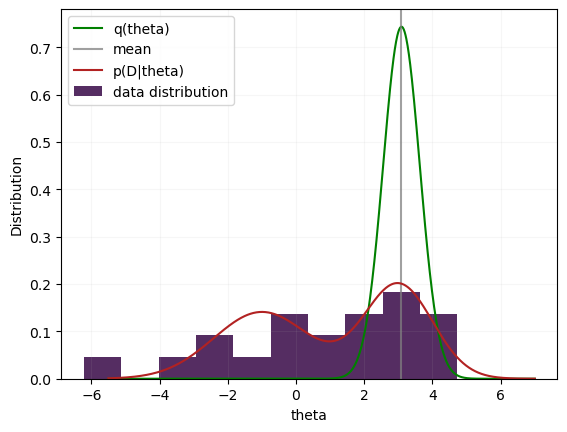

In [37]:
x = np.linspace(-5.5, 7, 1000)


plt.plot(x, Normal(q_new_["loc"].detach().squeeze().numpy(), q_new_["var"].detach().squeeze().numpy(), x, 1),
         label="q(theta)", color='green')
plt.axvline(q_new_["loc"].detach().squeeze().numpy(), color ="grey", label = "mean", alpha=.75)
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, w, mean_1d, var_1d, mean2_1d, var2_1d), color="firebrick", label="p(D|theta)")
plt.hist(x_1d, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

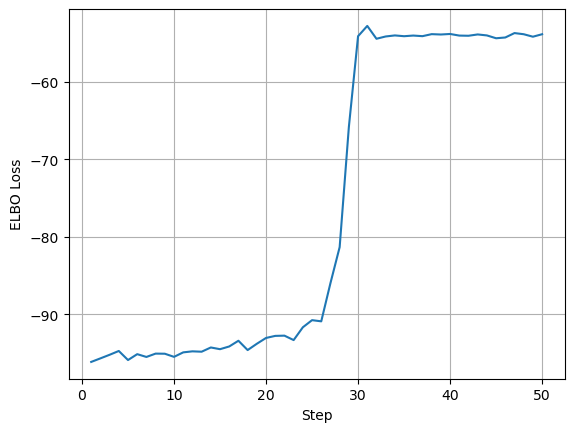

In [38]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_["Epochs"]):
    running_total = 0.
    for j in range((i* parameters_["N"]),((i+1)* parameters_["N"])):
         running_total += q_new_["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

### PVI Two Dimensional Example
#### Initializing parameters, q_global and clients

In [427]:
parameters = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([2.]),
    "b": torch.tensor([100.]),
    "D": 2,
    "N": 20,
    "Epochs": 100,
    "Divergence": "KLD",
    "lr": 0.005,
    "samples": 50,
    "optim_epochs": 30
}

loc = torch.tensor([0.,0.])
variance_param = torch.tensor([100.])

q_global = {
    "loc": torch.nn.Parameter(loc),
    "var": torch.nn.Parameter(variance_param),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients = []
for i in range(parameters["N"]):
    clients.append({
        "client_idx": i,
        "x_n": torch.tensor([[x_[i], y_[i]]]),
        "mean": torch.tensor([0., 0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([1.]),
        "noise_m": torch.tensor([0., 0.]),
        "noise_v": parameters["a"],
        "spherical": True,
        "require_s_n": False
    })

In [428]:
q_new, clients_new = PartitionedVariationalInference(q_global, clients, parameters)

Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([ 0.0850, -0.0583], requires_grad=True) 
 var:  Parameter containing:
tensor([97.6868], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([0.1471, 0.1436], requires_grad=True) 
 var:  Parameter containing:
tensor([95.2640], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([0.1118, 0.0701], requires_grad=True) 
 var:  Parameter containing:
tensor([92.9248], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([0.1282, 0.3071], requires_grad=True) 
 var:  Parameter containing:
tensor([90.6351], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([0.4297, 0.2122], requires_grad=True) 
 var:  Paramet

New global q: 
 loc:  Parameter containing:
tensor([0.8063, 0.4606], requires_grad=True) 
 var:  Parameter containing:
tensor([14.9867], requires_grad=True)
Iteration 39:
New global q: 
 loc:  Parameter containing:
tensor([0.7531, 0.5500], requires_grad=True) 
 var:  Parameter containing:
tensor([12.8411], requires_grad=True)
Iteration 40:
New global q: 
 loc:  Parameter containing:
tensor([0.7910, 0.5412], requires_grad=True) 
 var:  Parameter containing:
tensor([10.7720], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([0.9076, 0.6810], requires_grad=True) 
 var:  Parameter containing:
tensor([8.9667], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([0.8958, 0.6990], requires_grad=True) 
 var:  Parameter containing:
tensor([7.3465], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([0.9304, 0.6908], requires_grad=True) 
 var:  Parameter containing:
tensor([6.0128], requires_gr

New global q: 
 loc:  Parameter containing:
tensor([1.4515, 2.1587], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2966], requires_grad=True)
Iteration 78:
New global q: 
 loc:  Parameter containing:
tensor([1.4252, 2.1557], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2877], requires_grad=True)
Iteration 79:
New global q: 
 loc:  Parameter containing:
tensor([1.4477, 2.1598], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2733], requires_grad=True)
Iteration 80:
New global q: 
 loc:  Parameter containing:
tensor([1.4379, 2.1400], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2764], requires_grad=True)
Iteration 81:
New global q: 
 loc:  Parameter containing:
tensor([1.4755, 2.1900], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2709], requires_grad=True)
Iteration 82:
New global q: 
 loc:  Parameter containing:
tensor([1.4313, 2.1126], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2623], requires_grad=

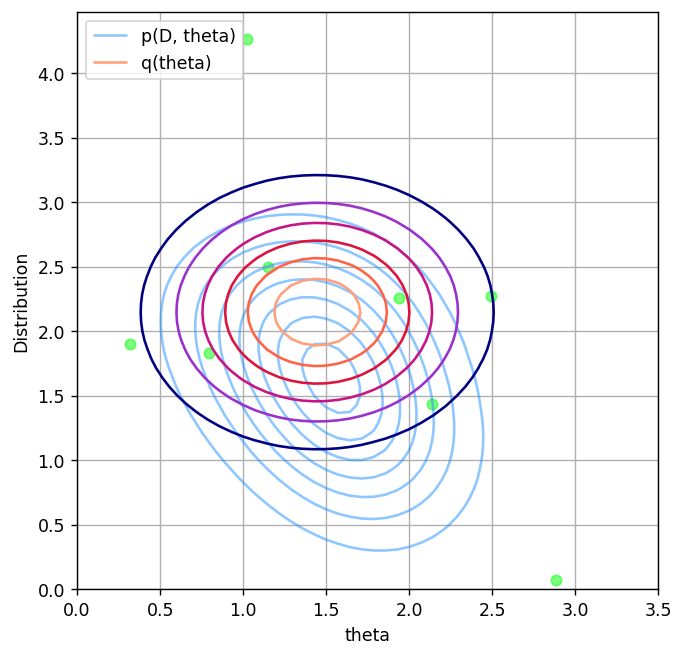

In [429]:
x = np.linspace(0,3.5)
y = np.linspace(0,3.5)
X_q, Y_q = np.meshgrid(x, y)
plt.figure(figsize=(6,6), dpi=125)
Z_pvi = Normal(q_new["loc"].detach().squeeze().numpy(), q_new["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters["D"])

Z_true_h = trueDistribution2D(parameters, clients_new, 0,3.5)

c1 = plt.contour(X_q,Y_q,Z_true_h, colors='dodgerblue', alpha=.5)

c2 = plt.contour(X_q,Y_q,Z_pvi, colors = cmap1)

#plt.scatter(x_,y_,color="firebrick")
h1,_=c1.legend_elements()
h2,_=c2.legend_elements()
plt.xlabel("theta")
plt.ylabel("Distribution")
for i in range(len(x_)):
    if x_[i] >= 0 and y_[i] >= 0:
        plt.scatter(x_[i], y_[i], color="lime", alpha=.5)
plt.legend([h1[0],h2[0]], ["p(D, theta)", "q(theta)"], loc="upper left")
plt.grid(visible=True)
#plt.savefig("Erroneous_PVI_posterior.png")

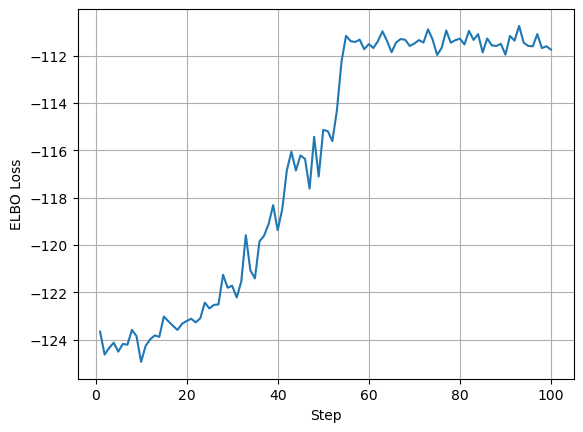

In [430]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters["Epochs"]):
    running_total = 0.
    for j in range((i* parameters["N"]),((i+1)* parameters["N"])):
         running_total += q_new["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

# Comparing EP Results with PVI Results
## One Dimensional Example

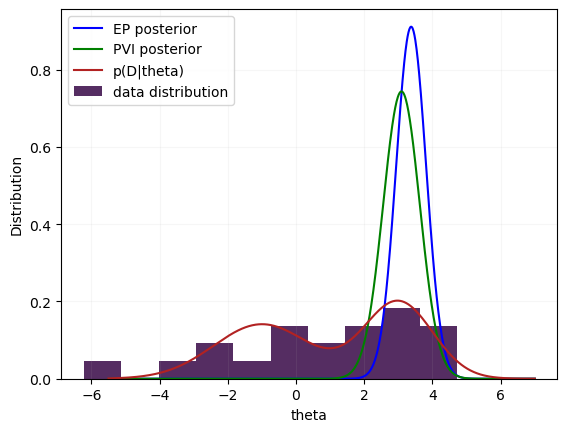

In [43]:
x = np.linspace(-5.5, 7, 1000)

plt.plot(x, Normal(q_new_ep_["mean"], q_new_ep_["variance"], x, 1),
         label="EP posterior", color='blue')
#plt.axvline(q_new_ep_["mean"].numpy(), color ="grey", label = "mean EP", alpha=.5)

plt.plot(x, Normal(q_new_["loc"].detach().squeeze().numpy(), q_new_["var"].detach().squeeze().numpy(), x, 1),
         label="PVI posterior", color='green')
#plt.axvline(q_new_["loc"].detach().squeeze().numpy(), color ="black", label = "mean PVI", alpha=.5)

#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, w, mean_1d, var_1d, mean2_1d, var2_1d), color="firebrick", label="p(D|theta)")
plt.hist(x_1d, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)
#plt.savefig('PVI_and_EP_diff.png')

## Two Dimensional Example

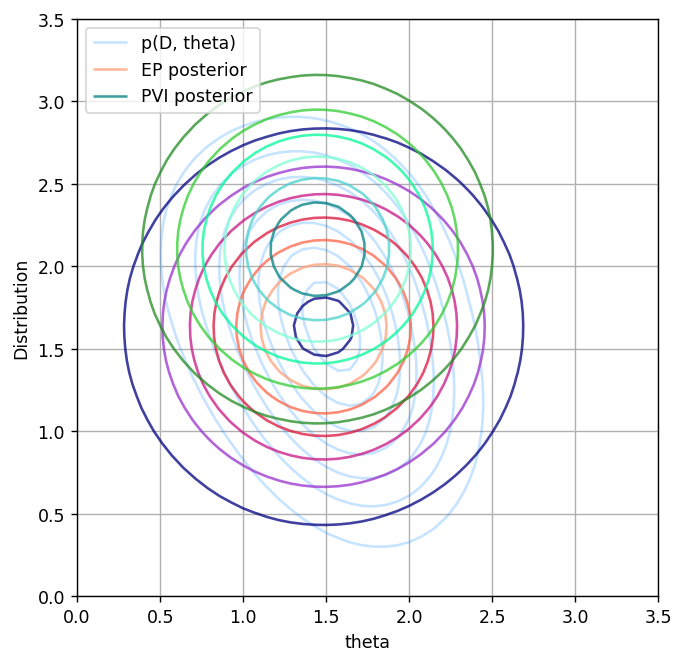

In [151]:
x = np.linspace(0,3.5)
y = np.linspace(0,3.5)
X_q, Y_q = np.meshgrid(x, y)
plt.figure(figsize=(6,6), dpi=125)
Z_pvi = Normal(q_new["loc"].detach().squeeze().numpy(), q_new["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters["D"])

Z_true_h = trueDistribution2D(parameters, clients, 0., 3.5)

Z_ep = Normal(q_new_ep["mean"], q_new_ep["variance"], [X_q, Y_q], parameters["D"])


c1 = plt.contour(X_q,Y_q,Z_true_h, colors='dodgerblue', alpha=.25)
c2 = plt.contour(X_q,Y_q,Z_ep, colors=cmap1, alpha=.75)

c3 = plt.contour(X_q,Y_q,Z_pvi, colors = cmap2, alpha =.75)

h1,_=c1.legend_elements()
h2,_=c2.legend_elements()
h3,_=c3.legend_elements()
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend([h1[0],h2[0], h3[0]], ["p(D, theta)", "EP posterior", "PVI posterior"], loc="upper left")
plt.grid(visible=True)

# Debugging PVI code
## Extra Examples
### Unimodal 1 dimensional distribution

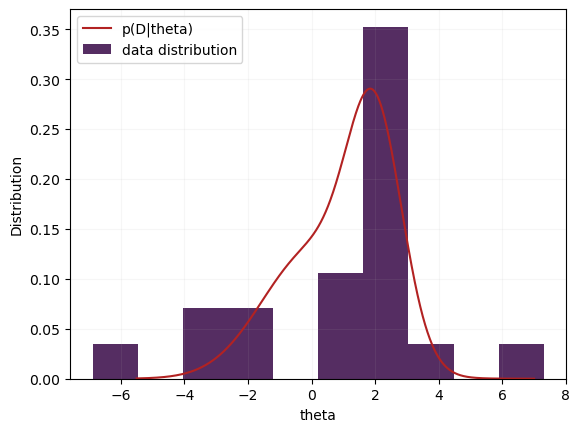

In [939]:
#Defining the model and sampling data points

mean_1_uni = torch.tensor([2.])
var_1_uni = torch.tensor([0.75])
mean_2_uni = torch.tensor([0.])
var_2_uni = torch.tensor([2.5])
w = 0.5

samples_uni = Gaussian.SampleFromMixture([mean_1_uni,mean_2_uni], [var_1_uni,var_2_uni], torch.tensor([w,w]), 20)
samp = samples_uni.numpy()

x = np.linspace(-5.5, 7, 1000)

plt.plot(x, Mix(x, 0.5, 2., 0.75, 0., 2.5), color="firebrick", label="p(D|theta)")
plt.hist(samp, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

In [951]:
parameters_uni = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([2.5]),
    "b": torch.tensor([100.]),
    "D": 1,
    "N": 20,
    "Epochs": 50,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

q_global_uni = {
    "loc": torch.nn.Parameter(torch.tensor([0.])),
    "var": torch.nn.Parameter(parameters_uni["b"]),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_uni = []
for i in range(parameters_["N"]):
    clients_uni.append({
        "client_idx": i,
        "x_n": torch.tensor([[samp[i][0]]]),
        "mean": torch.tensor([0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": var_1_uni,
        "noise_m": torch.tensor([0.]),
        "noise_v": parameters_["a"],
        "spherical": True,
        "require_s_n": False
    })

In [47]:
q_new_uni, clients_new_uni = PartitionedVariationalInference(q_global_uni, clients_uni, parameters_uni, is_1d=True)

Starting global q:  {'loc': Parameter containing:
tensor([0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([0.0687], requires_grad=True) 
 var:  Parameter containing:
tensor([97.1702], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([-0.1094], requires_grad=True) 
 var:  Parameter containing:
tensor([94.7725], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([-0.6608], requires_grad=True) 
 var:  Parameter containing:
tensor([92.1141], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([-0.6708], requires_grad=True) 
 var:  Parameter containing:
tensor([89.8862], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([-0.6076], requires_grad=True) 
 var:  Parameter containing:
tensor([87.1423], requires_

New global q: 
 loc:  Parameter containing:
tensor([2.0215], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1887], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([2.0306], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2205], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([1.9833], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1918], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([2.0301], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2307], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([2.0214], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2024], requires_grad=True)
Iteration 45:
New global q: 
 loc:  Parameter containing:
tensor([2.0221], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2210], requires_grad=True)
Iteration 46:
New global q: 
 loc:  Parame

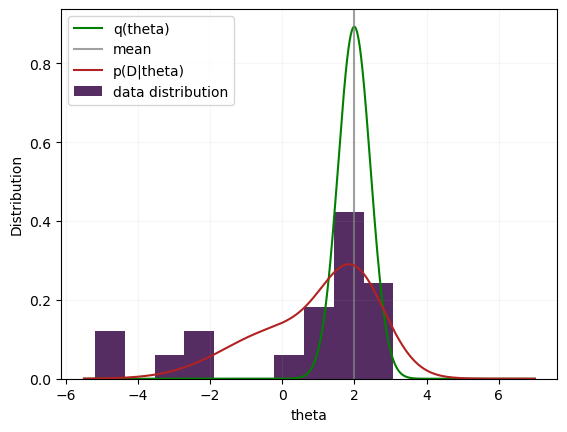

In [48]:
x = np.linspace(-5.5, 7, 1000)


plt.plot(x, Normal(q_new_uni["loc"].detach().squeeze().numpy(), q_new_uni["var"].detach().squeeze().numpy(), x, 1),
         label="q(theta)", color='green')
plt.axvline(q_new_uni["loc"].detach().squeeze().numpy(), color ="grey", label = "mean", alpha=.75)
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, 0.5, 2., 0.75, 0., 2.5), color="firebrick", label="p(D|theta)")
plt.hist(samp, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

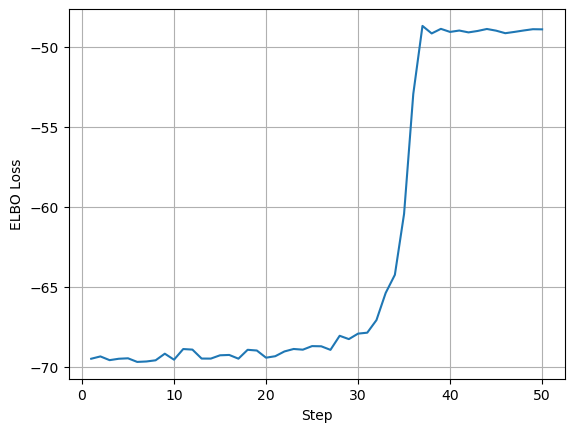

In [49]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_uni["Epochs"]):
    running_total = 0.
    for j in range((i* parameters_uni["N"]),((i+1)* parameters_uni["N"])):
         running_total += q_new_uni["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

### Strongly Bimodal 1 Dimensional Normal

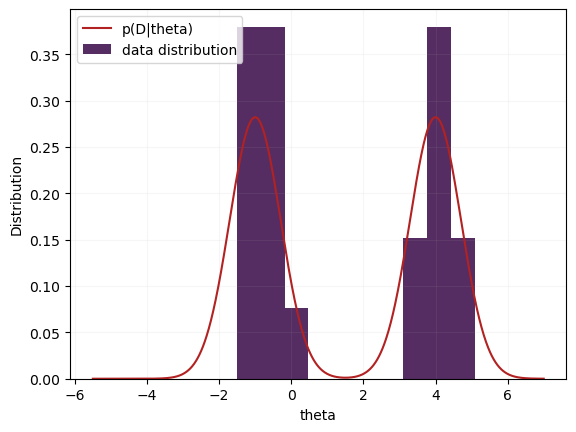

In [844]:
#Defining the model and sampling data points

mean_1_uni2 = torch.tensor([4.])
var_1_uni2 = torch.tensor([.5])
mean_2_uni2 = torch.tensor([-1.])
var_2_uni2 = torch.tensor([.5])
w_uni = 0.5

samples_uni2 = Gaussian.SampleFromMixture([mean_1_uni2,mean_2_uni2], [var_1_uni2,var_2_uni2], torch.tensor([.5,.5]), 20)
samp2 = samples_uni2.numpy()

x = np.linspace(-5.5, 7, 1000)

plt.plot(x, Mix(x, 0.5, 4., .5, -1., .5), color="firebrick", label="p(D|theta)")
plt.hist(samp2, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

In [845]:
parameters_uni2 = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([.5]),
    "b": torch.tensor([100.]),
    "D": 1,
    "N": 20,
    "Epochs": 50,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

q_global_uni2 = {
    "loc": torch.nn.Parameter(torch.tensor([0.])),
    "var": torch.nn.Parameter(parameters_uni2["b"]),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_uni2 = []
for i in range(parameters_uni2["N"]):
    clients_uni2.append({
        "client_idx": i,
        "x_n": torch.tensor([[samp2[i][0]]]),
        "mean": torch.tensor([0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": var_1_uni2,
        "noise_m": torch.tensor([-1.]),
        "noise_v": parameters_uni2["a"],
        "spherical": True,
        "require_s_n": False
    })

In [846]:
q_new_uni2, clients_new_uni2 = PartitionedVariationalInference(q_global_uni2, clients_uni2, parameters_uni2, is_1d=True)

Starting global q:  {'loc': Parameter containing:
tensor([0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([0.1830], requires_grad=True) 
 var:  Parameter containing:
tensor([96.7960], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([0.5016], requires_grad=True) 
 var:  Parameter containing:
tensor([93.6454], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([0.4164], requires_grad=True) 
 var:  Parameter containing:
tensor([90.9196], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([0.2110], requires_grad=True) 
 var:  Parameter containing:
tensor([88.3566], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([-0.0669], requires_grad=True) 
 var:  Parameter containing:
tensor([85.3336], requires_gra

New global q: 
 loc:  Parameter containing:
tensor([4.1645], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1923], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([4.1485], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1612], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([4.1590], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1654], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([4.1484], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1648], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([4.1386], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1707], requires_grad=True)
Iteration 45:
New global q: 
 loc:  Parameter containing:
tensor([4.1527], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1624], requires_grad=True)
Iteration 46:
New global q: 
 loc:  Parame

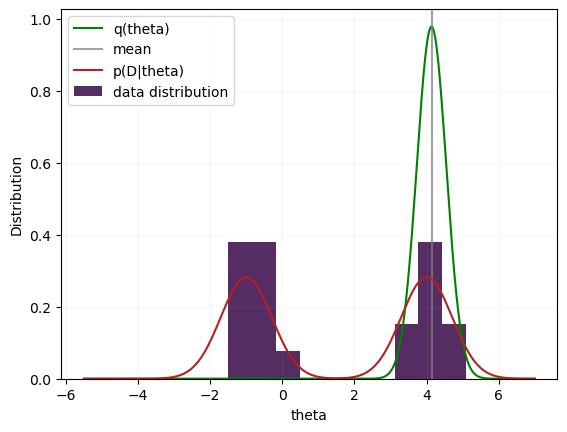

In [847]:
x = np.linspace(-5.5, 7, 1000)


plt.plot(x, Normal(q_new_uni2["loc"].detach().squeeze().numpy(), q_new_uni2["var"].detach().squeeze().numpy(), x, 1),
         label="q(theta)", color='green')
plt.axvline(q_new_uni2["loc"].detach().squeeze().numpy(), color ="grey", label = "mean", alpha=.75)
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, 0.5, 4., .5, -1., .5), color="firebrick", label="p(D|theta)")
plt.hist(samp2, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

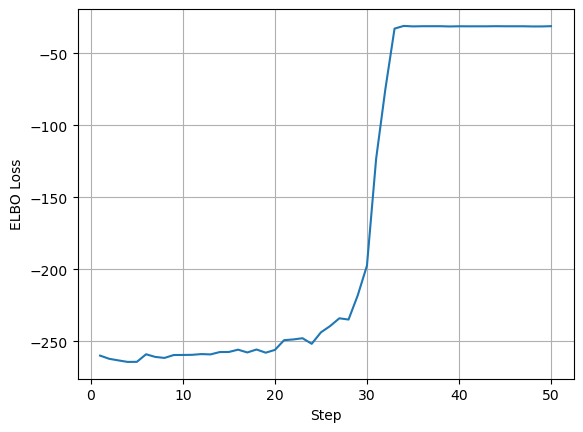

In [848]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_uni2["Epochs"]):
    running_total = 0.
    for j in range((i* parameters_uni2["N"]),((i+1)* parameters_uni2["N"])):
         running_total += q_new_uni2["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

#### More extreme experiment

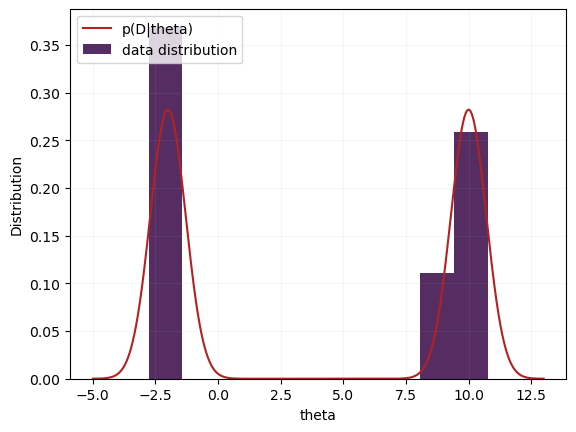

In [55]:
#Defining the model and sampling data points

mean_1_uni3 = torch.tensor([10.])
var_1_uni3 = torch.tensor([.5])
mean_2_uni3 = torch.tensor([-2.])
var_2_uni3 = torch.tensor([.5])
w_uni = 0.5

samples_uni3 = Gaussian.SampleFromMixture([mean_1_uni3,mean_2_uni3], [var_1_uni3,var_2_uni3], torch.tensor([.5,.5]), 20)
samp3 = samples_uni3.numpy()

x = np.linspace(-5., 13, 1000)

plt.plot(x, Mix(x, 0.5, 10., .5, -2., .5), color="firebrick", label="p(D|theta)")
plt.hist(samp3, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

In [56]:
parameters_uni3 = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([.5]),
    "b": torch.tensor([100.]),
    "D": 1,
    "N": 20,
    "Epochs": 70,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

q_global_uni3 = {
    "loc": torch.nn.Parameter(torch.tensor([0.])),
    "var": torch.nn.Parameter(parameters_uni3["b"]),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_uni3 = []
for i in range(parameters_uni3["N"]):
    clients_uni3.append({
        "client_idx": i,
        "x_n": torch.tensor([[samp3[i][0]]]),
        "mean": torch.tensor([0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": var_1_uni3,
        "noise_m": torch.tensor([-1.]),
        "noise_v": parameters_uni3["a"],
        "spherical": True,
        "require_s_n": False
    })

In [57]:
q_new_uni3, clients_new_uni3 = PartitionedVariationalInference(q_global_uni3, clients_uni3, parameters_uni3, is_1d=True)

Starting global q:  {'loc': Parameter containing:
tensor([0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([0.0716], requires_grad=True) 
 var:  Parameter containing:
tensor([96.7963], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([-0.2912], requires_grad=True) 
 var:  Parameter containing:
tensor([93.7054], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([-0.8085], requires_grad=True) 
 var:  Parameter containing:
tensor([90.0777], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([-0.6481], requires_grad=True) 
 var:  Parameter containing:
tensor([86.7644], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([-0.2159], requires_grad=True) 
 var:  Parameter containing:
tensor([83.5713], requires_

New global q: 
 loc:  Parameter containing:
tensor([10.0281], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1893], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([10.0552], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1769], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([10.0321], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1512], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([10.0776], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1611], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([10.0022], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1755], requires_grad=True)
Iteration 45:
New global q: 
 loc:  Parameter containing:
tensor([10.0732], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1434], requires_grad=True)
Iteration 46:
New global q: 
 loc:  

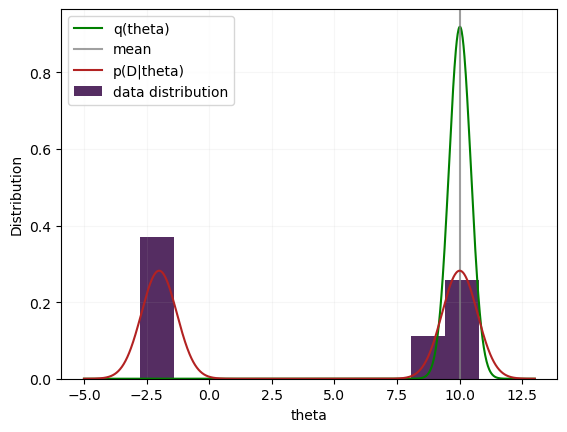

In [58]:
x = np.linspace(-5, 13, 1000)

plt.plot(x, Normal(q_new_uni3["loc"].detach().squeeze().numpy(), q_new_uni3["var"].detach().squeeze().numpy(), x, 1),
         label="q(theta)", color='green')
plt.axvline(q_new_uni3["loc"].detach().squeeze().numpy(), color ="grey", label = "mean", alpha=.75)
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, 0.5, 10., .5, -2., .5), color="firebrick", label="p(D|theta)")
plt.hist(samp3, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

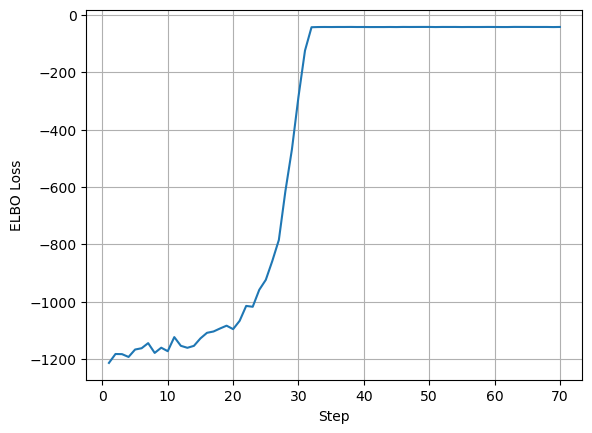

In [59]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_uni3["Epochs"]):
    running_total = 0.
    for j in range((i* parameters_uni3["N"]),((i+1)* parameters_uni3["N"])):
         running_total += q_new_uni3["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

#### Even more extreme!!!

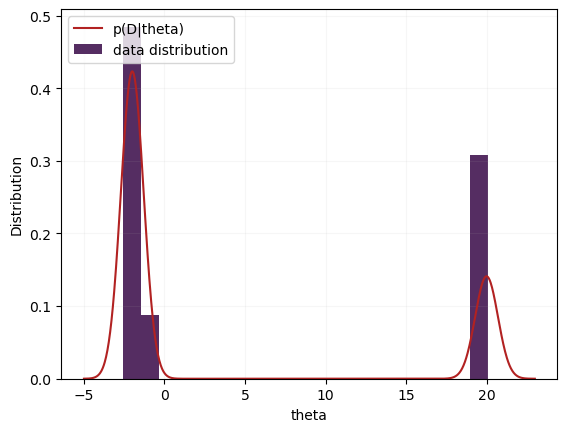

In [60]:
#Defining the model and sampling data points

mean_1_uni4 = torch.tensor([20.])
var_1_uni4 = torch.tensor([.5])
mean_2_uni4 = torch.tensor([-2.])
var_2_uni4 = torch.tensor([.5])
w_uni = 0.75

samples_uni4 = Gaussian.SampleFromMixture([mean_1_uni4,mean_2_uni4], [var_1_uni4,var_2_uni4], torch.tensor([.25,.75]), 20)
samp4 = samples_uni4.numpy()

x = np.linspace(-5., 23, 1000)

plt.plot(x, Mix(x, 0.75, 20., .5, -2., .5), color="firebrick", label="p(D|theta)")
plt.hist(samp4, density=True, bins=20, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

In [61]:
parameters_uni4 = {
    "w": torch.tensor(0.25),
    "a": torch.tensor([.5]),
    "b": torch.tensor([100.]),
    "D": 1,
    "N": 20,
    "Epochs": 75,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

q_global_uni4 = {
    "loc": torch.nn.Parameter(torch.tensor([0.])),
    "var": torch.nn.Parameter(parameters_uni4["b"]),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_uni4 = []
for i in range(parameters_uni4["N"]):
    clients_uni4.append({
        "client_idx": i,
        "x_n": torch.tensor([[samp4[i][0]]]),
        "mean": torch.tensor([0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": var_1_uni4,
        "noise_m": torch.tensor([-1.]),
        "noise_v": parameters_uni4["a"],
        "spherical": True,
        "require_s_n": False
    })

In [62]:
q_new_uni4, clients_new_uni4 = PartitionedVariationalInference(q_global_uni4, clients_uni4, parameters_uni4, is_1d=True)

Starting global q:  {'loc': Parameter containing:
tensor([0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([0.2299], requires_grad=True) 
 var:  Parameter containing:
tensor([96.8542], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([0.4929], requires_grad=True) 
 var:  Parameter containing:
tensor([93.7570], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([0.6155], requires_grad=True) 
 var:  Parameter containing:
tensor([90.4652], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([-0.0432], requires_grad=True) 
 var:  Parameter containing:
tensor([87.6385], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([0.0967], requires_grad=True) 
 var:  Parameter containing:
tensor([84.2335], requires_gra

New global q: 
 loc:  Parameter containing:
tensor([19.8816], requires_grad=True) 
 var:  Parameter containing:
tensor([0.7435], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([19.6835], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1680], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([19.5913], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1660], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([19.5665], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2038], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([19.6257], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1749], requires_grad=True)
Iteration 45:
New global q: 
 loc:  Parameter containing:
tensor([19.5340], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2403], requires_grad=True)
Iteration 46:
New global q: 
 loc:  

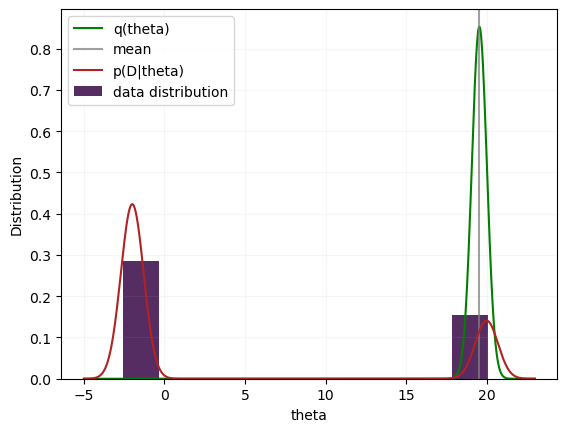

In [63]:
x = np.linspace(-5, 23, 1000)


plt.plot(x, Normal(q_new_uni4["loc"].detach().squeeze().numpy(), q_new_uni4["var"].detach().squeeze().numpy(), x, 1),
         label="q(theta)", color='green')
plt.axvline(q_new_uni4["loc"].detach().squeeze().numpy(), color ="grey", label = "mean", alpha=.75)
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, 0.75, 20., .5, -2., .5), color="firebrick", label="p(D|theta)")
plt.hist(samp4, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

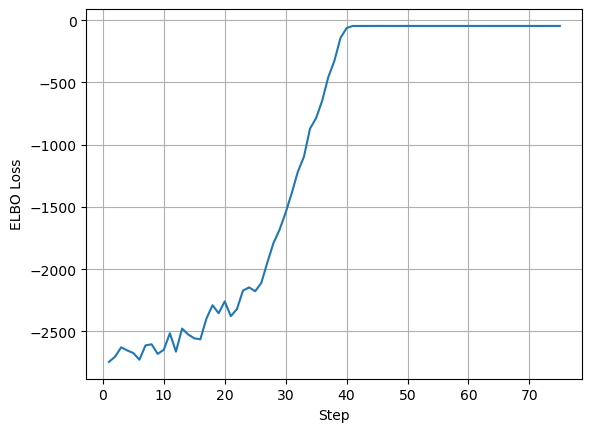

In [64]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_uni4["Epochs"]):
    running_total = 0.
    for j in range((i* parameters_uni4["N"]),((i+1)* parameters_uni4["N"])):
         running_total += q_new_uni4["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

### Bimodal 2 dimensional distribution

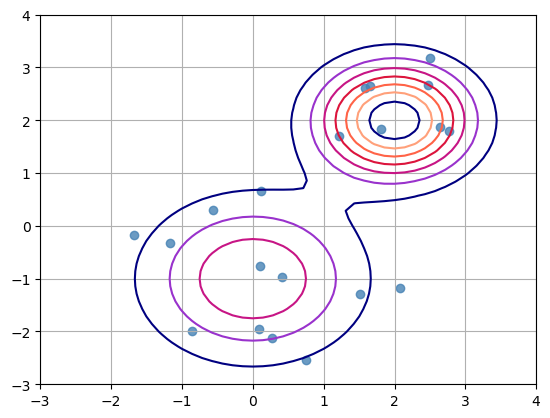

In [65]:
#Defining the model and sampling data points

mean_1_bi = torch.tensor([2.,2.])
var_1_bi = 0.5*torch.eye(2)
mean_2_bi = torch.tensor([0.,-1.])
var_2_bi = torch.eye(2)
w_bi = 0.5

samples_bi = Gaussian.SampleFromMixture([mean_1_bi,mean_2_bi], [var_1_bi,var_2_bi], torch.tensor([.5,.5]), 20)

x = y = np.linspace(-3,4)
X_, Y_ = np.meshgrid(x, y)

Z_ = Mixture([X_, Y_], 0.5, [2.,2.], .5, [0.,-1.], 1., 2)

plt.contour(X_,Y_,Z_, colors=cmap1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
plt.scatter(samples_bi[:,0], samples_bi[:,1], c="steelblue", alpha=.8)
plt.grid(visible=True)

In [66]:
parameters_bi = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([1.]),
    "b": torch.tensor([100.]),
    "D": 2,
    "N": 20,
    "Epochs": 75,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

loc_bi = torch.tensor([0.,0.])
variance_param_bi = torch.tensor([100.])

q_global_bi = {
    "loc": torch.nn.Parameter(loc_bi),
    "var": torch.nn.Parameter(variance_param_bi),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_bi = []
for i in range(parameters["N"]):
    clients_bi.append({
        "client_idx": i,
        "x_n": samples_bi[i].unsqueeze(0),
        "mean": torch.tensor([0., 0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([0.5]),
        "noise_m": mean_2_bi,
        "noise_v": parameters["a"],
        "spherical": True,
        "require_s_n": False
    })

In [67]:
q_new_bi, clients_new_bi = PartitionedVariationalInference(q_global_bi, clients_bi, parameters_bi)

Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([0.0166, 0.0138], requires_grad=True) 
 var:  Parameter containing:
tensor([96.1970], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([-0.1055,  0.0871], requires_grad=True) 
 var:  Parameter containing:
tensor([92.5383], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([0.2117, 0.3070], requires_grad=True) 
 var:  Parameter containing:
tensor([89.2238], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([0.3151, 0.4335], requires_grad=True) 
 var:  Parameter containing:
tensor([86.1324], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([0.5037, 0.4384], requires_grad=True) 
 var:  Paramet

New global q: 
 loc:  Parameter containing:
tensor([2.0889, 2.3145], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0891], requires_grad=True)
Iteration 39:
New global q: 
 loc:  Parameter containing:
tensor([2.0846, 2.2996], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0587], requires_grad=True)
Iteration 40:
New global q: 
 loc:  Parameter containing:
tensor([2.0918, 2.2716], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0825], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([2.0862, 2.2872], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0617], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([2.0955, 2.2774], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0777], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([2.0712, 2.3030], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0665], requires_grad=

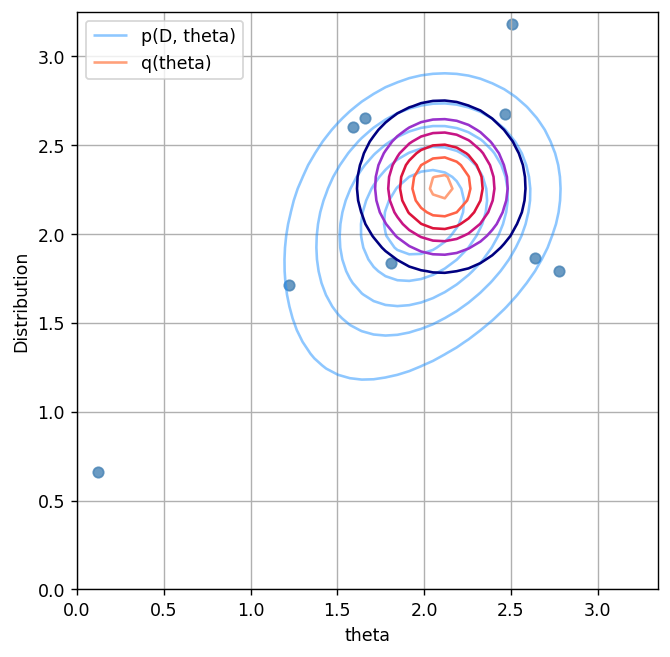

In [150]:
x = np.linspace(0.,3.35)
y = np.linspace(0.,3.25)
X_q, Y_q = np.meshgrid(x, y)

plt.figure(figsize=(6,6), dpi=125)
Z_pvi_bi = Normal(q_new_bi["loc"].detach().squeeze().numpy(), q_new_bi["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters["D"])

Z_true_h_bi = trueDistribution2D(parameters_bi, clients_new_bi, 0.,3.25)
#Z_q = Mixture([X_q, Y_q], 0.5, [2.,2.], .5, [0.,-1.], 1., 2)

c1 = plt.contour(X_q,Y_q,Z_true_h_bi, colors='dodgerblue', alpha=.5)
#c1 = plt.contour(X_q,Y_q,Z_q, colors=cmap1)

c2 = plt.contour(X_q,Y_q,Z_pvi_bi, colors = cmap1)

#plt.scatter(x_,y_,color="firebrick")
for sample in samples_bi:
    if sample[0] >= 0 and sample[1] >= 0:
        plt.scatter(sample[0], sample[1], c="steelblue", alpha=.8)

h1,_=c1.legend_elements()
h2,_=c2.legend_elements()
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend([h1[0],h2[0]], ["p(D, theta)", "q(theta)"], loc="upper left")
plt.grid(visible=True)

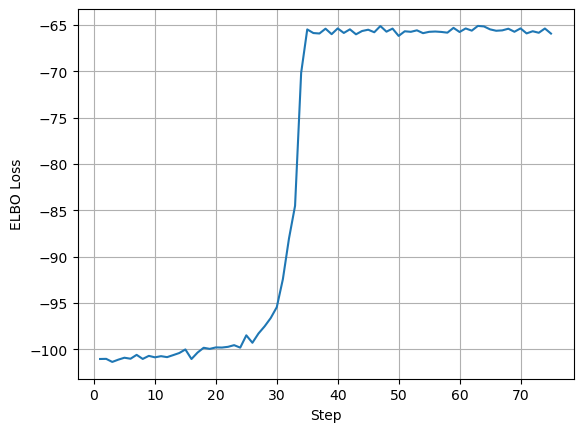

In [69]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_bi["Epochs"]):
    running_total = 0.
    for j in range((i* parameters_bi["N"]),((i+1)* parameters_bi["N"])):
         running_total += q_new_bi["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

### PVI on well specified normal model
#### One dimensional case

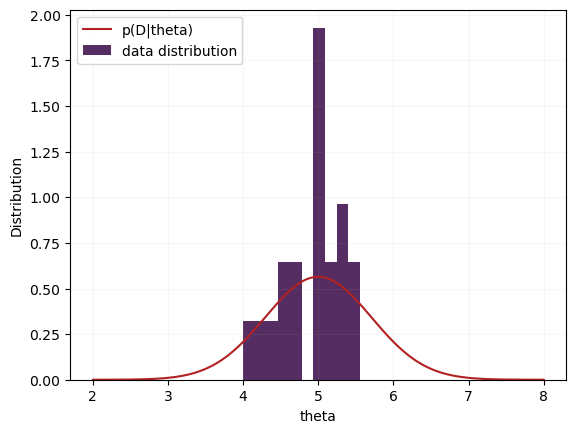

In [70]:
#Defining the model and sampling data points

mean_1_norm = torch.tensor([5.])
var_1_norm = torch.tensor([.5])
mean_2_norm = torch.tensor([5.])
var_2_norm = torch.tensor([.5])
w_uni = 0.

samples_norm = Gaussian.SampleFromMixture([mean_1_norm,mean_2_norm], [var_1_norm,var_2_norm], torch.tensor([.5,.5]), 20)
samples_normal = samples_norm.numpy()


x = np.linspace(2., 8., 1000)

plt.plot(x, Mix(x, 0., 5., .5, 5., .5), color="firebrick", label="p(D|theta)")
plt.hist(samples_normal, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

In [71]:
parameters_normal = {
    "w": torch.tensor(1e-100),
    "a": torch.tensor([.5]),
    "b": torch.tensor([100.]),
    "D": 1,
    "N": 20,
    "Epochs": 50,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

q_global_normal = {
    "loc": torch.nn.Parameter(torch.tensor([0.])),
    "var": torch.nn.Parameter(torch.tensor([100.])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_normal = []
for i in range(parameters_normal["N"]):
    clients_normal.append({
        "client_idx": i,
        "x_n": torch.tensor([[samples_normal[i][0]]]),
        "mean": torch.tensor([0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": var_1_norm,
        "noise_m": torch.tensor([5.]),
        "noise_v": parameters_normal["a"],
        "spherical": True,
        "require_s_n": False
    })

In [72]:
q_new_normal, clients_new_normal = PartitionedVariationalInference(q_global_normal, clients_normal, parameters_normal, is_1d=True)

Starting global q:  {'loc': Parameter containing:
tensor([0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([0.2203], requires_grad=True) 
 var:  Parameter containing:
tensor([94.6284], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([0.1219], requires_grad=True) 
 var:  Parameter containing:
tensor([89.2970], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([-0.1773], requires_grad=True) 
 var:  Parameter containing:
tensor([83.9590], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([0.2063], requires_grad=True) 
 var:  Parameter containing:
tensor([78.5646], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([0.0999], requires_grad=True) 
 var:  Parameter containing:
tensor([73.0587], requires_gra

New global q: 
 loc:  Parameter containing:
tensor([4.9140], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1072], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([4.8943], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1036], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([4.9438], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1434], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([4.9208], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0992], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([4.9291], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1283], requires_grad=True)
Iteration 45:
New global q: 
 loc:  Parameter containing:
tensor([4.9307], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1095], requires_grad=True)
Iteration 46:
New global q: 
 loc:  Parame

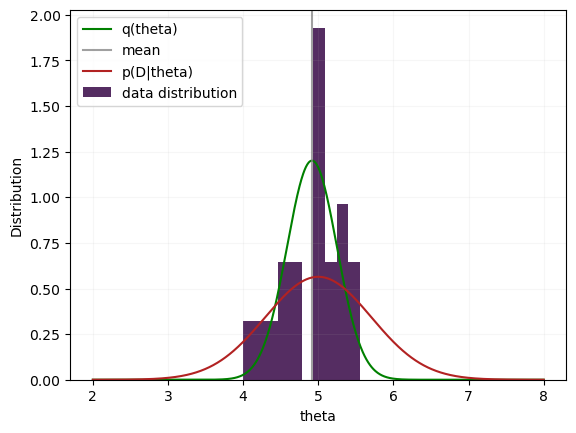

In [73]:
x = np.linspace(2, 8, 1000)


plt.plot(x, Normal(q_new_normal["loc"].detach().squeeze().numpy(), q_new_normal["var"].detach().squeeze().numpy(), x, 1),
         label="q(theta)", color='green')
plt.axvline(q_new_normal["loc"].detach().squeeze().numpy(), color ="grey", label = "mean", alpha=.75)
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, 0.5, 5., .5, 5., .5), color="firebrick", label="p(D|theta)")
plt.hist(samples_normal, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

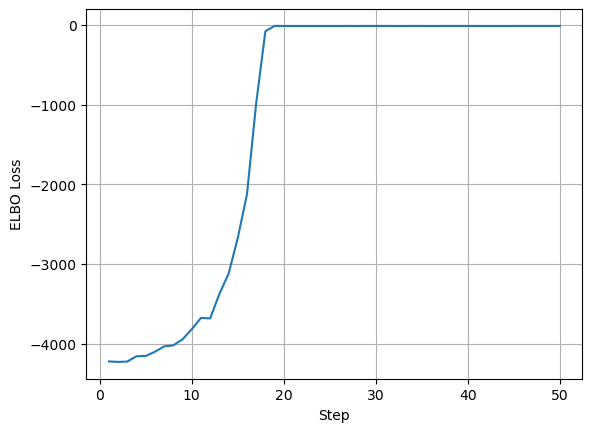

In [74]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_normal["Epochs"]):
    running_total = 0.
    for j in range((i* parameters_normal["N"]),((i+1)* parameters_normal["N"])):
         running_total += q_new_normal["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

#### Two Dimensional Case Well specified

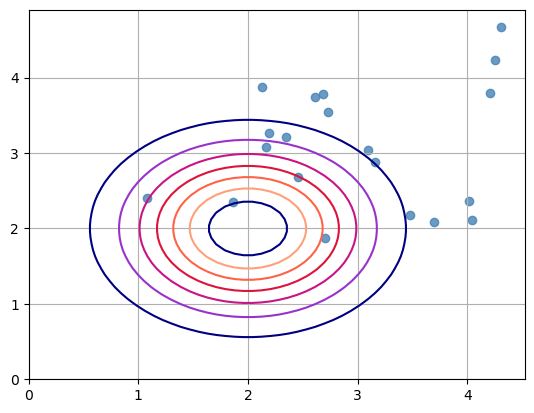

In [75]:
#Defining the model and sampling data points

mean_1_n = torch.tensor([3.,3.])
var_1_n = torch.eye(2)
mean_2_n = torch.tensor([0.,-1.])
var_2_n = torch.eye(2)
w_n = 0.

samples_n = Gaussian.SampleFromMixture([mean_1_n,mean_2_n], [var_1_n,var_2_n], torch.tensor([1.,0.]), 20)


x = y = np.linspace(0,4)
X_, Y_ = np.meshgrid(x, y)

Z_ = Mixture([X_, Y_], 0., [3.3.], 1., [0.,-1.], 1., 2)

plt.contour(X_,Y_,Z_, colors=cmap1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
plt.scatter(samples_n[:,0], samples_n[:,1], c="steelblue", alpha=.8)
plt.grid(visible=True)

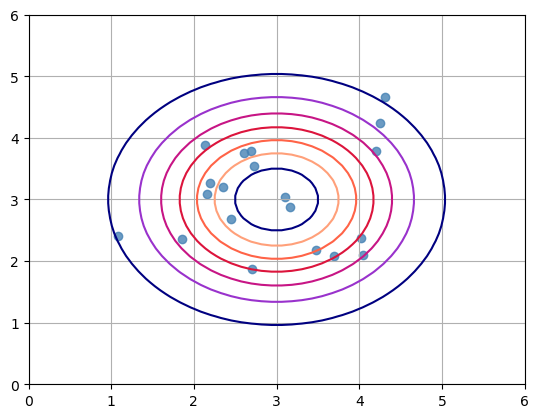

In [160]:
x = y = np.linspace(0,6)
X_, Y_ = np.meshgrid(x, y)

Z_ = Mixture([X_, Y_], 0., [3.,3.], 1., [0.,-1.], 1., 2)

plt.contour(X_,Y_,Z_, colors=cmap1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
plt.scatter(samples_n[:,0], samples_n[:,1], c="steelblue", alpha=.8)
plt.grid(visible=True)

In [76]:
parameters_n = {
    "w": torch.tensor(10e-81),
    "a": torch.tensor([1.]),
    "b": torch.tensor([100.]),
    "D": 2,
    "N": 20,
    "Epochs": 75,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

loc_n = torch.tensor([0.,0.])
variance_param_n = torch.tensor([100.])

q_global_n = {
    "loc": torch.nn.Parameter(loc_n),
    "var": torch.nn.Parameter(variance_param_n),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_n = []
for i in range(parameters_n["N"]):
    clients_n.append({
        "client_idx": i,
        "x_n": samples_n[i].unsqueeze(0),
        "mean": torch.tensor([0., 0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([1.]),
        "noise_m": mean_2_n,
        "noise_v": parameters_n["a"],
        "spherical": True,
        "require_s_n": False
    })

In [77]:
q_new_n, clients_new_n = PartitionedVariationalInference(q_global_n, clients_n, parameters_n)

Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([2.6345, 2.9576], requires_grad=True) 
 var:  Parameter containing:
tensor([94.0486], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([2.7209, 2.8913], requires_grad=True) 
 var:  Parameter containing:
tensor([88.0993], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([2.8178, 3.1015], requires_grad=True) 
 var:  Parameter containing:
tensor([82.1425], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([2.9516, 3.0319], requires_grad=True) 
 var:  Parameter containing:
tensor([76.2179], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([2.9601, 3.1708], requires_grad=True) 
 var:  Parameter

New global q: 
 loc:  Parameter containing:
tensor([2.9708, 3.0555], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0575], requires_grad=True)
Iteration 40:
New global q: 
 loc:  Parameter containing:
tensor([2.9451, 3.0772], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0603], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([2.9627, 3.0462], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0526], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([2.9677, 3.0653], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0504], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([2.9549, 3.0500], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0551], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([2.9546, 3.0427], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0557], requires_grad=

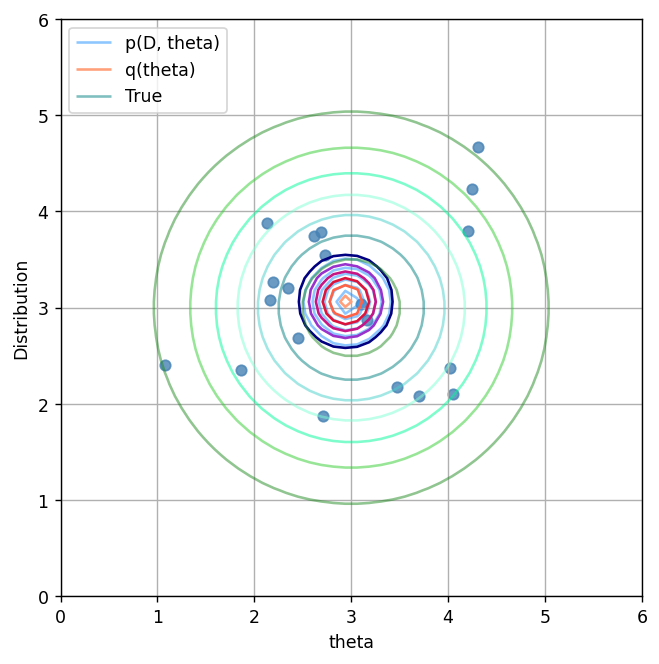

In [161]:
x = np.linspace(0,6)
y = np.linspace(0,6)
X_q, Y_q = np.meshgrid(x, y)

plt.figure(figsize=(6,6), dpi=125)
Z_pvi_n = Normal(q_new_n["loc"].detach().squeeze().numpy(), q_new_n["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters_n["D"])

Z_true_h_n = trueDistribution2D(parameters_n, clients_new_n, 0,6)
#Z_q = Mixture([X_q, Y_q], 0.5, [2.,2.], .5, [0.,-1.], 1., 2)

c1 = plt.contour(X_q,Y_q,Z_true_h_n, colors='dodgerblue', alpha=.5)
#c1 = plt.contour(X_q,Y_q,Z_q, colors=cmap1)

c2 = plt.contour(X_q,Y_q,Z_pvi_n, colors = cmap1)
c3 = plt.contour(X_,Y_,Z_, colors=cmap2, alpha=.5)
#plt.scatter(x_,y_,color="firebrick")

plt.scatter(samples_n[:,0], samples_n[:,1], c="steelblue", alpha=.8)

h1,_=c1.legend_elements()
h2,_=c2.legend_elements()
h3,_=c3.legend_elements()
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend([h1[0],h2[0], h3[0]], ["p(D, theta)", "q(theta)", "True"], loc="upper left")
plt.grid(visible=True)

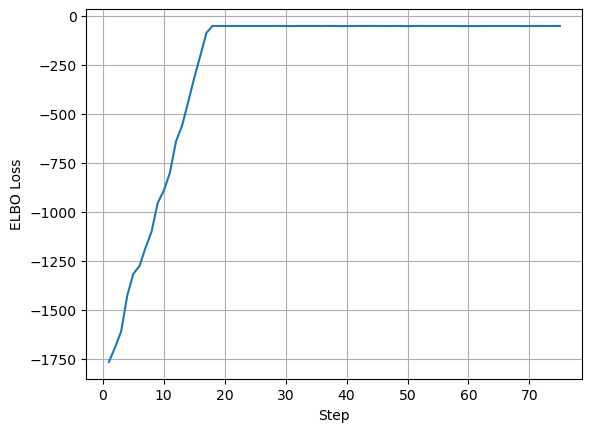

In [79]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_n["Epochs"]):
    running_total = 0.
    for j in range((i* parameters_n["N"]),((i+1)* parameters_n["N"])):
         running_total += q_new_n["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

### Consider larger amounts of data points per client, i.e. $>1$

#### Let's start through best performing model, bimodal 1-D

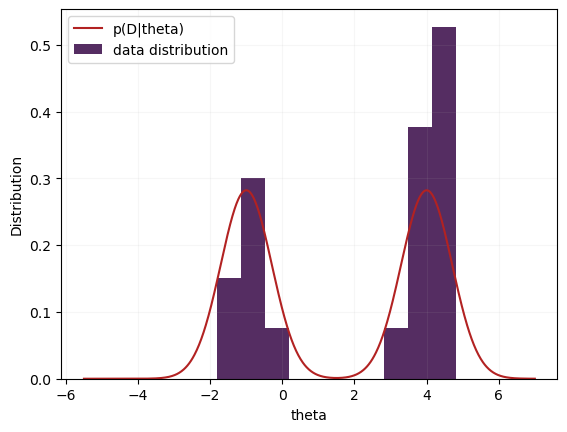

In [80]:
#Defining the model and sampling data points

mean_1_uni5 = torch.tensor([4.])
var_1_uni5 = torch.tensor([.5])
mean_2_uni5 = torch.tensor([-1.])
var_2_uni5 = torch.tensor([.5])
w_uni = 0.5

samples_uni5 = Gaussian.SampleFromMixture([mean_1_uni5,mean_2_uni5], [var_1_uni5,var_2_uni5], torch.tensor([.5,.5]), 20)
samp5 = homogeneous_split(samples_uni5, 4, 86231009)

x = np.linspace(-5.5, 7, 1000)

plt.plot(x, Mix(x, 0.5, 4., .5, -1., .5), color="firebrick", label="p(D|theta)")
plt.hist(samples_uni5.numpy(), density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

In [81]:
parameters_uni5 = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([.5]),
    "b": torch.tensor([100.]),
    "D": 1,
    "N": 20,
    "Epochs": 120,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

q_global_uni5 = {
    "loc": torch.nn.Parameter(torch.tensor([0.])),
    "var": torch.nn.Parameter(parameters_uni5["b"]),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_uni5 = []
for i in range(4):
    clients_uni5.append({
        "client_idx": i,
        "x_n": samp5[i],
        "mean": torch.tensor([0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": var_1_uni5,
        "noise_m": torch.tensor([-1.]),
        "noise_v": parameters_uni5["a"],
        "spherical": True,
        "require_s_n": False
    })

In [82]:
q_new_uni5, _ = PartitionedVariationalInference(q_global_uni5, clients_uni5, parameters_uni5, is_1d=True)

Starting global q:  {'loc': Parameter containing:
tensor([0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([-0.1425], requires_grad=True) 
 var:  Parameter containing:
tensor([99.2110], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([-0.3882], requires_grad=True) 
 var:  Parameter containing:
tensor([98.3851], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([-0.3783], requires_grad=True) 
 var:  Parameter containing:
tensor([97.5992], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([-0.4517], requires_grad=True) 
 var:  Parameter containing:
tensor([96.7849], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([-0.2414], requires_grad=True) 
 var:  Parameter containing:
tensor([95.9098], requires

New global q: 
 loc:  Parameter containing:
tensor([-0.1209], requires_grad=True) 
 var:  Parameter containing:
tensor([67.7957], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([-0.0644], requires_grad=True) 
 var:  Parameter containing:
tensor([66.9080], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([-0.1632], requires_grad=True) 
 var:  Parameter containing:
tensor([66.0037], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([-0.1671], requires_grad=True) 
 var:  Parameter containing:
tensor([65.1291], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([-0.1743], requires_grad=True) 
 var:  Parameter containing:
tensor([64.3038], requires_grad=True)
Iteration 45:
New global q: 
 loc:  Parameter containing:
tensor([-0.3056], requires_grad=True) 
 var:  Parameter containing:
tensor([63.3913], requires_grad=True)
Iteration 46:
New global q: 
 

New global q: 
 loc:  Parameter containing:
tensor([0.4536], requires_grad=True) 
 var:  Parameter containing:
tensor([30.2902], requires_grad=True)
Iteration 81:
New global q: 
 loc:  Parameter containing:
tensor([0.6907], requires_grad=True) 
 var:  Parameter containing:
tensor([29.2577], requires_grad=True)
Iteration 82:
New global q: 
 loc:  Parameter containing:
tensor([0.7740], requires_grad=True) 
 var:  Parameter containing:
tensor([28.1764], requires_grad=True)
Iteration 83:
New global q: 
 loc:  Parameter containing:
tensor([0.9083], requires_grad=True) 
 var:  Parameter containing:
tensor([27.1041], requires_grad=True)
Iteration 84:
New global q: 
 loc:  Parameter containing:
tensor([0.9822], requires_grad=True) 
 var:  Parameter containing:
tensor([26.0252], requires_grad=True)
Iteration 85:
New global q: 
 loc:  Parameter containing:
tensor([1.0541], requires_grad=True) 
 var:  Parameter containing:
tensor([24.9550], requires_grad=True)
Iteration 86:
New global q: 
 loc:  

New global q: 
 loc:  Parameter containing:
tensor([4.1461], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1304], requires_grad=True)


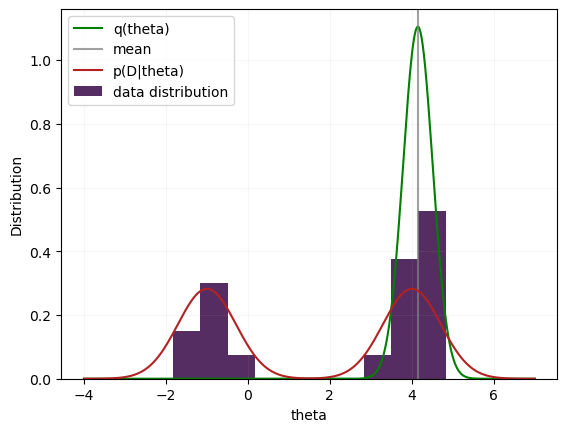

In [83]:
x = np.linspace(-4, 7, 1000)

plt.plot(x, Normal(q_new_uni5["loc"].detach().squeeze().numpy(), q_new_uni5["var"].detach().squeeze().numpy(), x, 1),
         label="q(theta)", color='green')
plt.axvline(q_new_uni5["loc"].detach().squeeze().numpy(), color ="grey", label = "mean", alpha=.75)
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, 0.5, 4., .5, -1., .5), color="firebrick", label="p(D|theta)")
plt.hist(samples_uni5.numpy(), density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

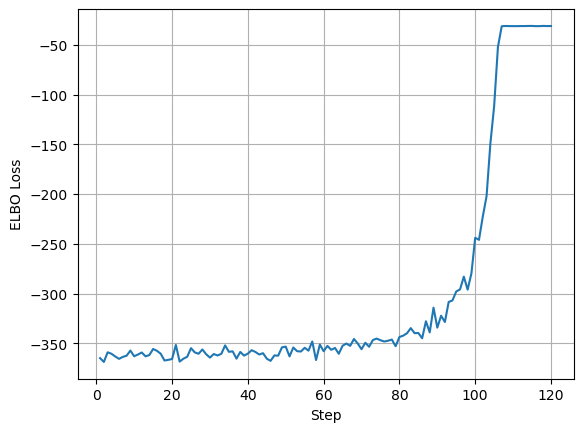

In [84]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_uni5["Epochs"]):
    running_total = 0.
    for j in range((i* 4),((i+1)* 4)):
         running_total += q_new_uni5["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

#### Problematic 2-D case

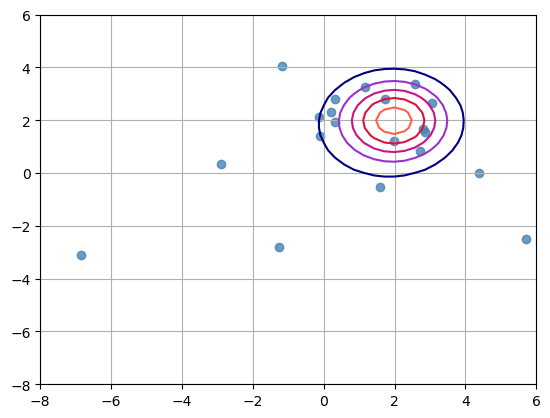

In [85]:
#Defining the model and sampling data points

m1 = torch.tensor([2.,2.])
m2 = torch.zeros(2)
c1 = torch.eye(2)
c2 = 10*c1
clients_num = 4


samples_1 = Gaussian.SampleFromMixture([m1,m2], [c1,c2], torch.tensor([0.5,0.5]), 20)

data_1 = homogeneous_split(samples_1, clients_num, seed=86231009)

x = y = np.linspace(-8,6)
X_, Y_ = np.meshgrid(x, y)

Z_ = Mixture([X_, Y_], 0.5, [2.,2.], 1., [0.,0.], 10., 2)

plt.contour(X_,Y_,Z_, colors=cmap1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
plt.scatter(samples_1[:,0], samples_1[:,1], c="steelblue", alpha=.8)
plt.grid(visible=True)

In [86]:
parameters_1 = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([10.]),
    "b": torch.tensor([100.]),
    "D": 2,
    "N": 20,
    "Epochs": 100,
    "Divergence": "KLD",
    "lr": .1,
    "samples": 50,
    "optim_epochs": 50
}

loc_1 = torch.tensor([0.,0.])
variance_param_1 = torch.tensor([100.])

q_global_1 = {
    "loc": torch.nn.Parameter(loc_1),
    "var": torch.nn.Parameter(variance_param_1),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_1 = []
for i in range(4):
    clients_1.append({
        "client_idx": i,
        "x_n": data_1[i],
        "mean": torch.tensor([0., 0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([1.]),
        "noise_m": torch.tensor([0., 0.]),
        "noise_v": parameters_1["a"],
        "spherical": True,
        "require_s_n": False
    })

In [87]:
q_new_1, clients_new_1 = PartitionedVariationalInference(q_global_1, clients_1, parameters_1)

Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([-0.7536, -0.1461], requires_grad=True) 
 var:  Parameter containing:
tensor([82.5332], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([ 2.1380, -0.0815], requires_grad=True) 
 var:  Parameter containing:
tensor([65.2507], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([0.8431, 0.7558], requires_grad=True) 
 var:  Parameter containing:
tensor([47.2282], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([1.0989, 1.2349], requires_grad=True) 
 var:  Parameter containing:
tensor([29.2483], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([2.4813, 1.0780], requires_grad=True) 
 var:  Param

New global q: 
 loc:  Parameter containing:
tensor([1.5312, 2.0659], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1333], requires_grad=True)
Iteration 40:
New global q: 
 loc:  Parameter containing:
tensor([1.5772, 2.1410], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1369], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([1.5596, 2.1453], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1422], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([1.5599, 2.1123], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1576], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([1.5427, 2.1671], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1581], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([1.5972, 2.1232], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1442], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.5049, 2.1252], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1485], requires_grad=True)
Iteration 79:
New global q: 
 loc:  Parameter containing:
tensor([1.5639, 2.1137], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1202], requires_grad=True)
Iteration 80:
New global q: 
 loc:  Parameter containing:
tensor([1.4994, 2.1207], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1441], requires_grad=True)
Iteration 81:
New global q: 
 loc:  Parameter containing:
tensor([1.5443, 2.1586], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1054], requires_grad=True)
Iteration 82:
New global q: 
 loc:  Parameter containing:
tensor([1.5483, 2.1536], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1615], requires_grad=True)
Iteration 83:
New global q: 
 loc:  Parameter containing:
tensor([1.5479, 2.0675], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1695], requires_grad=

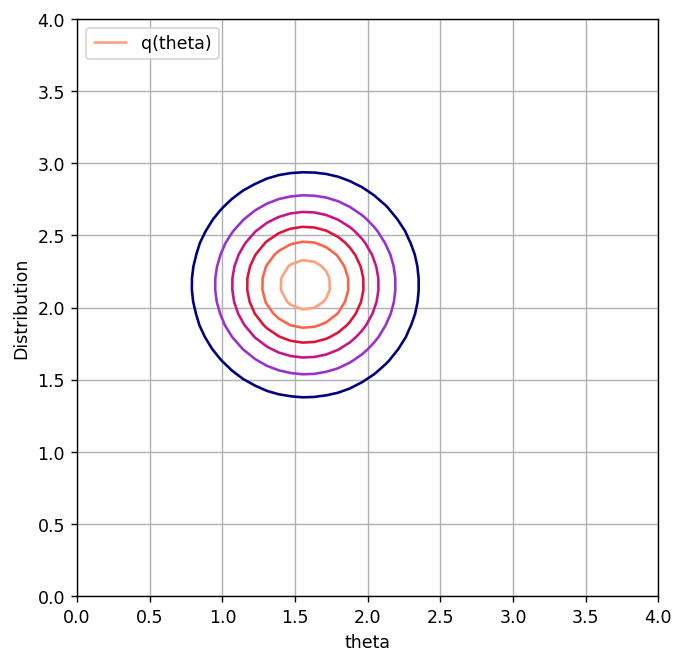

In [167]:
x = np.linspace(0,4)
y = np.linspace(0,4)
X_q, Y_q = np.meshgrid(x, y)
plt.figure(figsize=(6,6), dpi=125)
Z_pvi = Normal(q_new_1["loc"].detach().squeeze().numpy(), q_new_1["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters_1["D"])

#Z_true_h = trueDistribution2D(parameters_1, clients_new_1, 0,5)

#c1 = plt.contour(X_q,Y_q,Z_true_h, colors='dodgerblue', alpha=.5)

c2 = plt.contour(X_q,Y_q,Z_pvi, colors = cmap1)

#plt.scatter(x_,y_,color="firebrick")
#h1,_=c1.legend_elements()
h2,_=c2.legend_elements()
plt.xlabel("theta")
plt.ylabel("Distribution")
#plt.legend([h1[0],h2[0]], ["p(D, theta)", "q(theta)"], loc="upper left")
plt.legend([h2[0]], ["q(theta)"], loc="upper left")
plt.grid(visible=True)
#plt.savefig("Erroneous_PVI_posterior.png")

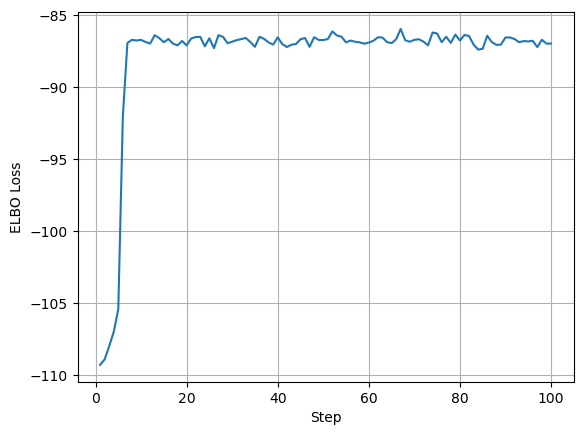

In [89]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_1["Epochs"]):
    running_total = 0.
    for j in range((i* 4),((i+1)* 4)):
         running_total += q_new_1["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

### Reducing PVI to VI with only one client

In [90]:
#Set up 1D case as in perious section
parameters_vi = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([.5]),
    "b": torch.tensor([100.]),
    "D": 2,
    "N": 20,
    "Epochs": 100,
    "Divergence": "KLD",
    "lr": 0.05,
    "samples": 50,
    "optim_epochs": 30
}

loc_vi = torch.tensor([0.])
variance_param_vi = torch.tensor([100.])

q_global_vi = {
    "loc": torch.nn.Parameter(loc_vi),
    "var": torch.nn.Parameter(variance_param_vi),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_vi = []

clients_vi.append({
    "client_idx": 0,
    "x_n": samples_uni5,
    "mean": torch.tensor([0.]),
    "variance": torch.tensor([np.inf]),
    "variance_inverse": torch.tensor([0.]),
    "normaliser": torch.tensor(1.),
    "iteration": 0,
    "true_v": var_1_uni5,
    "noise_m": torch.tensor([-1.]),
    "noise_v": parameters_vi["a"],
    "spherical": True,
    "require_s_n": False
})

In [91]:
q_new_vi , _ = PartitionedVariationalInference(q_global_vi, clients_vi, parameters_vi, is_1d=True)

Starting global q:  {'loc': Parameter containing:
tensor([0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([-0.3284], requires_grad=True) 
 var:  Parameter containing:
tensor([99.0424], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([-0.0790], requires_grad=True) 
 var:  Parameter containing:
tensor([98.1113], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([-0.3223], requires_grad=True) 
 var:  Parameter containing:
tensor([97.2167], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([-0.4594], requires_grad=True) 
 var:  Parameter containing:
tensor([96.3436], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([-0.4563], requires_grad=True) 
 var:  Parameter containing:
tensor([95.4816], requires

New global q: 
 loc:  Parameter containing:
tensor([-0.4409], requires_grad=True) 
 var:  Parameter containing:
tensor([58.2714], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([-0.2899], requires_grad=True) 
 var:  Parameter containing:
tensor([57.1700], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([-0.2035], requires_grad=True) 
 var:  Parameter containing:
tensor([55.9933], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([0.2971], requires_grad=True) 
 var:  Parameter containing:
tensor([54.8014], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([0.5016], requires_grad=True) 
 var:  Parameter containing:
tensor([53.5472], requires_grad=True)
Iteration 45:
New global q: 
 loc:  Parameter containing:
tensor([0.4085], requires_grad=True) 
 var:  Parameter containing:
tensor([52.2902], requires_grad=True)
Iteration 46:
New global q: 
 loc

New global q: 
 loc:  Parameter containing:
tensor([3.3782], requires_grad=True) 
 var:  Parameter containing:
tensor([5.3616], requires_grad=True)
Iteration 81:
New global q: 
 loc:  Parameter containing:
tensor([3.8824], requires_grad=True) 
 var:  Parameter containing:
tensor([3.8312], requires_grad=True)
Iteration 82:
New global q: 
 loc:  Parameter containing:
tensor([4.1914], requires_grad=True) 
 var:  Parameter containing:
tensor([2.3277], requires_grad=True)
Iteration 83:
New global q: 
 loc:  Parameter containing:
tensor([4.0612], requires_grad=True) 
 var:  Parameter containing:
tensor([0.9139], requires_grad=True)
Iteration 84:
New global q: 
 loc:  Parameter containing:
tensor([4.1555], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1568], requires_grad=True)
Iteration 85:
New global q: 
 loc:  Parameter containing:
tensor([4.1618], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1794], requires_grad=True)
Iteration 86:
New global q: 
 loc:  Parame

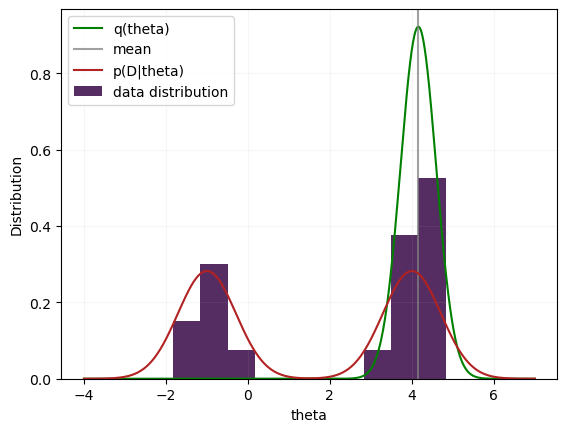

In [92]:
x = np.linspace(-4, 7, 1000)

plt.plot(x, Normal(q_new_vi["loc"].detach().squeeze().numpy(), q_new_vi["var"].detach().squeeze().numpy(), x, 1),
         label="q(theta)", color='green')
plt.axvline(q_new_vi["loc"].detach().squeeze().numpy(), color ="grey", label = "mean", alpha=.75)
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, 0.5, 4., .5, -1., .5), color="firebrick", label="p(D|theta)")
plt.hist(samples_uni5.numpy(), density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

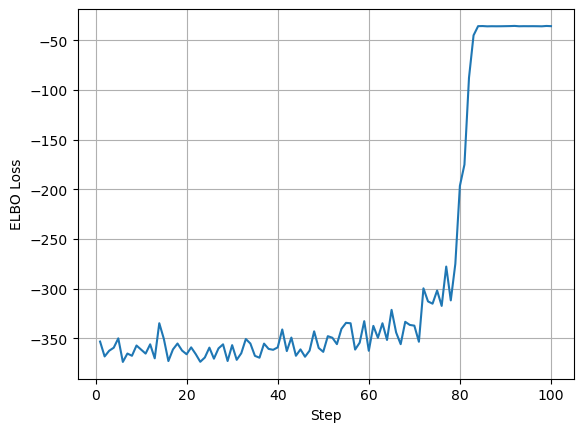

In [93]:
plot_training(q_new_vi["metrics"]["elbos"])

### VI for the 2D case from the beginning

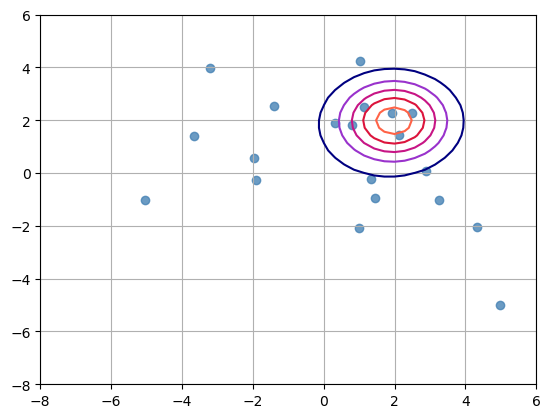

In [146]:
#Defining the model and sampling data points

a = x_
b = y_
num_shards = 5
l = []
for i in range(len(a)):
    l.append([a[i], b[i]])

li = torch.tensor(l)

x = y = np.linspace(-8,6)
X_, Y_ = np.meshgrid(x, y)

Z_ = Mixture([X_, Y_], 0.5, [2.,2.], 1., [0.,0.], 10., 2)

plt.contour(X_,Y_,Z_, colors=cmap1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
plt.scatter(a, b, c="steelblue", alpha=.8)
plt.grid(visible=True)

In [147]:
parameters_vi2 = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([10.]),
    "b": torch.tensor([100.]),
    "D": 2,
    "N": 20,
    "Epochs": 100,
    "Divergence": "KLD",
    "lr": 0.1,
    "samples": 50,
    "optim_epochs": 30
}

loc_vi2 = torch.tensor([0.,0.])
variance_param_vi2 = torch.tensor([100.])

q_global_vi2 = {
    "loc": torch.nn.Parameter(loc_vi2),
    "var": torch.nn.Parameter(variance_param_vi2),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_vi2 = []

clients_vi2.append({
    "client_idx": 0,
    "x_n": li,
    "mean": torch.tensor([0., 0.]),
    "variance": torch.tensor([np.inf]),
    "variance_inverse": torch.tensor([0.]),
    "normaliser": torch.tensor(1.),
    "iteration": 0,
    "true_v": torch.tensor([1.]),
    "noise_m": torch.tensor([0.,0.]),
    "noise_v": parameters_vi2["a"],
    "spherical": True,
    "require_s_n": False
})

In [148]:
q_new_vi2 , client_new_vi2 = PartitionedVariationalInference(q_global_vi2, clients_vi2, parameters_vi2)

Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([-0.0679,  0.0820], requires_grad=True) 
 var:  Parameter containing:
tensor([97.1537], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([0.0759, 0.1488], requires_grad=True) 
 var:  Parameter containing:
tensor([94.2728], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([-0.8388,  1.0082], requires_grad=True) 
 var:  Parameter containing:
tensor([91.3461], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([-0.3640,  0.4128], requires_grad=True) 
 var:  Parameter containing:
tensor([88.4678], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([-0.2092, -0.1316], requires_grad=True) 
 var:  P

New global q: 
 loc:  Parameter containing:
tensor([1.5438, 1.6754], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2931], requires_grad=True)
Iteration 39:
New global q: 
 loc:  Parameter containing:
tensor([1.4817, 1.6299], requires_grad=True) 
 var:  Parameter containing:
tensor([0.3595], requires_grad=True)
Iteration 40:
New global q: 
 loc:  Parameter containing:
tensor([1.4883, 1.5897], requires_grad=True) 
 var:  Parameter containing:
tensor([0.3535], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([1.4992, 1.5943], requires_grad=True) 
 var:  Parameter containing:
tensor([0.3214], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([1.5410, 1.7393], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2998], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([1.5213, 1.6305], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1998], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.4851, 1.6146], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2690], requires_grad=True)
Iteration 78:
New global q: 
 loc:  Parameter containing:
tensor([1.3602, 1.6320], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2680], requires_grad=True)
Iteration 79:
New global q: 
 loc:  Parameter containing:
tensor([1.3977, 1.5183], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2747], requires_grad=True)
Iteration 80:
New global q: 
 loc:  Parameter containing:
tensor([1.4845, 1.6575], requires_grad=True) 
 var:  Parameter containing:
tensor([0.3588], requires_grad=True)
Iteration 81:
New global q: 
 loc:  Parameter containing:
tensor([1.4688, 1.6209], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2711], requires_grad=True)
Iteration 82:
New global q: 
 loc:  Parameter containing:
tensor([1.4882, 1.6431], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2641], requires_grad=

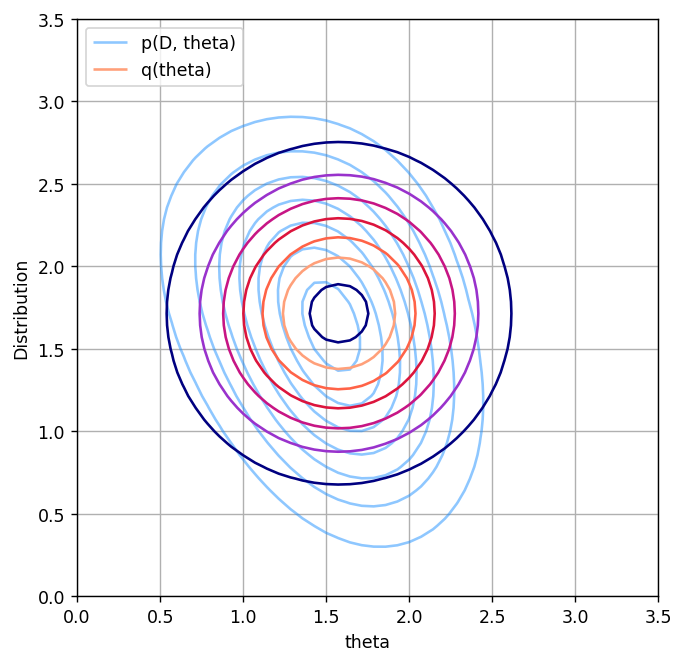

In [153]:
x = np.linspace(0,3.5)
y = np.linspace(0,3.5)
X_q, Y_q = np.meshgrid(x, y)
plt.figure(figsize=(6,6), dpi=125)
Z_vi = Normal(q_new_vi2["loc"].detach().squeeze().numpy(), q_new_vi2["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters_vi2["D"])

#Z_true_h = trueDistribution2D(parameters_vi2, clients_new_1, 0,5)

c1 = plt.contour(X_q,Y_q,Z_true_h, colors='dodgerblue', alpha=.5)

c2 = plt.contour(X_q,Y_q,Z_vi, colors = cmap1)

#plt.scatter(x_,y_,color="firebrick")
#h1,_=c1.legend_elements()
h2,_=c2.legend_elements()
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend([h1[0],h2[0]], ["p(D, theta)", "q(theta)"], loc="upper left")
#plt.legend([h2[0]], ["q(theta)"], loc="upper left")
plt.grid(visible=True)
#plt.savefig("Erroneous_PVI_posterior.png")

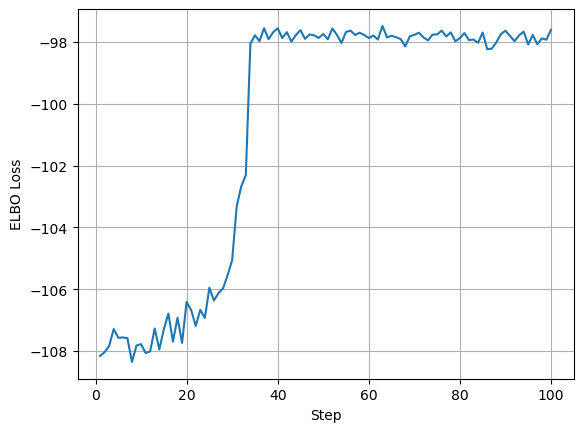

In [154]:
plot_training(q_new_vi2["metrics"]["elbos"])

### Higher than 2 Dimensions

Text(0.5, 0, 'z')

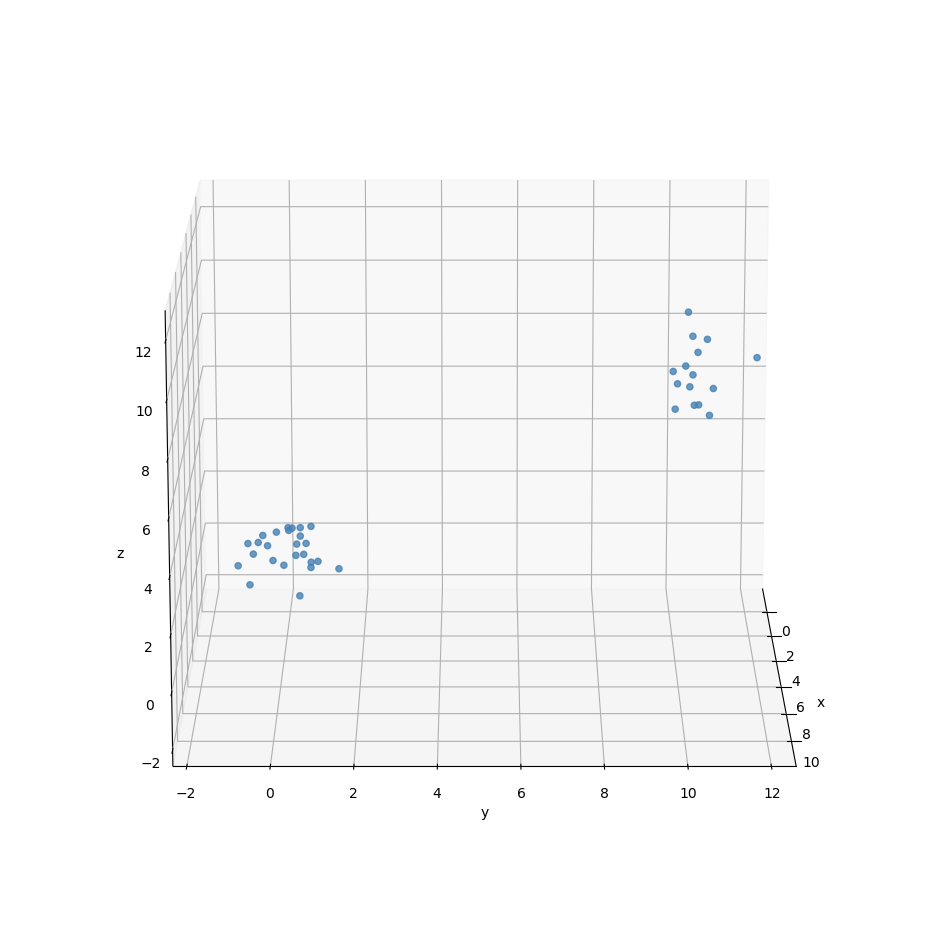

In [99]:
#Defining the model and sampling data points

mean_1_tri = torch.tensor([10.,10, 10.])
var_1_tri = 0.5*torch.eye(3)
mean_2_tri = torch.tensor([0.,0.,0.])
var_2_tri = 0.5*torch.eye(3)
w_bi = 0.5

samples_tri = Gaussian.SampleFromMixture([mean_1_tri,mean_2_tri], [var_1_tri,var_2_tri], torch.tensor([.5,.5]), 40)

elev=15
azim=0
roll=0
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

#Changing the angle we view the scatter plot
ax.view_init(elev, azim, roll)


#We plot the points in M as a scatter plot according to their class
ax.scatter(samples_tri[:,0], samples_tri[:,1], samples_tri[:,2], color="steelblue", alpha=.8)
#Uncomment to visualise the origin in 3 dimensions
#ax.scatter(0.,0.,0., color='lime', alpha=1)

#Defining labels and legends
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.legend(loc="upper left", scatterpoints=1, numpoints=1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)


In [101]:
parameters_tri = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([.5]),
    "b": torch.tensor([100.]),
    "D": 3,
    "N": 40,
    "Epochs": 75,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

loc_tri = torch.tensor([0.,0., 0.])
variance_param_tri = torch.tensor([100.])

q_global_tri = {
    "loc": torch.nn.Parameter(loc_tri),
    "var": torch.nn.Parameter(variance_param_tri),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_tri = []
for i in range(parameters_tri["N"]):
    clients_tri.append({
        "client_idx": i,
        "x_n": samples_tri[i].unsqueeze(0),
        "mean": torch.tensor([0., 0., 0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([.5]),
        "noise_m": mean_2_tri,
        "noise_v": parameters_tri["a"],
        "spherical": True,
        "require_s_n": False
    })

In [102]:
q_new_tri, clients_new_tri = PartitionedVariationalInference(q_global_tri, clients_tri, parameters_tri)

Starting global q:  {'loc': Parameter containing:
tensor([0., 0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([4.0727, 4.1109, 3.6357], requires_grad=True) 
 var:  Parameter containing:
tensor([95.4586], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([8.0169, 7.9756, 7.9498], requires_grad=True) 
 var:  Parameter containing:
tensor([90.8434], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([9.1514, 9.7124, 9.4116], requires_grad=True) 
 var:  Parameter containing:
tensor([86.7409], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([ 9.9074, 10.2375,  9.8386], requires_grad=True) 
 var:  Parameter containing:
tensor([82.2667], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([ 9.8262, 10.300

New global q: 
 loc:  Parameter containing:
tensor([ 9.7972, 10.1752, 10.1615], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0490], requires_grad=True)
Iteration 38:
New global q: 
 loc:  Parameter containing:
tensor([ 9.7778, 10.2020, 10.1453], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0472], requires_grad=True)
Iteration 39:
New global q: 
 loc:  Parameter containing:
tensor([ 9.8111, 10.1989, 10.1878], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0440], requires_grad=True)
Iteration 40:
New global q: 
 loc:  Parameter containing:
tensor([ 9.7829, 10.2005, 10.1557], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0629], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([ 9.8138, 10.1989, 10.1739], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0480], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([ 9.7895, 10.1989, 10.1608], requires_grad=T

New global q: 
 loc:  Parameter containing:
tensor([ 9.8249, 10.1985, 10.1816], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0518], requires_grad=True)
Iteration 75:
New global q: 
 loc:  Parameter containing:
tensor([ 9.7898, 10.2030, 10.1556], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0510], requires_grad=True)


Text(0.5, 0, 'z')

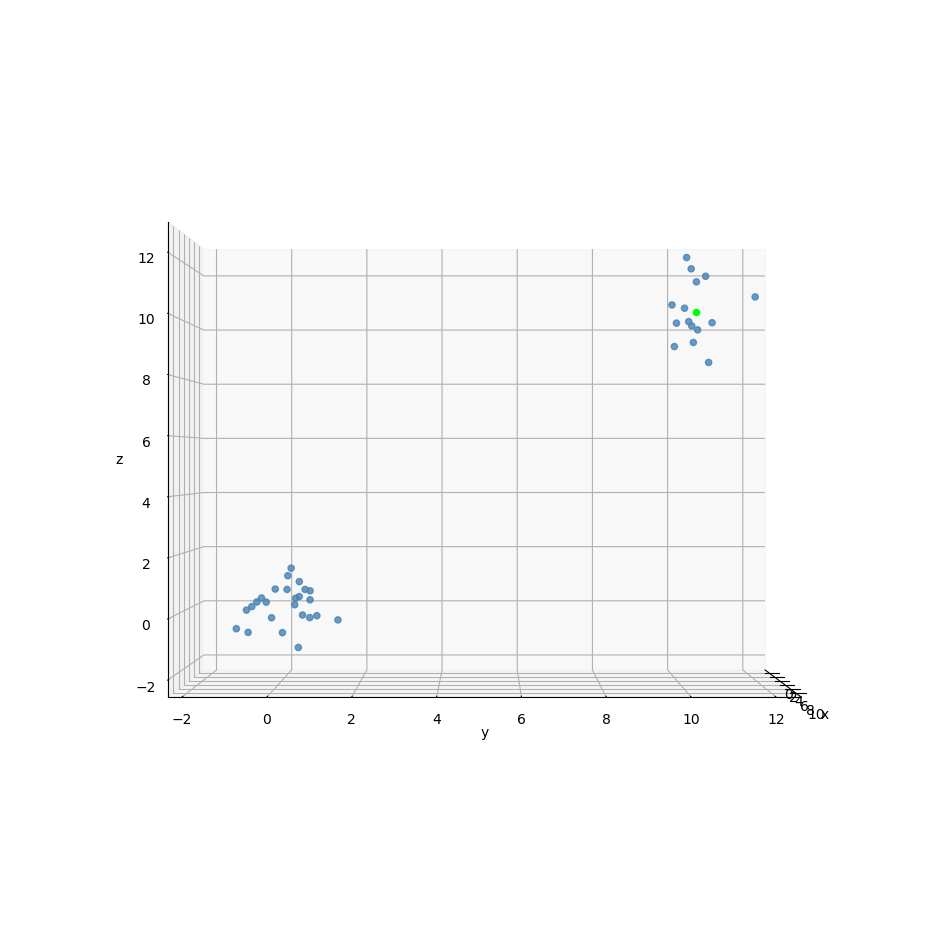

In [103]:
elev=0
azim=0
roll=0
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

#Changing the angle we view the scatter plot
ax.view_init(elev, azim, roll)


#We plot the points in M as a scatter plot according to their class
ax.scatter(samples_tri[:,0], samples_tri[:,1], samples_tri[:,2], color="steelblue", alpha=.8)
ax.scatter(q_new_tri["loc"].detach()[0],q_new_tri["loc"].detach()[1],q_new_tri["loc"].detach()[2], color='lime', alpha=1)


#Defining labels and legends
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.legend(loc="upper left", scatterpoints=1, numpoints=1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)


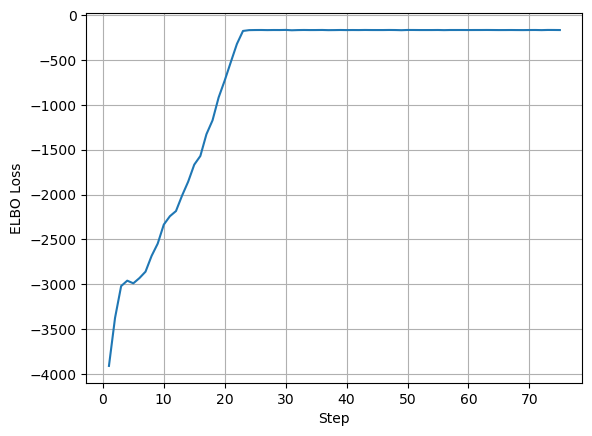

In [104]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_tri["Epochs"]):
    running_total = 0.
    for j in range((i* parameters_tri["N"]),((i+1)* parameters_tri["N"])):
         running_total += q_new_tri["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

Closer together

Text(0.5, 0, 'z')

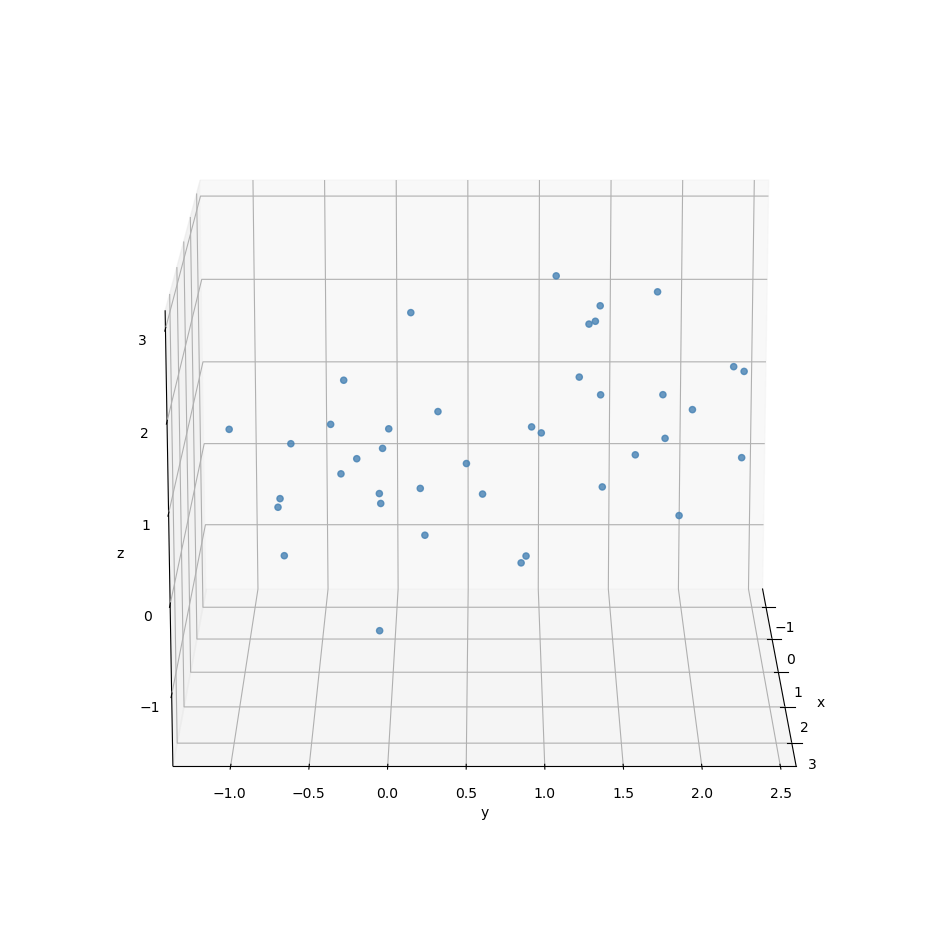

In [105]:
#Defining the model and sampling data points

mean_1_tri = torch.tensor([1.5,1.5, 1.5])
var_1_tri = 0.5*torch.eye(3)
mean_2_tri = torch.tensor([0.,0.,0.])
var_2_tri = 0.5*torch.eye(3)
w_bi = 0.5

samples_tri2 = Gaussian.SampleFromMixture([mean_1_tri,mean_2_tri], [var_1_tri,var_2_tri], torch.tensor([.5,.5]), 40)

elev=15
azim=0
roll=0
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

#Changing the angle we view the scatter plot
ax.view_init(elev, azim, roll)


#We plot the points in M as a scatter plot according to their class
ax.scatter(samples_tri2[:,0], samples_tri2[:,1], samples_tri2[:,2], color="steelblue", alpha=.8)
#Uncomment to visualise the origin in 3 dimensions
#ax.scatter(0.,0.,0., color='lime', alpha=1)

#Defining labels and legends
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.legend(loc="upper left", scatterpoints=1, numpoints=1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)


In [221]:
parameters_tri2 = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([.5]),
    "b": torch.tensor([100.]),
    "D": 3,
    "N": 40,
    "Epochs": 40,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

loc_tri2 = torch.tensor([0.,0., 0.])
variance_param_tri2 = torch.tensor([100.])

q_global_tri2 = {
    "loc": torch.nn.Parameter(loc_tri2),
    "var": torch.nn.Parameter(variance_param_tri2),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_tri2 = []
for i in range(parameters_tri2["N"]):
    clients_tri2.append({
        "client_idx": i,
        "x_n": samples_tri2[i].unsqueeze(0),
        "mean": torch.tensor([0., 0., 0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([.5]),
        "noise_m": mean_2_tri,
        "noise_v": parameters_tri2["a"],
        "spherical": True,
        "require_s_n": False
    })

In [222]:
q_new_tri2, clients_new_tri2 = PartitionedVariationalInference(q_global_tri2, clients_tri2, parameters_tri2)

Starting global q:  {'loc': Parameter containing:
tensor([0., 0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([ 0.6743,  0.1956, -0.1268], requires_grad=True) 
 var:  Parameter containing:
tensor([95.7952], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([ 0.9793,  0.5539, -0.0178], requires_grad=True) 
 var:  Parameter containing:
tensor([92.8756], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([ 1.0026,  0.5223, -0.3594], requires_grad=True) 
 var:  Parameter containing:
tensor([90.1266], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([ 0.4309,  0.3704, -0.0329], requires_grad=True) 
 var:  Parameter containing:
tensor([88.3121], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([0.5104

New global q: 
 loc:  Parameter containing:
tensor([1.5603, 1.4660, 1.6550], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0522], requires_grad=True)
Iteration 38:
New global q: 
 loc:  Parameter containing:
tensor([1.5314, 1.4697, 1.6448], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0444], requires_grad=True)
Iteration 39:
New global q: 
 loc:  Parameter containing:
tensor([1.5342, 1.4686, 1.6637], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0397], requires_grad=True)
Iteration 40:
New global q: 
 loc:  Parameter containing:
tensor([1.5537, 1.4890, 1.6413], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0396], requires_grad=True)


Text(0.5, 0, 'z')

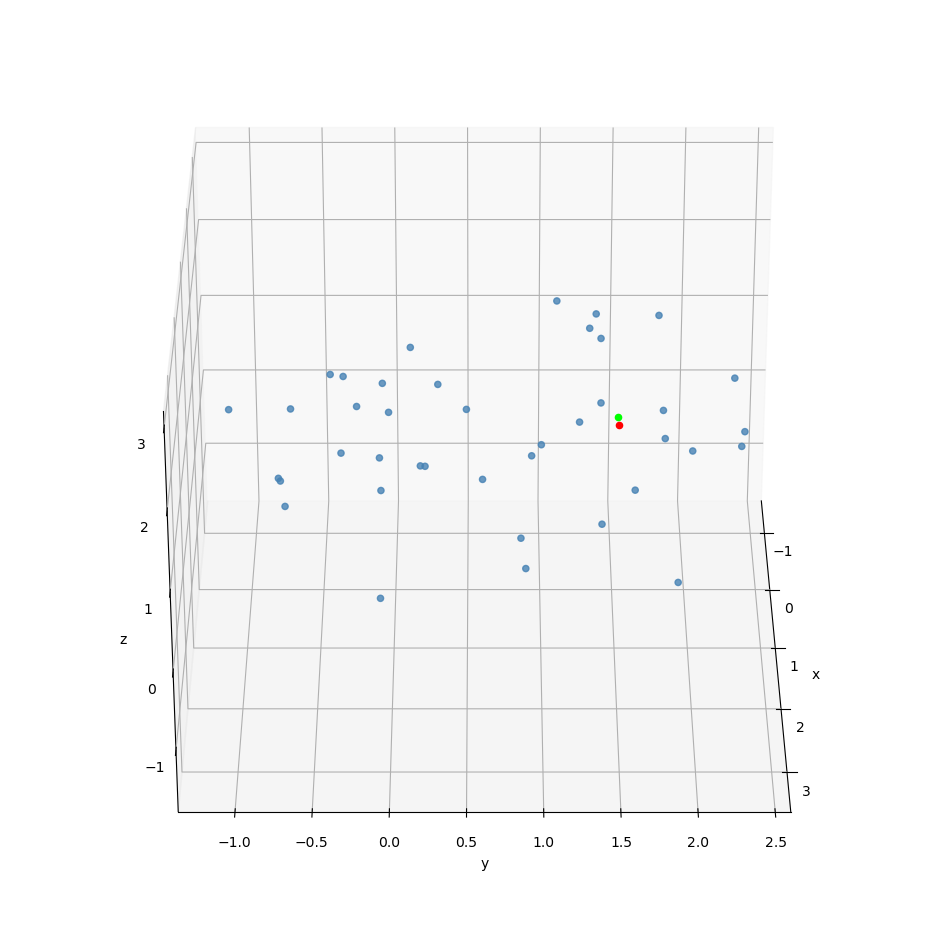

In [223]:
elev=30
azim=-0
roll=0
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

#Changing the angle we view the scatter plot
ax.view_init(elev, azim, roll)


#We plot the points in M as a scatter plot according to their class
ax.scatter(samples_tri2[:,0], samples_tri2[:,1], samples_tri2[:,2], color="steelblue", alpha=.8)
#Uncomment to visualise the origin in 3 dimensions
ax.scatter(q_new_tri2["loc"].detach()[0],q_new_tri2["loc"].detach()[1],q_new_tri2["loc"].detach()[2], color='lime', alpha=1)
ax.scatter(1.5, 1.5, 1.5, color="red", alpha=1)

#Defining labels and legends
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.legend(loc="upper left", scatterpoints=1, numpoints=1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)


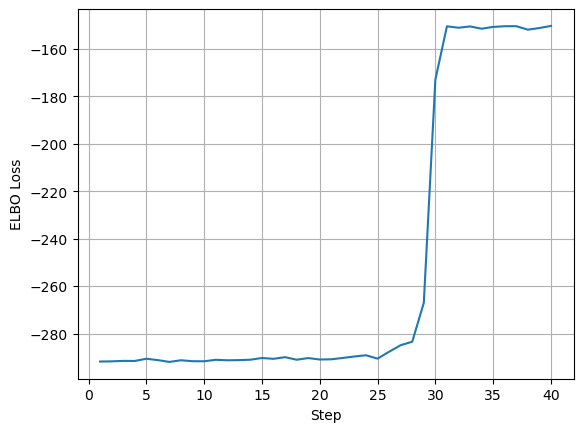

In [224]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_tri2["Epochs"]):
    running_total = 0.
    for j in range((i* parameters_tri2["N"]),((i+1)* parameters_tri2["N"])):
         running_total += q_new_tri2["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

##### 5 Dimensional Multivariate Gaussian distribution

In [110]:
#Defining the model and sampling data points

mean_1_mult = 2.5*torch.ones(5)
var_1_mult = torch.eye(5)
mean_2_mult = torch.zeros(5)
var_2_mult = torch.eye(5)
w_mult = 0.5

samples_mult = Gaussian.SampleFromMixture([mean_1_mult,mean_2_mult], [var_1_mult,var_2_mult], torch.tensor([.5,.5]), 20)

In [111]:
parameters_mult = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([.5]),
    "b": torch.tensor([100.]),
    "D": 5,
    "N": 20,
    "Epochs": 75,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

loc_mult = torch.zeros(parameters_mult["D"])
#variance_param_mult = torch.tensor([100.])

q_global_mult = {
    "loc": torch.nn.Parameter(loc_mult),
    "var": torch.nn.Parameter(torch.tensor([100.])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_mult = []
for i in range(parameters_mult["N"]):
    clients_mult.append({
        "client_idx": i,
        "x_n": samples_mult[i].unsqueeze(0),
        "mean": torch.zeros(parameters_mult["D"]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([1.]),
        "noise_m": mean_2_mult,
        "noise_v": parameters_mult["a"],
        "spherical": True,
        "require_s_n": False
    })

In [112]:
q_new_mult, clients_new_mult = PartitionedVariationalInference(q_global_mult, clients_mult, parameters_mult)

Starting global q:  {'loc': Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([ 0.5347,  0.2240,  0.0203, -0.0115,  0.2807], requires_grad=True) 
 var:  Parameter containing:
tensor([97.6520], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([ 0.8323,  0.0858,  0.3164, -0.0791,  0.5976], requires_grad=True) 
 var:  Parameter containing:
tensor([95.7089], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([0.8318, 0.7310, 0.4541, 0.2282, 0.7786], requires_grad=True) 
 var:  Parameter containing:
tensor([93.7538], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([1.0994, 0.7536, 0.6502, 0.3783, 1.0095], requires_grad=True) 
 var:  Parameter containing:
tensor([91.7707], requires_grad=True)
I

New global q: 
 loc:  Parameter containing:
tensor([2.2265, 2.9003, 2.5623, 2.2091, 3.1627], requires_grad=True) 
 var:  Parameter containing:
tensor([12.0930], requires_grad=True)
Iteration 36:
New global q: 
 loc:  Parameter containing:
tensor([2.1926, 2.8679, 2.4830, 2.2546, 2.9722], requires_grad=True) 
 var:  Parameter containing:
tensor([8.7920], requires_grad=True)
Iteration 37:
New global q: 
 loc:  Parameter containing:
tensor([2.1167, 2.8429, 2.4122, 2.1174, 3.0840], requires_grad=True) 
 var:  Parameter containing:
tensor([5.7108], requires_grad=True)
Iteration 38:
New global q: 
 loc:  Parameter containing:
tensor([2.2456, 2.8928, 2.5291, 2.1352, 3.2532], requires_grad=True) 
 var:  Parameter containing:
tensor([2.4698], requires_grad=True)
Iteration 39:
New global q: 
 loc:  Parameter containing:
tensor([2.0902, 2.9326, 2.5619, 2.0678, 3.1794], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1673], requires_grad=True)
Iteration 40:
New global q: 
 loc:  Paramet

New global q: 
 loc:  Parameter containing:
tensor([2.2626, 2.7296, 2.5571, 2.0649, 2.8356], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0905], requires_grad=True)
Iteration 71:
New global q: 
 loc:  Parameter containing:
tensor([2.2873, 2.7448, 2.5717, 2.1113, 2.8220], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1068], requires_grad=True)
Iteration 72:
New global q: 
 loc:  Parameter containing:
tensor([2.2483, 2.7319, 2.5325, 2.1018, 2.8107], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0905], requires_grad=True)
Iteration 73:
New global q: 
 loc:  Parameter containing:
tensor([2.2619, 2.7288, 2.5478, 2.0817, 2.8319], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1156], requires_grad=True)
Iteration 74:
New global q: 
 loc:  Parameter containing:
tensor([2.2444, 2.7596, 2.5638, 2.0799, 2.8278], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0812], requires_grad=True)
Iteration 75:
New global q: 
 loc:  Paramete

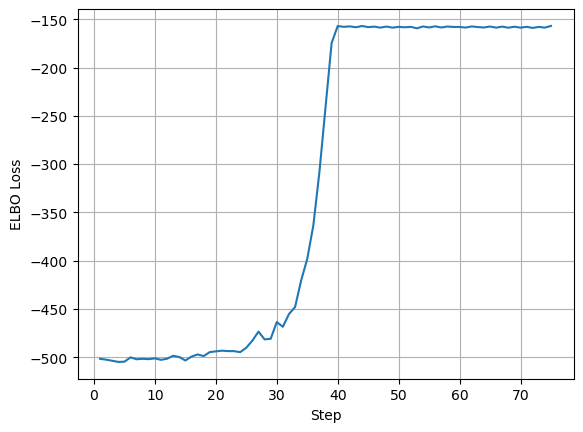

In [113]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_mult["Epochs"]):
    running_total = 0.
    for j in range((i* parameters_mult["N"]),((i+1)* parameters_mult["N"])):
         running_total += q_new_mult["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

#### 7 Dimensional Gaussian 
Would like to do this with even higher dimensional data, but torch doesn't let me somehow?

In [1117]:
#Defining the model and sampling data points
D = 7

mean_1_mult2 = 2.5*torch.ones(D)
var_1_mult2 = torch.eye(D)
mean_2_mult2 = torch.zeros(D)
var_2_mult2 = torch.eye(D)
w_mult = 0.5

samples_mult2 = Gaussian.SampleFromMixture([mean_1_mult2,mean_2_mult2], [var_1_mult2,var_2_mult2], torch.tensor([.5,.5]), 30)

In [1118]:
parameters_mult2 = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([.5]),
    "b": torch.tensor([100.]),
    "D": D,
    "N": 30,
    "Epochs": 75,
    "Divergence": "KLD",
    "lr": 0.005,
    "samples": 50,
    "optim_epochs": 30
}

loc_mult2 = torch.zeros(parameters_mult2["D"])
#variance_param_mult = torch.tensor([100.])

q_global_mult2 = {
    "loc": torch.nn.Parameter(loc_mult2),
    "var": torch.nn.Parameter(torch.tensor([100.])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_mult2 = []
for i in range(parameters_mult2["N"]):
    clients_mult2.append({
        "client_idx": i,
        "x_n": samples_mult2[i].unsqueeze(0),
        "mean": torch.zeros(parameters_mult2["D"]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([1.]),
        "noise_m": mean_2_mult2,
        "noise_v": parameters_mult2["a"],
        "spherical": True,
        "require_s_n": False
    })

In [1119]:
q_new_mult2, clients_new_mult2 = PartitionedVariationalInference(q_global_mult2, clients_mult2, parameters_mult2)

Starting global q:  {'loc': Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([-0.1817,  0.2356,  0.1961,  0.2378,  0.4302,  0.0655,  0.1044],
       requires_grad=True) 
 var:  Parameter containing:
tensor([98.8489], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([-0.0868,  0.1911,  0.2057,  0.3431,  0.4524,  0.2158,  0.0262],
       requires_grad=True) 
 var:  Parameter containing:
tensor([97.7840], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([0.0197, 0.1111, 0.2112, 0.1540, 0.6853, 0.2171, 0.3180],
       requires_grad=True) 
 var:  Parameter containing:
tensor([96.9263], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([0.1147, 0.3365, 0.1577, 0.1280, 0.4236, 0.3505, 0

New global q: 
 loc:  Parameter containing:
tensor([2.7517, 2.2652, 2.5290, 2.1792, 2.4241, 2.0197, 2.2263],
       requires_grad=True) 
 var:  Parameter containing:
tensor([53.9521], requires_grad=True)
Iteration 33:
New global q: 
 loc:  Parameter containing:
tensor([2.8480, 2.3746, 2.5713, 2.3822, 2.3013, 2.0017, 2.3672],
       requires_grad=True) 
 var:  Parameter containing:
tensor([51.6973], requires_grad=True)
Iteration 34:
New global q: 
 loc:  Parameter containing:
tensor([3.0254, 2.3863, 2.6956, 2.3606, 2.5752, 2.0823, 2.4588],
       requires_grad=True) 
 var:  Parameter containing:
tensor([49.2938], requires_grad=True)
Iteration 35:
New global q: 
 loc:  Parameter containing:
tensor([3.0775, 2.6285, 2.7967, 2.2954, 2.5443, 2.3380, 2.2732],
       requires_grad=True) 
 var:  Parameter containing:
tensor([46.9840], requires_grad=True)
Iteration 36:
New global q: 
 loc:  Parameter containing:
tensor([3.0143, 2.6196, 2.6508, 2.4253, 2.7314, 2.4899, 2.3184],
       requires_gra

New global q: 
 loc:  Parameter containing:
tensor([2.7575, 2.4176, 2.7806, 2.5438, 2.5618, 2.6648, 2.4346],
       requires_grad=True) 
 var:  Parameter containing:
tensor([0.0450], requires_grad=True)
Iteration 65:
New global q: 
 loc:  Parameter containing:
tensor([2.7655, 2.3935, 2.7690, 2.5488, 2.5329, 2.6799, 2.4375],
       requires_grad=True) 
 var:  Parameter containing:
tensor([0.0563], requires_grad=True)
Iteration 66:
New global q: 
 loc:  Parameter containing:
tensor([2.7581, 2.4297, 2.7768, 2.5448, 2.5559, 2.6591, 2.4287],
       requires_grad=True) 
 var:  Parameter containing:
tensor([0.0555], requires_grad=True)
Iteration 67:
New global q: 
 loc:  Parameter containing:
tensor([2.7574, 2.4065, 2.7794, 2.5347, 2.5500, 2.6727, 2.4302],
       requires_grad=True) 
 var:  Parameter containing:
tensor([0.0552], requires_grad=True)
Iteration 68:
New global q: 
 loc:  Parameter containing:
tensor([2.7633, 2.4187, 2.7672, 2.5412, 2.5533, 2.6625, 2.4088],
       requires_grad=Tr

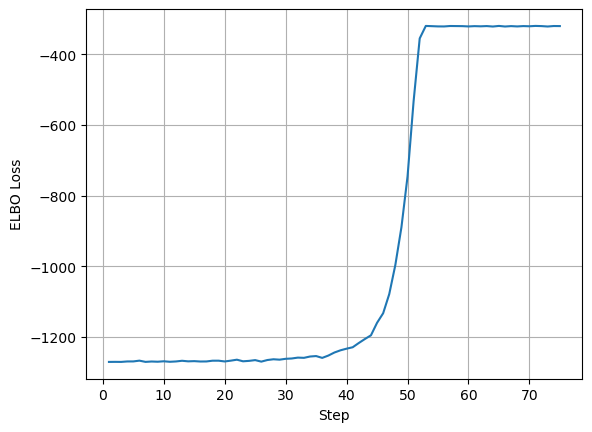

In [1120]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_mult2["Epochs"]):
    running_total = 0.
    for j in range((i* parameters_mult2["N"]),((i+1)* parameters_mult2["N"])):
         running_total += q_new_mult2["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

### Heterogeneous Data Splits

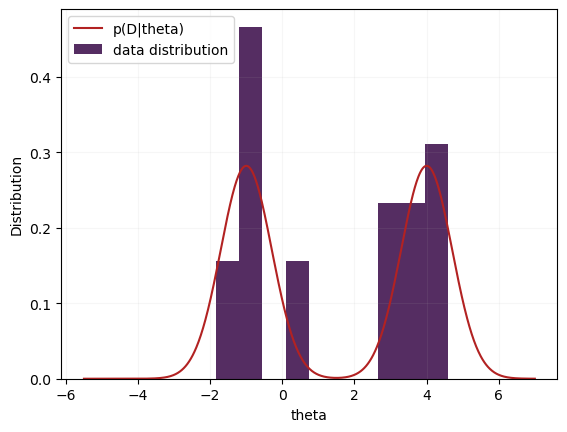

In [122]:
#Defining the model and sampling data points

mean_1_uni6 = torch.tensor([4.])
var_1_uni6 = torch.tensor([.5])
mean_2_uni6 = torch.tensor([-1.])
var_2_uni6 = torch.tensor([.5])
w_uni = 0.5

samples_uni6 = Gaussian.SampleFromMixture([mean_1_uni6,mean_2_uni6], [var_1_uni6,var_2_uni6], torch.tensor([.5,.5]), 20)
samp6 = heterogeneous_split(samples_uni6, 4)

x = np.linspace(-5.5, 7, 1000)

plt.plot(x, Mix(x, 0.5, 4., .5, -1., .5), color="firebrick", label="p(D|theta)")
plt.hist(samples_uni6.numpy(), density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

In [123]:
parameters_uni6 = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([.5]),
    "b": torch.tensor([100.]),
    "D": 1,
    "N": 20,
    "Epochs": 200,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

q_global_uni6 = {
    "loc": torch.nn.Parameter(torch.tensor([0.])),
    "var": torch.nn.Parameter(parameters_uni6["b"]),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_uni6 = []
for i in range(4):
    clients_uni6.append({
        "client_idx": i,
        "x_n": samp6[i],
        "mean": torch.tensor([0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([.5]),
        "noise_m": torch.tensor([-1.]),
        "noise_v": parameters_uni6["a"],
        "spherical": True,
        "require_s_n": False
    })

In [124]:
q_new_uni6, _ = PartitionedVariationalInference(q_global_uni6, clients_uni6, parameters_uni6, is_1d=True)

Starting global q:  {'loc': Parameter containing:
tensor([0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([-0.0386], requires_grad=True) 
 var:  Parameter containing:
tensor([99.2846], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([-0.0817], requires_grad=True) 
 var:  Parameter containing:
tensor([98.5960], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([-0.1358], requires_grad=True) 
 var:  Parameter containing:
tensor([97.8843], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([-0.0702], requires_grad=True) 
 var:  Parameter containing:
tensor([97.1431], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([-0.0578], requires_grad=True) 
 var:  Parameter containing:
tensor([96.3850], requires

New global q: 
 loc:  Parameter containing:
tensor([0.1055], requires_grad=True) 
 var:  Parameter containing:
tensor([76.7895], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([0.0544], requires_grad=True) 
 var:  Parameter containing:
tensor([76.2798], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([-0.0807], requires_grad=True) 
 var:  Parameter containing:
tensor([75.7484], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([0.0667], requires_grad=True) 
 var:  Parameter containing:
tensor([75.3703], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([0.1562], requires_grad=True) 
 var:  Parameter containing:
tensor([74.7492], requires_grad=True)
Iteration 45:
New global q: 
 loc:  Parameter containing:
tensor([0.1550], requires_grad=True) 
 var:  Parameter containing:
tensor([74.1173], requires_grad=True)
Iteration 46:
New global q: 
 loc: 

New global q: 
 loc:  Parameter containing:
tensor([0.3046], requires_grad=True) 
 var:  Parameter containing:
tensor([54.6252], requires_grad=True)
Iteration 81:
New global q: 
 loc:  Parameter containing:
tensor([0.2861], requires_grad=True) 
 var:  Parameter containing:
tensor([54.0357], requires_grad=True)
Iteration 82:
New global q: 
 loc:  Parameter containing:
tensor([0.2387], requires_grad=True) 
 var:  Parameter containing:
tensor([53.3659], requires_grad=True)
Iteration 83:
New global q: 
 loc:  Parameter containing:
tensor([0.2410], requires_grad=True) 
 var:  Parameter containing:
tensor([52.7278], requires_grad=True)
Iteration 84:
New global q: 
 loc:  Parameter containing:
tensor([0.2931], requires_grad=True) 
 var:  Parameter containing:
tensor([52.1529], requires_grad=True)
Iteration 85:
New global q: 
 loc:  Parameter containing:
tensor([0.3176], requires_grad=True) 
 var:  Parameter containing:
tensor([51.4759], requires_grad=True)
Iteration 86:
New global q: 
 loc:  

New global q: 
 loc:  Parameter containing:
tensor([-0.4655], requires_grad=True) 
 var:  Parameter containing:
tensor([28.8410], requires_grad=True)
Iteration 121:
New global q: 
 loc:  Parameter containing:
tensor([-0.4584], requires_grad=True) 
 var:  Parameter containing:
tensor([28.1141], requires_grad=True)
Iteration 122:
New global q: 
 loc:  Parameter containing:
tensor([-0.6174], requires_grad=True) 
 var:  Parameter containing:
tensor([27.2926], requires_grad=True)
Iteration 123:
New global q: 
 loc:  Parameter containing:
tensor([-0.5580], requires_grad=True) 
 var:  Parameter containing:
tensor([26.4894], requires_grad=True)
Iteration 124:
New global q: 
 loc:  Parameter containing:
tensor([-0.4631], requires_grad=True) 
 var:  Parameter containing:
tensor([25.6685], requires_grad=True)
Iteration 125:
New global q: 
 loc:  Parameter containing:
tensor([-0.3449], requires_grad=True) 
 var:  Parameter containing:
tensor([24.9093], requires_grad=True)
Iteration 126:
New global

New global q: 
 loc:  Parameter containing:
tensor([3.7114], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1267], requires_grad=True)
Iteration 161:
New global q: 
 loc:  Parameter containing:
tensor([3.7374], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1614], requires_grad=True)
Iteration 162:
New global q: 
 loc:  Parameter containing:
tensor([3.7197], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1574], requires_grad=True)
Iteration 163:
New global q: 
 loc:  Parameter containing:
tensor([3.7456], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1542], requires_grad=True)
Iteration 164:
New global q: 
 loc:  Parameter containing:
tensor([3.7249], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1679], requires_grad=True)
Iteration 165:
New global q: 
 loc:  Parameter containing:
tensor([3.7443], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1471], requires_grad=True)
Iteration 166:
New global q: 
 loc:  

New global q: 
 loc:  Parameter containing:
tensor([3.7289], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1588], requires_grad=True)


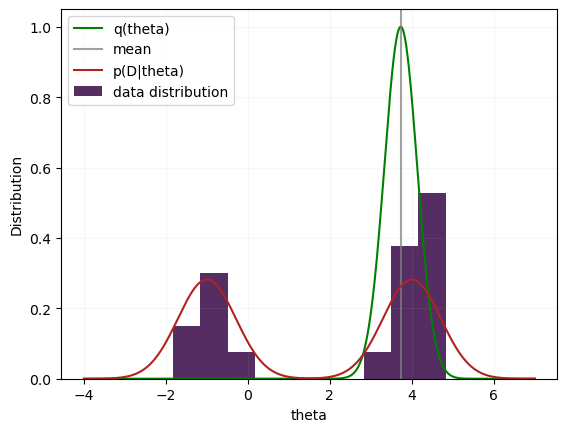

In [125]:
x = np.linspace(-4, 7, 1000)

plt.plot(x, Normal(q_new_uni6["loc"].detach().squeeze().numpy(), q_new_uni6["var"].detach().squeeze().numpy(), x, 1),
         label="q(theta)", color='green')
plt.axvline(q_new_uni6["loc"].detach().squeeze().numpy(), color ="grey", label = "mean", alpha=.75)
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, 0.5, 4., .5, -1., .5), color="firebrick", label="p(D|theta)")
plt.hist(samples_uni5.numpy(), density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

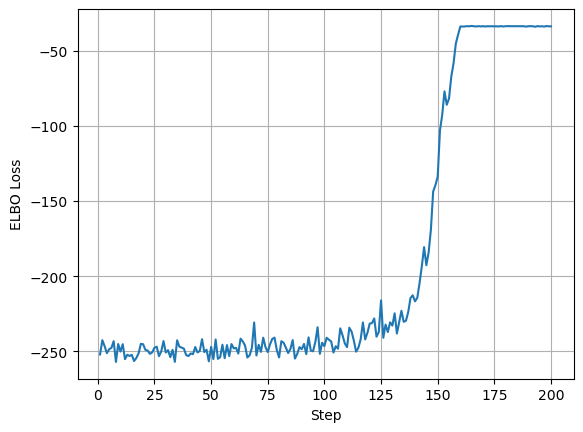

In [126]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_uni6["Epochs"]):
    running_total = 0.
    for j in range((i* 4),((i+1)* 4)):
         running_total += q_new_uni6["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

#### 2D Example from beginning with heterogenous data splits

In [127]:
a = x_
b = y_
num_shards = 5
l = []
for i in range(len(a)):
    l.append([a[i], b[i]])

split_data = heterogeneous_split(torch.tensor(l), num_shards)

In [128]:
parameters_het = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([2.]),
    "b": torch.tensor([100.]),
    "D": 2,
    "N": 20,
    "Epochs": 150,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

q_global_het = {
    "loc": torch.nn.Parameter(torch.tensor([0.,0.])),
    "var": torch.nn.Parameter(torch.tensor([100.])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_het = []
for i in range(num_shards):
    clients_het.append({
        "client_idx": i,
        "x_n": split_data[i],
        "mean": torch.tensor([0., 0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([1.]),
        "noise_m": torch.tensor([0., 0.]),
        "noise_v": parameters_het["a"],
        "spherical": True,
        "require_s_n": False
    })

In [129]:
q_new_het, clients_new_het = PartitionedVariationalInference(q_global_het, clients_het, parameters_het)

Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([-0.0033, -0.0293], requires_grad=True) 
 var:  Parameter containing:
tensor([98.7223], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([-0.1060, -0.0197], requires_grad=True) 
 var:  Parameter containing:
tensor([97.3847], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([-0.0289, -0.0460], requires_grad=True) 
 var:  Parameter containing:
tensor([96.1050], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([0.0066, 0.0506], requires_grad=True) 
 var:  Parameter containing:
tensor([94.8223], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([0.0637, 0.1766], requires_grad=True) 
 var:  Par

New global q: 
 loc:  Parameter containing:
tensor([ 0.4112, -0.6990], requires_grad=True) 
 var:  Parameter containing:
tensor([51.9365], requires_grad=True)
Iteration 39:
New global q: 
 loc:  Parameter containing:
tensor([ 0.3516, -0.8920], requires_grad=True) 
 var:  Parameter containing:
tensor([50.6890], requires_grad=True)
Iteration 40:
New global q: 
 loc:  Parameter containing:
tensor([ 0.3519, -0.6713], requires_grad=True) 
 var:  Parameter containing:
tensor([49.4276], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([ 0.3320, -0.5801], requires_grad=True) 
 var:  Parameter containing:
tensor([48.2661], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([ 0.5506, -0.6728], requires_grad=True) 
 var:  Parameter containing:
tensor([47.0150], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([ 0.4467, -0.5723], requires_grad=True) 
 var:  Parameter containing:
tensor([45.707

New global q: 
 loc:  Parameter containing:
tensor([1.5950, 0.1779], requires_grad=True) 
 var:  Parameter containing:
tensor([6.9889], requires_grad=True)
Iteration 77:
New global q: 
 loc:  Parameter containing:
tensor([1.6198, 0.2456], requires_grad=True) 
 var:  Parameter containing:
tensor([6.0381], requires_grad=True)
Iteration 78:
New global q: 
 loc:  Parameter containing:
tensor([1.7532, 0.3631], requires_grad=True) 
 var:  Parameter containing:
tensor([5.0495], requires_grad=True)
Iteration 79:
New global q: 
 loc:  Parameter containing:
tensor([1.8943, 0.3300], requires_grad=True) 
 var:  Parameter containing:
tensor([4.0845], requires_grad=True)
Iteration 80:
New global q: 
 loc:  Parameter containing:
tensor([1.8440, 0.4333], requires_grad=True) 
 var:  Parameter containing:
tensor([3.1877], requires_grad=True)
Iteration 81:
New global q: 
 loc:  Parameter containing:
tensor([1.8728, 0.5831], requires_grad=True) 
 var:  Parameter containing:
tensor([2.3422], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.4314, 2.1420], requires_grad=True) 
 var:  Parameter containing:
tensor([0.3014], requires_grad=True)
Iteration 116:
New global q: 
 loc:  Parameter containing:
tensor([1.4345, 2.1136], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2804], requires_grad=True)
Iteration 117:
New global q: 
 loc:  Parameter containing:
tensor([1.4497, 2.2072], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2337], requires_grad=True)
Iteration 118:
New global q: 
 loc:  Parameter containing:
tensor([1.4505, 2.1487], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2693], requires_grad=True)
Iteration 119:
New global q: 
 loc:  Parameter containing:
tensor([1.4379, 2.1465], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2775], requires_grad=True)
Iteration 120:
New global q: 
 loc:  Parameter containing:
tensor([1.3886, 2.1733], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2621], requires_

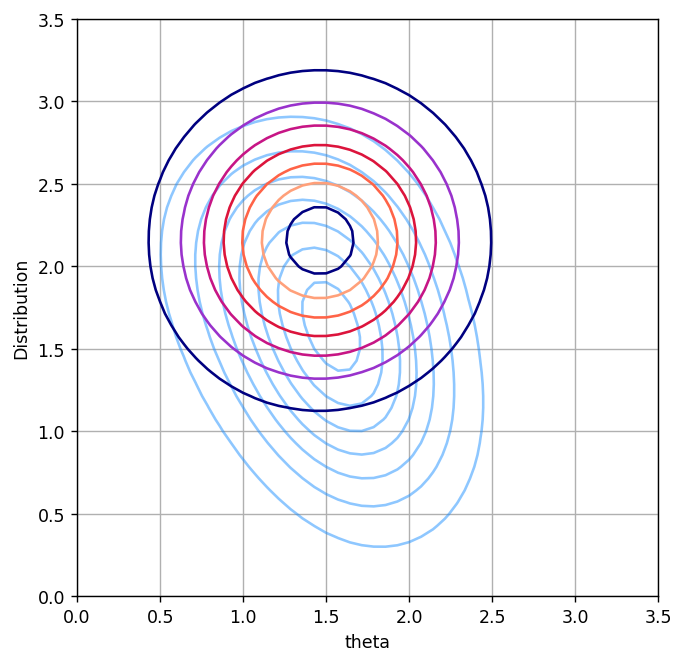

In [168]:
x = np.linspace(0,3.5)
y = np.linspace(0,3.5)
X_q, Y_q = np.meshgrid(x, y)
plt.figure(figsize=(6,6), dpi=125)
Z_pvi_ = Normal(q_new_het["loc"].detach().squeeze().numpy(), q_new_het["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters_het["D"])

#Z_true_h = trueDistribution2D(parameters_het, clients_new_het, 0.5,3.5,1, 4)

c1 = plt.contour(X_q,Y_q,Z_true_h, colors='dodgerblue', alpha=.5)

c2 = plt.contour(X_q,Y_q,Z_pvi_, colors = cmap1)

#c3 = plt.contour(X_q,Y_q,Z_pvi, colors=cmap2, alpha=.5)
#plt.scatter(x_,y_,color="firebrick")
#h1,_=c1.legend_elements()
h2,_=c2.legend_elements()
#h3,_=c3.legend_elements()
plt.xlabel("theta")
plt.ylabel("Distribution")
#plt.legend([h1[0],h2[0], h3[0]], ["p(D, theta)", "heterogeneous PVI", "homogeneous PVI"], loc="upper left")
plt.grid(visible=True)
#plt.savefig("Erroneous_PVI_posterior.png")

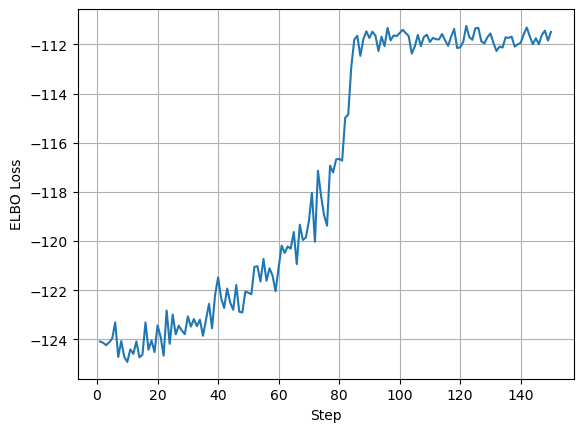

In [131]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_het["Epochs"]):
    running_total = 0.
    for j in range((i* num_shards),((i+1)* num_shards)):
         running_total += q_new_het["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

### PVI with clients only containing noise and with clients not containing noise

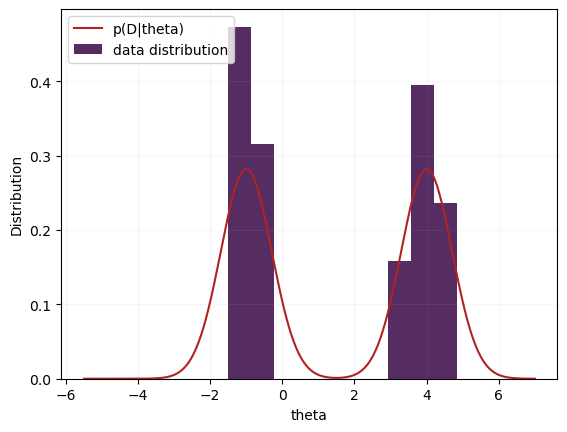

In [132]:
#Defining the model and sampling data points

mean_1_uni7 = torch.tensor([4.])
var_1_uni7 = torch.tensor([.5])
mean_2_uni7 = torch.tensor([-1.])
var_2_uni7 = torch.tensor([.5])
w_uni = 0.5

samples_uni7 = Gaussian.HeterogenousSampleMix([mean_1_uni7,mean_2_uni7], 
                                              [var_1_uni7,var_2_uni7], torch.tensor([.5,.5]), 20)
#temp = heterogenous_split(samples_uni6, 4)

samps7 = torch.cat((samples_uni7[0],samples_uni7[1]), 0)
x = np.linspace(-5.5, 7, 1000)

plt.plot(x, Mix(x, 0.5, 4., .5, -1., .5), color="firebrick", label="p(D|theta)")
plt.hist(samps7.numpy(), density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

In [133]:
parameters_uni7 = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([.5]),
    "b": torch.tensor([100.]),
    "D": 1,
    "N": 20,
    "Epochs": 350,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

q_global_uni7 = {
    "loc": torch.nn.Parameter(torch.tensor([0.])),
    "var": torch.nn.Parameter(parameters_uni7["b"]),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_uni7 = []
for i in range(2):
    clients_uni7.append({
        "client_idx": i,
        "x_n": samples_uni7[i],
        "mean": torch.tensor([0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([.5]),
        "noise_m": torch.tensor([-1.]),
        "noise_v": parameters_uni7["a"],
        "spherical": True,
        "require_s_n": False
    })

In [134]:
q_new_uni7, _ = PartitionedVariationalInference(q_global_uni7, clients_uni7, parameters_uni7, is_1d=True)

Starting global q:  {'loc': Parameter containing:
tensor([0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([-0.0892], requires_grad=True) 
 var:  Parameter containing:
tensor([99.5883], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([-0.1289], requires_grad=True) 
 var:  Parameter containing:
tensor([99.2187], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([-0.1170], requires_grad=True) 
 var:  Parameter containing:
tensor([98.8491], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([-0.0862], requires_grad=True) 
 var:  Parameter containing:
tensor([98.3968], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([-0.0049], requires_grad=True) 
 var:  Parameter containing:
tensor([97.9533], requires

New global q: 
 loc:  Parameter containing:
tensor([0.0717], requires_grad=True) 
 var:  Parameter containing:
tensor([86.2905], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([0.0199], requires_grad=True) 
 var:  Parameter containing:
tensor([85.9440], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([0.0356], requires_grad=True) 
 var:  Parameter containing:
tensor([85.6740], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([0.0955], requires_grad=True) 
 var:  Parameter containing:
tensor([85.3654], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([-0.0842], requires_grad=True) 
 var:  Parameter containing:
tensor([84.9945], requires_grad=True)
Iteration 45:
New global q: 
 loc:  Parameter containing:
tensor([-0.0539], requires_grad=True) 
 var:  Parameter containing:
tensor([84.6791], requires_grad=True)
Iteration 46:
New global q: 
 loc:

New global q: 
 loc:  Parameter containing:
tensor([0.1338], requires_grad=True) 
 var:  Parameter containing:
tensor([73.7699], requires_grad=True)
Iteration 81:
New global q: 
 loc:  Parameter containing:
tensor([0.2389], requires_grad=True) 
 var:  Parameter containing:
tensor([73.4100], requires_grad=True)
Iteration 82:
New global q: 
 loc:  Parameter containing:
tensor([0.3126], requires_grad=True) 
 var:  Parameter containing:
tensor([73.0608], requires_grad=True)
Iteration 83:
New global q: 
 loc:  Parameter containing:
tensor([0.3350], requires_grad=True) 
 var:  Parameter containing:
tensor([72.7638], requires_grad=True)
Iteration 84:
New global q: 
 loc:  Parameter containing:
tensor([0.2532], requires_grad=True) 
 var:  Parameter containing:
tensor([72.5091], requires_grad=True)
Iteration 85:
New global q: 
 loc:  Parameter containing:
tensor([0.2493], requires_grad=True) 
 var:  Parameter containing:
tensor([72.1810], requires_grad=True)
Iteration 86:
New global q: 
 loc:  

New global q: 
 loc:  Parameter containing:
tensor([-1.1255], requires_grad=True) 
 var:  Parameter containing:
tensor([61.0252], requires_grad=True)
Iteration 121:
New global q: 
 loc:  Parameter containing:
tensor([-1.1164], requires_grad=True) 
 var:  Parameter containing:
tensor([60.6599], requires_grad=True)
Iteration 122:
New global q: 
 loc:  Parameter containing:
tensor([-1.0843], requires_grad=True) 
 var:  Parameter containing:
tensor([60.3536], requires_grad=True)
Iteration 123:
New global q: 
 loc:  Parameter containing:
tensor([-1.1072], requires_grad=True) 
 var:  Parameter containing:
tensor([60.0159], requires_grad=True)
Iteration 124:
New global q: 
 loc:  Parameter containing:
tensor([-0.9783], requires_grad=True) 
 var:  Parameter containing:
tensor([59.7166], requires_grad=True)
Iteration 125:
New global q: 
 loc:  Parameter containing:
tensor([-0.9315], requires_grad=True) 
 var:  Parameter containing:
tensor([59.3945], requires_grad=True)
Iteration 126:
New global

New global q: 
 loc:  Parameter containing:
tensor([-0.9917], requires_grad=True) 
 var:  Parameter containing:
tensor([48.1312], requires_grad=True)
Iteration 161:
New global q: 
 loc:  Parameter containing:
tensor([-0.8808], requires_grad=True) 
 var:  Parameter containing:
tensor([47.8305], requires_grad=True)
Iteration 162:
New global q: 
 loc:  Parameter containing:
tensor([-0.9175], requires_grad=True) 
 var:  Parameter containing:
tensor([47.4830], requires_grad=True)
Iteration 163:
New global q: 
 loc:  Parameter containing:
tensor([-0.9137], requires_grad=True) 
 var:  Parameter containing:
tensor([47.2112], requires_grad=True)
Iteration 164:
New global q: 
 loc:  Parameter containing:
tensor([-0.9396], requires_grad=True) 
 var:  Parameter containing:
tensor([46.8604], requires_grad=True)
Iteration 165:
New global q: 
 loc:  Parameter containing:
tensor([-1.1328], requires_grad=True) 
 var:  Parameter containing:
tensor([46.4917], requires_grad=True)
Iteration 166:
New global

New global q: 
 loc:  Parameter containing:
tensor([-0.4969], requires_grad=True) 
 var:  Parameter containing:
tensor([33.7880], requires_grad=True)
Iteration 201:
New global q: 
 loc:  Parameter containing:
tensor([-0.5317], requires_grad=True) 
 var:  Parameter containing:
tensor([33.4333], requires_grad=True)
Iteration 202:
New global q: 
 loc:  Parameter containing:
tensor([-0.5465], requires_grad=True) 
 var:  Parameter containing:
tensor([33.0492], requires_grad=True)
Iteration 203:
New global q: 
 loc:  Parameter containing:
tensor([-0.5712], requires_grad=True) 
 var:  Parameter containing:
tensor([32.6431], requires_grad=True)
Iteration 204:
New global q: 
 loc:  Parameter containing:
tensor([-0.4918], requires_grad=True) 
 var:  Parameter containing:
tensor([32.2471], requires_grad=True)
Iteration 205:
New global q: 
 loc:  Parameter containing:
tensor([-0.3860], requires_grad=True) 
 var:  Parameter containing:
tensor([31.8967], requires_grad=True)
Iteration 206:
New global

New global q: 
 loc:  Parameter containing:
tensor([-0.1435], requires_grad=True) 
 var:  Parameter containing:
tensor([16.5268], requires_grad=True)
Iteration 241:
New global q: 
 loc:  Parameter containing:
tensor([-0.0430], requires_grad=True) 
 var:  Parameter containing:
tensor([16.0467], requires_grad=True)
Iteration 242:
New global q: 
 loc:  Parameter containing:
tensor([0.0255], requires_grad=True) 
 var:  Parameter containing:
tensor([15.5552], requires_grad=True)
Iteration 243:
New global q: 
 loc:  Parameter containing:
tensor([0.1742], requires_grad=True) 
 var:  Parameter containing:
tensor([15.0226], requires_grad=True)
Iteration 244:
New global q: 
 loc:  Parameter containing:
tensor([0.3241], requires_grad=True) 
 var:  Parameter containing:
tensor([14.5277], requires_grad=True)
Iteration 245:
New global q: 
 loc:  Parameter containing:
tensor([0.3611], requires_grad=True) 
 var:  Parameter containing:
tensor([13.9875], requires_grad=True)
Iteration 246:
New global q: 

New global q: 
 loc:  Parameter containing:
tensor([4.0345], requires_grad=True) 
 var:  Parameter containing:
tensor([2.7200], requires_grad=True)
Iteration 281:
New global q: 
 loc:  Parameter containing:
tensor([4.1739], requires_grad=True) 
 var:  Parameter containing:
tensor([2.6094], requires_grad=True)
Iteration 282:
New global q: 
 loc:  Parameter containing:
tensor([4.0674], requires_grad=True) 
 var:  Parameter containing:
tensor([2.4974], requires_grad=True)
Iteration 283:
New global q: 
 loc:  Parameter containing:
tensor([3.9893], requires_grad=True) 
 var:  Parameter containing:
tensor([2.4225], requires_grad=True)
Iteration 284:
New global q: 
 loc:  Parameter containing:
tensor([4.0666], requires_grad=True) 
 var:  Parameter containing:
tensor([2.3670], requires_grad=True)
Iteration 285:
New global q: 
 loc:  Parameter containing:
tensor([4.0190], requires_grad=True) 
 var:  Parameter containing:
tensor([2.2900], requires_grad=True)
Iteration 286:
New global q: 
 loc:  

New global q: 
 loc:  Parameter containing:
tensor([4.0075], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1514], requires_grad=True)
Iteration 321:
New global q: 
 loc:  Parameter containing:
tensor([4.0040], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1688], requires_grad=True)
Iteration 322:
New global q: 
 loc:  Parameter containing:
tensor([4.0027], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1519], requires_grad=True)
Iteration 323:
New global q: 
 loc:  Parameter containing:
tensor([4.0063], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1466], requires_grad=True)
Iteration 324:
New global q: 
 loc:  Parameter containing:
tensor([3.9836], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1646], requires_grad=True)
Iteration 325:
New global q: 
 loc:  Parameter containing:
tensor([3.9826], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1509], requires_grad=True)
Iteration 326:
New global q: 
 loc:  

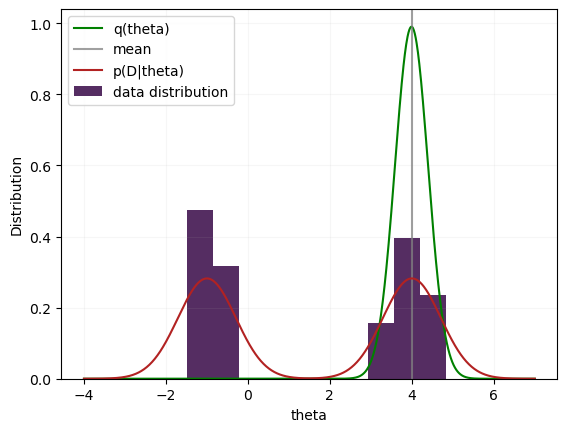

In [135]:
x = np.linspace(-4, 7, 1000)

plt.plot(x, Normal(q_new_uni7["loc"].detach().squeeze().numpy(), q_new_uni7["var"].detach().squeeze().numpy(), x, 1),
         label="q(theta)", color='green')
plt.axvline(q_new_uni7["loc"].detach().squeeze().numpy(), color ="grey", label = "mean", alpha=.75)
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, 0.5, 4., .5, -1., .5), color="firebrick", label="p(D|theta)")
plt.hist(samps7.numpy(), density=True, bins=10, label="data distribution", color="#552D62")

plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

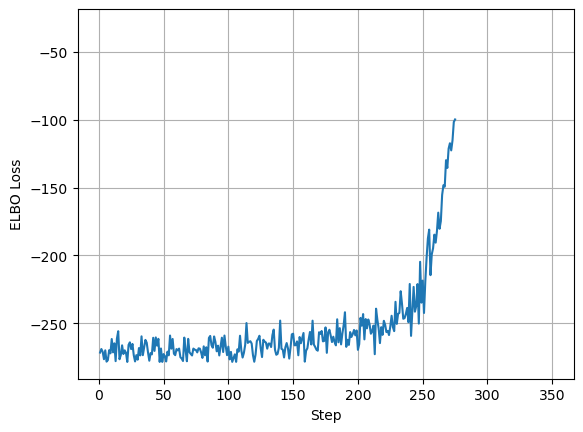

In [136]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_uni7["Epochs"]):
    running_total = 0.
    for j in range((i* 2),((i+1)* 2)):
         running_total += q_new_uni7["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

### Fitting Single Gaussian to Mixtures of Gausians with $>2$ Mixture Components

While I would like to do this, I would have to change the PVI code for this...

# Alpha-Renyi Divergence P-GVI

### 1 Dimensional Example from Beginning

In [198]:
#Parameters Definitions:
parameters_ar = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([2.]),
    "b": torch.tensor([100.]),
    "D": 1,
    "N": 20,
    "Epochs": 400,
    "Divergence": "AR",
    "lr": 0.002,
    "samples": 50,
    "optim_epochs": 30,
    "alpha": 0.5
}

loc_ar = torch.tensor([-1.])


q_global_ar = {
    "loc": torch.nn.Parameter(loc_ar),
    "var": torch.nn.Parameter(parameters_ar["b"]),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_ar = []
for i in range(parameters_ar["N"]):
    clients_ar.append({
        "client_idx": i,
        "x_n": torch.tensor([[x_1d[i]]]),
        "mean": torch.tensor([0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([1.]),
        "noise_m": torch.tensor([-1]),
        "noise_v": parameters_ar["a"],
        "spherical": True,
        "require_s_n": False
    })

In [199]:
q_new_ar, clients_new_ar = PartitionedVariationalInference(q_global_ar, clients_ar, parameters_ar, is_1d=True)

Starting global q:  {'loc': Parameter containing:
tensor([-1.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([-0.9767], requires_grad=True) 
 var:  Parameter containing:
tensor([99.3581], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([-1.0310], requires_grad=True) 
 var:  Parameter containing:
tensor([98.6954], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([-0.9518], requires_grad=True) 
 var:  Parameter containing:
tensor([98.1382], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([-0.9288], requires_grad=True) 
 var:  Parameter containing:
tensor([97.5478], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([-0.8581], requires_grad=True) 
 var:  Parameter containing:
tensor([96.9426], require

New global q: 
 loc:  Parameter containing:
tensor([-0.5786], requires_grad=True) 
 var:  Parameter containing:
tensor([76.5374], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([-0.5998], requires_grad=True) 
 var:  Parameter containing:
tensor([75.9984], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([-0.6003], requires_grad=True) 
 var:  Parameter containing:
tensor([75.4628], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([-0.5224], requires_grad=True) 
 var:  Parameter containing:
tensor([74.9358], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([-0.5916], requires_grad=True) 
 var:  Parameter containing:
tensor([74.3771], requires_grad=True)
Iteration 45:
New global q: 
 loc:  Parameter containing:
tensor([-0.4983], requires_grad=True) 
 var:  Parameter containing:
tensor([73.7748], requires_grad=True)
Iteration 46:
New global q: 
 

New global q: 
 loc:  Parameter containing:
tensor([-0.9458], requires_grad=True) 
 var:  Parameter containing:
tensor([53.1991], requires_grad=True)
Iteration 81:
New global q: 
 loc:  Parameter containing:
tensor([-1.0515], requires_grad=True) 
 var:  Parameter containing:
tensor([52.5191], requires_grad=True)
Iteration 82:
New global q: 
 loc:  Parameter containing:
tensor([-1.0173], requires_grad=True) 
 var:  Parameter containing:
tensor([51.8693], requires_grad=True)
Iteration 83:
New global q: 
 loc:  Parameter containing:
tensor([-1.1122], requires_grad=True) 
 var:  Parameter containing:
tensor([51.2869], requires_grad=True)
Iteration 84:
New global q: 
 loc:  Parameter containing:
tensor([-1.1270], requires_grad=True) 
 var:  Parameter containing:
tensor([50.6926], requires_grad=True)
Iteration 85:
New global q: 
 loc:  Parameter containing:
tensor([-1.0784], requires_grad=True) 
 var:  Parameter containing:
tensor([50.0678], requires_grad=True)
Iteration 86:
New global q: 
 

New global q: 
 loc:  Parameter containing:
tensor([-0.5105], requires_grad=True) 
 var:  Parameter containing:
tensor([25.1648], requires_grad=True)
Iteration 121:
New global q: 
 loc:  Parameter containing:
tensor([-0.3888], requires_grad=True) 
 var:  Parameter containing:
tensor([24.3275], requires_grad=True)
Iteration 122:
New global q: 
 loc:  Parameter containing:
tensor([-0.3866], requires_grad=True) 
 var:  Parameter containing:
tensor([23.4513], requires_grad=True)
Iteration 123:
New global q: 
 loc:  Parameter containing:
tensor([-0.4000], requires_grad=True) 
 var:  Parameter containing:
tensor([22.5919], requires_grad=True)
Iteration 124:
New global q: 
 loc:  Parameter containing:
tensor([-0.3623], requires_grad=True) 
 var:  Parameter containing:
tensor([21.6751], requires_grad=True)
Iteration 125:
New global q: 
 loc:  Parameter containing:
tensor([-0.3629], requires_grad=True) 
 var:  Parameter containing:
tensor([20.7558], requires_grad=True)
Iteration 126:
New global

New global q: 
 loc:  Parameter containing:
tensor([3.0603], requires_grad=True) 
 var:  Parameter containing:
tensor([0.5657], requires_grad=True)
Iteration 161:
New global q: 
 loc:  Parameter containing:
tensor([3.0657], requires_grad=True) 
 var:  Parameter containing:
tensor([0.5880], requires_grad=True)
Iteration 162:
New global q: 
 loc:  Parameter containing:
tensor([3.0975], requires_grad=True) 
 var:  Parameter containing:
tensor([0.5569], requires_grad=True)
Iteration 163:
New global q: 
 loc:  Parameter containing:
tensor([3.0978], requires_grad=True) 
 var:  Parameter containing:
tensor([0.5972], requires_grad=True)
Iteration 164:
New global q: 
 loc:  Parameter containing:
tensor([3.0500], requires_grad=True) 
 var:  Parameter containing:
tensor([0.6572], requires_grad=True)
Iteration 165:
New global q: 
 loc:  Parameter containing:
tensor([3.1019], requires_grad=True) 
 var:  Parameter containing:
tensor([0.5719], requires_grad=True)
Iteration 166:
New global q: 
 loc:  

New global q: 
 loc:  Parameter containing:
tensor([3.0813], requires_grad=True) 
 var:  Parameter containing:
tensor([0.6286], requires_grad=True)
Iteration 201:
New global q: 
 loc:  Parameter containing:
tensor([3.0638], requires_grad=True) 
 var:  Parameter containing:
tensor([0.6439], requires_grad=True)
Iteration 202:
New global q: 
 loc:  Parameter containing:
tensor([3.1375], requires_grad=True) 
 var:  Parameter containing:
tensor([0.5645], requires_grad=True)
Iteration 203:
New global q: 
 loc:  Parameter containing:
tensor([3.0940], requires_grad=True) 
 var:  Parameter containing:
tensor([0.6222], requires_grad=True)
Iteration 204:
New global q: 
 loc:  Parameter containing:
tensor([3.0917], requires_grad=True) 
 var:  Parameter containing:
tensor([0.6059], requires_grad=True)
Iteration 205:
New global q: 
 loc:  Parameter containing:
tensor([3.0956], requires_grad=True) 
 var:  Parameter containing:
tensor([0.6101], requires_grad=True)
Iteration 206:
New global q: 
 loc:  

New global q: 
 loc:  Parameter containing:
tensor([3.0431], requires_grad=True) 
 var:  Parameter containing:
tensor([0.6409], requires_grad=True)
Iteration 241:
New global q: 
 loc:  Parameter containing:
tensor([3.1362], requires_grad=True) 
 var:  Parameter containing:
tensor([0.5480], requires_grad=True)
Iteration 242:
New global q: 
 loc:  Parameter containing:
tensor([3.0848], requires_grad=True) 
 var:  Parameter containing:
tensor([0.6325], requires_grad=True)
Iteration 243:
New global q: 
 loc:  Parameter containing:
tensor([3.0719], requires_grad=True) 
 var:  Parameter containing:
tensor([0.6252], requires_grad=True)
Iteration 244:
New global q: 
 loc:  Parameter containing:
tensor([3.0691], requires_grad=True) 
 var:  Parameter containing:
tensor([0.6440], requires_grad=True)
Iteration 245:
New global q: 
 loc:  Parameter containing:
tensor([3.0650], requires_grad=True) 
 var:  Parameter containing:
tensor([0.6299], requires_grad=True)
Iteration 246:
New global q: 
 loc:  

New global q: 
 loc:  Parameter containing:
tensor([3.0909], requires_grad=True) 
 var:  Parameter containing:
tensor([0.6101], requires_grad=True)
Iteration 281:
New global q: 
 loc:  Parameter containing:
tensor([3.0801], requires_grad=True) 
 var:  Parameter containing:
tensor([0.6063], requires_grad=True)
Iteration 282:
New global q: 
 loc:  Parameter containing:
tensor([3.1218], requires_grad=True) 
 var:  Parameter containing:
tensor([0.5808], requires_grad=True)
Iteration 283:
New global q: 
 loc:  Parameter containing:
tensor([3.0775], requires_grad=True) 
 var:  Parameter containing:
tensor([0.6281], requires_grad=True)
Iteration 284:
New global q: 
 loc:  Parameter containing:
tensor([3.1061], requires_grad=True) 
 var:  Parameter containing:
tensor([0.5887], requires_grad=True)
Iteration 285:
New global q: 
 loc:  Parameter containing:
tensor([3.0617], requires_grad=True) 
 var:  Parameter containing:
tensor([0.6381], requires_grad=True)
Iteration 286:
New global q: 
 loc:  

New global q: 
 loc:  Parameter containing:
tensor([3.0769], requires_grad=True) 
 var:  Parameter containing:
tensor([0.6492], requires_grad=True)
Iteration 321:
New global q: 
 loc:  Parameter containing:
tensor([3.0912], requires_grad=True) 
 var:  Parameter containing:
tensor([0.6076], requires_grad=True)
Iteration 322:
New global q: 
 loc:  Parameter containing:
tensor([3.1069], requires_grad=True) 
 var:  Parameter containing:
tensor([0.5755], requires_grad=True)
Iteration 323:
New global q: 
 loc:  Parameter containing:
tensor([3.0805], requires_grad=True) 
 var:  Parameter containing:
tensor([0.6202], requires_grad=True)
Iteration 324:
New global q: 
 loc:  Parameter containing:
tensor([3.0820], requires_grad=True) 
 var:  Parameter containing:
tensor([0.6244], requires_grad=True)
Iteration 325:
New global q: 
 loc:  Parameter containing:
tensor([3.1130], requires_grad=True) 
 var:  Parameter containing:
tensor([0.5738], requires_grad=True)
Iteration 326:
New global q: 
 loc:  

New global q: 
 loc:  Parameter containing:
tensor([3.0941], requires_grad=True) 
 var:  Parameter containing:
tensor([0.5895], requires_grad=True)
Iteration 361:
New global q: 
 loc:  Parameter containing:
tensor([3.0883], requires_grad=True) 
 var:  Parameter containing:
tensor([0.6252], requires_grad=True)
Iteration 362:
New global q: 
 loc:  Parameter containing:
tensor([3.0782], requires_grad=True) 
 var:  Parameter containing:
tensor([0.6325], requires_grad=True)
Iteration 363:
New global q: 
 loc:  Parameter containing:
tensor([3.1176], requires_grad=True) 
 var:  Parameter containing:
tensor([0.6071], requires_grad=True)
Iteration 364:
New global q: 
 loc:  Parameter containing:
tensor([3.0881], requires_grad=True) 
 var:  Parameter containing:
tensor([0.6070], requires_grad=True)
Iteration 365:
New global q: 
 loc:  Parameter containing:
tensor([3.0896], requires_grad=True) 
 var:  Parameter containing:
tensor([0.6100], requires_grad=True)
Iteration 366:
New global q: 
 loc:  

New global q: 
 loc:  Parameter containing:
tensor([3.0185], requires_grad=True) 
 var:  Parameter containing:
tensor([0.6419], requires_grad=True)


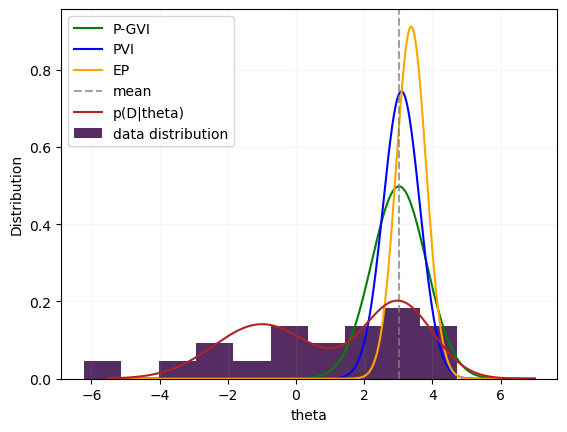

In [214]:
x = np.linspace(-5.5, 7, 1000)

plt.plot(x, Normal(q_new_ar["loc"].detach().squeeze().numpy(), q_new_ar["var"].detach().squeeze().numpy(), x, 1),
         label="P-GVI", color='green')

plt.plot(x, Normal(q_new_["loc"].detach().squeeze().numpy(), q_new_["var"].detach().squeeze().numpy(), x, 1),
         label="PVI", color='blue')

plt.plot(x, Normal(q_new_ep_["mean"], q_new_ep_["variance"], x, 1), 
         label="EP", color='orange')
plt.axvline(q_new_ar["loc"].detach().squeeze().numpy(),linestyle='--', color ="grey", label = "mean", alpha=.75)
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, w, mean_1d, var_1d, mean2_1d, var2_1d), color="firebrick", label="p(D|theta)")
plt.hist(x_1d, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

In [833]:
q_new_["loc"].detach().squeeze().numpy() - q_new_ar["loc"].detach().squeeze().numpy()

0.07282111343552433

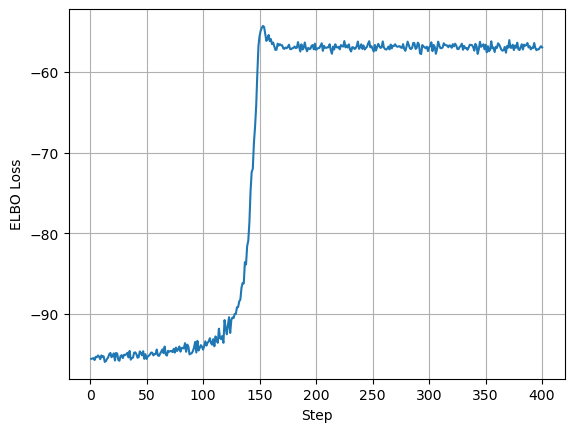

In [201]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_ar["Epochs"]):
    running_total = 0.
    for j in range((i* parameters_ar["N"]),((i+1)* parameters_ar["N"])):
         running_total += q_new_ar["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

## Comparing PVI results with the number of clients

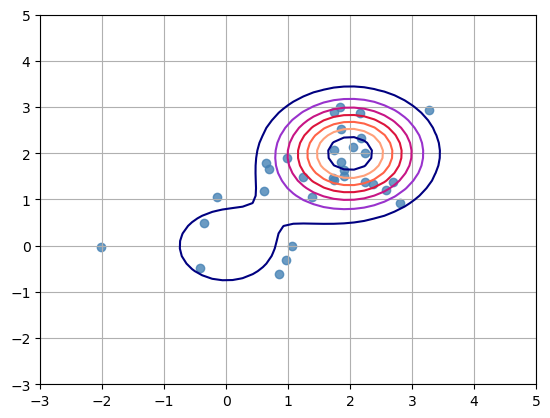

In [978]:
#Defining the model and sampling data points
D = 2

mean_1_mult2 = 2.*torch.ones(D)
var_1_mult2 = .5*torch.eye(D)
mean_2_mult2 = torch.zeros(D)
var_2_mult2 = torch.eye(D)
w_mult = 0.25

samples_ = Gaussian.SampleFromMixture([mean_1_mult2,mean_2_mult2], [var_1_mult2,var_2_mult2], torch.tensor([.75,.25]), 32)

x = y = np.linspace(-3,5)
X_, Y_ = np.meshgrid(x, y)

Z_ = Mixture([X_, Y_], 0.25, [2.,2.], .5, [0.,0.], 1., 2)

plt.contour(X_,Y_,Z_, colors=cmap1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
plt.scatter(samples_[:,0], samples_[:,1], c="steelblue", alpha=.8)
plt.grid(visible=True)


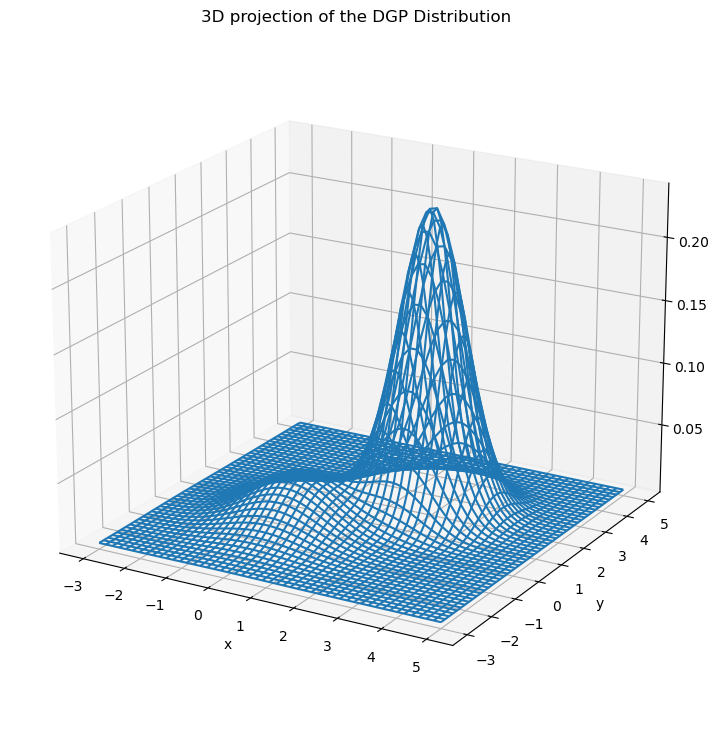

In [979]:
fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection='3d')
ax.view_init(elev=20, azim=-60, roll=0)
w = ax.plot_wireframe(X_,Y_,Z_, )
ax.set_title("3D projection of the DGP Distribution")
ax.set_xlabel("x")
ax.set_ylabel("y")
#ax.set_zlabel("Distribution")
plt.show()

In [980]:
samples_1 = homogeneous_split(samples_, 1)
samples_2 = homogeneous_split(samples_, 2)
samples_4 = homogeneous_split(samples_, 4)
samples_8 = homogeneous_split(samples_, 8)
samples_16 = homogeneous_split(samples_, 16)
samples_32 = homogeneous_split(samples_, 32)

samples_list = [samples_1, samples_2, samples_4, samples_8, samples_16, samples_32]

In [984]:
parameters_base = {
    "w": torch.tensor(0.25),
    "a": torch.tensor([1.]),
    "b": torch.tensor([100.]),
    "D": 2,
    "N": 32,
    "Epochs": 80,
    "Divergence": "KLD",
    "lr": 0.02,
    "samples": 50,
    "optim_epochs": 30
}

q_global_base = {
    "loc": torch.nn.Parameter(torch.tensor([0.,0.])),
    "var": torch.nn.Parameter(torch.tensor([100.])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_base = {
        "client_idx": None,
        "x_n": None,
        "mean": torch.tensor([0., 0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([1.]),
        "noise_m": torch.tensor([0., 0.]),
        "noise_v": parameters_base["a"],
        "spherical": True,
        "require_s_n": False
    }

In [985]:
clients_1 = []
clients_2 = []
clients_4 = []
clients_8 = []
clients_16 = []
clients_32 = []

client_list = [clients_1, clients_2, clients_4, clients_8, clients_16, clients_32]

q_1 = copy.deepcopy(q_global_base)
q_2 = copy.deepcopy(q_global_base)
q_4 = copy.deepcopy(q_global_base)
q_8 = copy.deepcopy(q_global_base)
q_16 = copy.deepcopy(q_global_base)
q_32 = copy.deepcopy(q_global_base)

nums = [1,2,4,8,16,32]


for i in range(len(nums)):
    for j in range(nums[i]):
        temp = copy.deepcopy(clients_base)
        temp.update({'client_idx': j, 'x_n': samples_list[i][j]})
        client_list[i].append(temp)
        
q_ar_1 = copy.deepcopy(q_1)
q_ar_8 = copy.deepcopy(q_8)
q_ar_32 = copy.deepcopy(q_32)

client_ar_1 = copy.deepcopy(client_list[0])
client_ar_8 = copy.deepcopy(client_list[3])
client_ar_32 = copy.deepcopy(client_list[5])

In [986]:
parameters_base.update({"optim_epochs": 256})
q_new_1_c, t_new_1_c = PartitionedVariationalInference(q_1, client_list[0], parameters_base)
parameters_base.update({"optim_epochs": 128})
q_new_2_c, t_new_2_c = PartitionedVariationalInference(q_2, client_list[1], parameters_base)
parameters_base.update({"optim_epochs": 64})
q_new_4_c, t_new_4_c = PartitionedVariationalInference(q_4, client_list[2], parameters_base)
parameters_base.update({"optim_epochs": 32})
q_new_8_c, t_new_8_c = PartitionedVariationalInference(q_8, client_list[3], parameters_base)
parameters_base.update({"optim_epochs": 16})
q_new_16_c, t_new_16_c = PartitionedVariationalInference(q_16, client_list[4], parameters_base)
parameters_base.update({"optim_epochs": 8})
q_new_32_c, t_new_32_c = PartitionedVariationalInference(q_32, client_list[5], parameters_base)

Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([0.1265, 0.6638], requires_grad=True) 
 var:  Parameter containing:
tensor([95.4245], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([0.0419, 0.6645], requires_grad=True) 
 var:  Parameter containing:
tensor([90.6262], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([0.2439, 0.9986], requires_grad=True) 
 var:  Parameter containing:
tensor([85.9856], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([0.9334, 1.3440], requires_grad=True) 
 var:  Parameter containing:
tensor([81.0792], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([1.1703, 1.7348], requires_grad=True) 
 var:  Parameter

New global q: 
 loc:  Parameter containing:
tensor([1.8330, 1.7676], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0531], requires_grad=True)
Iteration 40:
New global q: 
 loc:  Parameter containing:
tensor([1.7878, 1.7688], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0368], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([1.8150, 1.7459], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0573], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([1.8183, 1.7511], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0466], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([1.8120, 1.7720], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0368], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([1.7813, 1.7469], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0389], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.8089, 1.7259], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0509], requires_grad=True)
Iteration 79:
New global q: 
 loc:  Parameter containing:
tensor([1.8134, 1.7553], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0445], requires_grad=True)
Iteration 80:
New global q: 
 loc:  Parameter containing:
tensor([1.8075, 1.7305], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0345], requires_grad=True)
Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([0.3855, 0.3500], requires_grad=True) 
 var:  Parameter containing:
tensor([95.5224], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([0.8073, 0.5406], requires_grad=True) 
 var:  Parameter containing:
t

New global q: 
 loc:  Parameter containing:
tensor([1.8005, 1.7548], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0479], requires_grad=True)
Iteration 37:
New global q: 
 loc:  Parameter containing:
tensor([1.8019, 1.7606], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0438], requires_grad=True)
Iteration 38:
New global q: 
 loc:  Parameter containing:
tensor([1.7825, 1.7751], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0466], requires_grad=True)
Iteration 39:
New global q: 
 loc:  Parameter containing:
tensor([1.7943, 1.7628], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0459], requires_grad=True)
Iteration 40:
New global q: 
 loc:  Parameter containing:
tensor([1.7891, 1.7684], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0550], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([1.8157, 1.7688], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0425], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.8083, 1.7606], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0396], requires_grad=True)
Iteration 76:
New global q: 
 loc:  Parameter containing:
tensor([1.8207, 1.7636], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0443], requires_grad=True)
Iteration 77:
New global q: 
 loc:  Parameter containing:
tensor([1.8154, 1.7560], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0367], requires_grad=True)
Iteration 78:
New global q: 
 loc:  Parameter containing:
tensor([1.7952, 1.7845], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0390], requires_grad=True)
Iteration 79:
New global q: 
 loc:  Parameter containing:
tensor([1.8072, 1.7350], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0501], requires_grad=True)
Iteration 80:
New global q: 
 loc:  Parameter containing:
tensor([1.7909, 1.7576], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0372], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.8046, 1.7604], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0445], requires_grad=True)
Iteration 34:
New global q: 
 loc:  Parameter containing:
tensor([1.8091, 1.7732], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0438], requires_grad=True)
Iteration 35:
New global q: 
 loc:  Parameter containing:
tensor([1.8139, 1.7666], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0615], requires_grad=True)
Iteration 36:
New global q: 
 loc:  Parameter containing:
tensor([1.8172, 1.7494], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0418], requires_grad=True)
Iteration 37:
New global q: 
 loc:  Parameter containing:
tensor([1.8115, 1.7465], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0450], requires_grad=True)
Iteration 38:
New global q: 
 loc:  Parameter containing:
tensor([1.8154, 1.7825], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0466], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.7921, 1.7493], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0438], requires_grad=True)
Iteration 73:
New global q: 
 loc:  Parameter containing:
tensor([1.8045, 1.7367], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0427], requires_grad=True)
Iteration 74:
New global q: 
 loc:  Parameter containing:
tensor([1.8208, 1.7808], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0471], requires_grad=True)
Iteration 75:
New global q: 
 loc:  Parameter containing:
tensor([1.8012, 1.7588], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0452], requires_grad=True)
Iteration 76:
New global q: 
 loc:  Parameter containing:
tensor([1.8211, 1.7659], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0437], requires_grad=True)
Iteration 77:
New global q: 
 loc:  Parameter containing:
tensor([1.7933, 1.7504], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0452], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.8147, 1.7625], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0622], requires_grad=True)
Iteration 31:
New global q: 
 loc:  Parameter containing:
tensor([1.8137, 1.7459], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0455], requires_grad=True)
Iteration 32:
New global q: 
 loc:  Parameter containing:
tensor([1.8208, 1.7498], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0493], requires_grad=True)
Iteration 33:
New global q: 
 loc:  Parameter containing:
tensor([1.8198, 1.7807], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0590], requires_grad=True)
Iteration 34:
New global q: 
 loc:  Parameter containing:
tensor([1.8147, 1.7560], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0409], requires_grad=True)
Iteration 35:
New global q: 
 loc:  Parameter containing:
tensor([1.8072, 1.7268], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0562], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.8273, 1.7693], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0560], requires_grad=True)
Iteration 70:
New global q: 
 loc:  Parameter containing:
tensor([1.8116, 1.7596], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0427], requires_grad=True)
Iteration 71:
New global q: 
 loc:  Parameter containing:
tensor([1.7815, 1.7485], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0468], requires_grad=True)
Iteration 72:
New global q: 
 loc:  Parameter containing:
tensor([1.8004, 1.7351], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0549], requires_grad=True)
Iteration 73:
New global q: 
 loc:  Parameter containing:
tensor([1.8357, 1.7533], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0521], requires_grad=True)
Iteration 74:
New global q: 
 loc:  Parameter containing:
tensor([1.8186, 1.7706], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0471], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.8022, 1.7482], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0574], requires_grad=True)
Iteration 28:
New global q: 
 loc:  Parameter containing:
tensor([1.8241, 1.7569], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0650], requires_grad=True)
Iteration 29:
New global q: 
 loc:  Parameter containing:
tensor([1.8255, 1.7186], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0704], requires_grad=True)
Iteration 30:
New global q: 
 loc:  Parameter containing:
tensor([1.8047, 1.7807], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0528], requires_grad=True)
Iteration 31:
New global q: 
 loc:  Parameter containing:
tensor([1.8211, 1.7304], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0802], requires_grad=True)
Iteration 32:
New global q: 
 loc:  Parameter containing:
tensor([1.7915, 1.7527], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0793], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.8219, 1.7605], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0679], requires_grad=True)
Iteration 67:
New global q: 
 loc:  Parameter containing:
tensor([1.8180, 1.7958], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0736], requires_grad=True)
Iteration 68:
New global q: 
 loc:  Parameter containing:
tensor([1.8003, 1.7551], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0594], requires_grad=True)
Iteration 69:
New global q: 
 loc:  Parameter containing:
tensor([1.8533, 1.7988], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0681], requires_grad=True)
Iteration 70:
New global q: 
 loc:  Parameter containing:
tensor([1.8142, 1.7568], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0721], requires_grad=True)
Iteration 71:
New global q: 
 loc:  Parameter containing:
tensor([1.8044, 1.7159], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0664], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.7320, 1.7746], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0766], requires_grad=True)
Iteration 25:
New global q: 
 loc:  Parameter containing:
tensor([1.8380, 1.8085], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0705], requires_grad=True)
Iteration 26:
New global q: 
 loc:  Parameter containing:
tensor([1.7675, 1.7723], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0618], requires_grad=True)
Iteration 27:
New global q: 
 loc:  Parameter containing:
tensor([1.8347, 1.7184], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1052], requires_grad=True)
Iteration 28:
New global q: 
 loc:  Parameter containing:
tensor([1.8190, 1.7270], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0940], requires_grad=True)
Iteration 29:
New global q: 
 loc:  Parameter containing:
tensor([1.8244, 1.7755], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0752], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.8097, 1.7597], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0744], requires_grad=True)
Iteration 64:
New global q: 
 loc:  Parameter containing:
tensor([1.8015, 1.7238], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0540], requires_grad=True)
Iteration 65:
New global q: 
 loc:  Parameter containing:
tensor([1.7994, 1.8606], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1529], requires_grad=True)
Iteration 66:
New global q: 
 loc:  Parameter containing:
tensor([1.8098, 1.7819], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0913], requires_grad=True)
Iteration 67:
New global q: 
 loc:  Parameter containing:
tensor([1.8596, 1.7434], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0536], requires_grad=True)
Iteration 68:
New global q: 
 loc:  Parameter containing:
tensor([1.8081, 1.7130], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0634], requires_grad=

In [987]:
parameters_base.update({"Divergence": "AR", "optim_epochs": 256, "alpha": 0.5})
q_new_1_ar, t_new_1_ar = PartitionedVariationalInference(q_ar_1, client_ar_1, parameters_base)
parameters_base.update({"optim_epochs": 32})
q_new_8_ar, t_new_8_ar = PartitionedVariationalInference(q_ar_8, client_ar_8, parameters_base)
parameters_base.update({"optim_epochs": 8})
q_new_32_ar, t_new_32_ar = PartitionedVariationalInference(q_ar_32, client_ar_32, parameters_base)

Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([0.4561, 0.2931], requires_grad=True) 
 var:  Parameter containing:
tensor([95.2526], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([0.7268, 0.1140], requires_grad=True) 
 var:  Parameter containing:
tensor([90.4430], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([1.1106, 0.3823], requires_grad=True) 
 var:  Parameter containing:
tensor([85.7757], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([1.1517, 0.6473], requires_grad=True) 
 var:  Parameter containing:
tensor([80.9258], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([0.9498, 1.1871], requires_grad=True) 
 var:  Parameter

New global q: 
 loc:  Parameter containing:
tensor([1.8221, 1.7738], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0935], requires_grad=True)
Iteration 40:
New global q: 
 loc:  Parameter containing:
tensor([1.8244, 1.7644], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0850], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([1.8102, 1.7859], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0906], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([1.8135, 1.7546], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0830], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([1.8351, 1.7393], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0946], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([1.8034, 1.7382], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0974], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.8143, 1.7629], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0943], requires_grad=True)
Iteration 79:
New global q: 
 loc:  Parameter containing:
tensor([1.8107, 1.7702], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0823], requires_grad=True)
Iteration 80:
New global q: 
 loc:  Parameter containing:
tensor([1.7964, 1.7531], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1056], requires_grad=True)
Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([0.7484, 0.3603], requires_grad=True) 
 var:  Parameter containing:
tensor([95.3829], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([1.2402, 0.3347], requires_grad=True) 
 var:  Parameter containing:
t

New global q: 
 loc:  Parameter containing:
tensor([1.7883, 1.7400], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0624], requires_grad=True)
Iteration 37:
New global q: 
 loc:  Parameter containing:
tensor([1.7890, 1.7490], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0795], requires_grad=True)
Iteration 38:
New global q: 
 loc:  Parameter containing:
tensor([1.8243, 1.7494], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0791], requires_grad=True)
Iteration 39:
New global q: 
 loc:  Parameter containing:
tensor([1.8045, 1.7499], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0576], requires_grad=True)
Iteration 40:
New global q: 
 loc:  Parameter containing:
tensor([1.8012, 1.7402], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0561], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([1.8085, 1.7786], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0667], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.8203, 1.7763], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0898], requires_grad=True)
Iteration 76:
New global q: 
 loc:  Parameter containing:
tensor([1.8195, 1.7629], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0667], requires_grad=True)
Iteration 77:
New global q: 
 loc:  Parameter containing:
tensor([1.8035, 1.7531], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0680], requires_grad=True)
Iteration 78:
New global q: 
 loc:  Parameter containing:
tensor([1.7973, 1.7634], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0698], requires_grad=True)
Iteration 79:
New global q: 
 loc:  Parameter containing:
tensor([1.8013, 1.7435], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0618], requires_grad=True)
Iteration 80:
New global q: 
 loc:  Parameter containing:
tensor([1.8032, 1.7392], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0644], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.8072, 1.7833], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0963], requires_grad=True)
Iteration 34:
New global q: 
 loc:  Parameter containing:
tensor([1.8220, 1.7781], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0819], requires_grad=True)
Iteration 35:
New global q: 
 loc:  Parameter containing:
tensor([1.8307, 1.7436], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0683], requires_grad=True)
Iteration 36:
New global q: 
 loc:  Parameter containing:
tensor([1.8038, 1.7783], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1327], requires_grad=True)
Iteration 37:
New global q: 
 loc:  Parameter containing:
tensor([1.7905, 1.7578], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1091], requires_grad=True)
Iteration 38:
New global q: 
 loc:  Parameter containing:
tensor([1.8321, 1.7731], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1008], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.8009, 1.7790], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0734], requires_grad=True)
Iteration 73:
New global q: 
 loc:  Parameter containing:
tensor([1.8168, 1.7290], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1354], requires_grad=True)
Iteration 74:
New global q: 
 loc:  Parameter containing:
tensor([1.8112, 1.7858], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0780], requires_grad=True)
Iteration 75:
New global q: 
 loc:  Parameter containing:
tensor([1.8183, 1.7355], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0689], requires_grad=True)
Iteration 76:
New global q: 
 loc:  Parameter containing:
tensor([1.8031, 1.7555], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1206], requires_grad=True)
Iteration 77:
New global q: 
 loc:  Parameter containing:
tensor([1.8540, 1.7556], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0761], requires_grad=

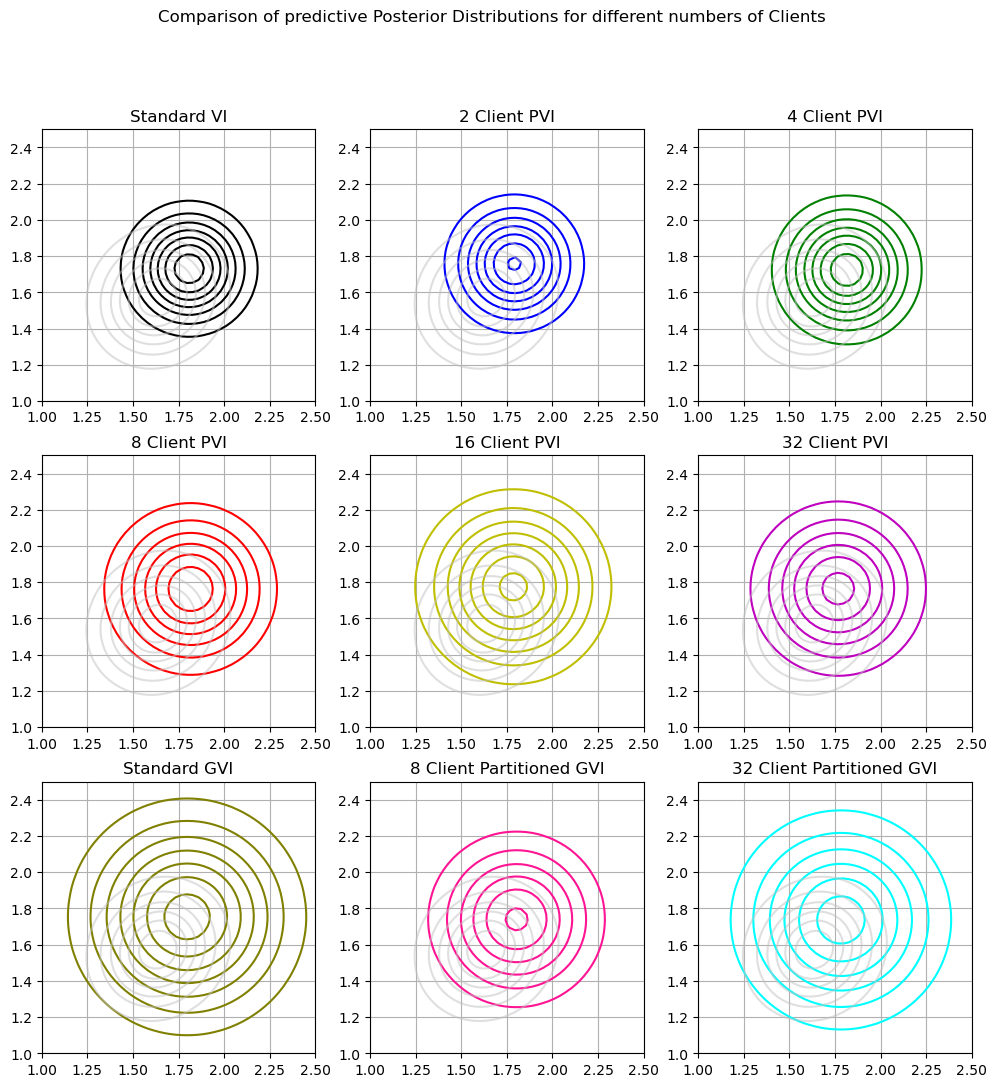

In [993]:
x = np.linspace(1.,2.5)
y = np.linspace(1.,2.5)
X_q, Y_q = np.meshgrid(x, y)

Z_true_h_c = trueDistribution2D(parameters_base, t_new_32_c, 1.,2.5)

Z_pvi_1 = Normal(q_new_1_c["loc"].detach().squeeze().numpy(), q_new_1_c["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters_base["D"])

Z_pvi_2 = Normal(q_new_2_c["loc"].detach().squeeze().numpy(), q_new_2_c["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters_base["D"])

Z_pvi_4 = Normal(q_new_4_c["loc"].detach().squeeze().numpy(), q_new_4_c["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters_base["D"])

Z_pvi_8 = Normal(q_new_8_c["loc"].detach().squeeze().numpy(), q_new_8_c["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters_base["D"])

Z_pvi_16 = Normal(q_new_16_c["loc"].detach().squeeze().numpy(), q_new_16_c["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters_base["D"])

Z_pvi_32 = Normal(q_new_32_c["loc"].detach().squeeze().numpy(), q_new_32_c["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters_base["D"])

Z_gvi_1 = Normal(q_new_1_ar["loc"].detach().squeeze().numpy(), q_new_1_ar["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters_base["D"])

Z_pgvi_8 = Normal(q_new_8_ar["loc"].detach().squeeze().numpy(), q_new_8_ar["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters_base["D"])

Z_pgvi_32 = Normal(q_new_32_ar["loc"].detach().squeeze().numpy(), q_new_32_ar["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters_base["D"])

fig, axs = plt.subplots(3,3, figsize=(12,12))
#fig.figure(figsize=(6,6), dpi=125)
axs[0,0].set_title("Standard VI")
axs[0,0].contour(X_q,Y_q,Z_pvi_1, colors = 'k', alpha=1)
axs[0,0].grid(visible=True)
axs[0,1].set_title("2 Client PVI")
axs[0,1].contour(X_q,Y_q,Z_pvi_2, colors = 'b', alpha=1)
axs[0,1].grid(visible=True)
axs[0,2].set_title("4 Client PVI")
axs[0,2].contour(X_q,Y_q,Z_pvi_4, colors = 'g', alpha=1)
axs[0,2].grid(visible=True)
axs[1,0].set_title("8 Client PVI")
axs[1,0].contour(X_q,Y_q,Z_pvi_8, colors = 'r', alpha=1)
axs[1,0].grid(visible=True)
axs[1,1].set_title("16 Client PVI")
axs[1,1].contour(X_q,Y_q,Z_pvi_16, colors = 'y', alpha=1)
axs[1,1].grid(visible=True)
axs[1,2].set_title("32 Client PVI")
axs[1,2].contour(X_q,Y_q,Z_pvi_32, colors = 'm', alpha=1)
axs[1,2].grid(visible=True)
axs[2,0].set_title("Standard GVI")
axs[2,0].contour(X_q,Y_q,Z_gvi_1, colors = 'olive', alpha=1)
axs[2,0].grid(visible=True)
axs[2,1].set_title("8 Client Partitioned GVI")
axs[2,1].contour(X_q,Y_q,Z_pgvi_8, colors = 'deeppink', alpha=1)
axs[2,1].grid(visible=True)
axs[2,2].set_title("32 Client Partitioned GVI")
axs[2,2].contour(X_q,Y_q,Z_pgvi_32, colors = 'cyan', alpha=1)
axs[2,2].grid(visible=True)

for i in range(3):
    for j in range(3):
        axs[i,j].contour(X_q,Y_q,Z_true_h_c, colors='silver', alpha=.5)
        
fig.suptitle("Comparison of predictive Posterior Distributions for different numbers of Clients")
plt.savefig("Number_of_Clients_and_PGVI_posteriors.png")
plt.show()

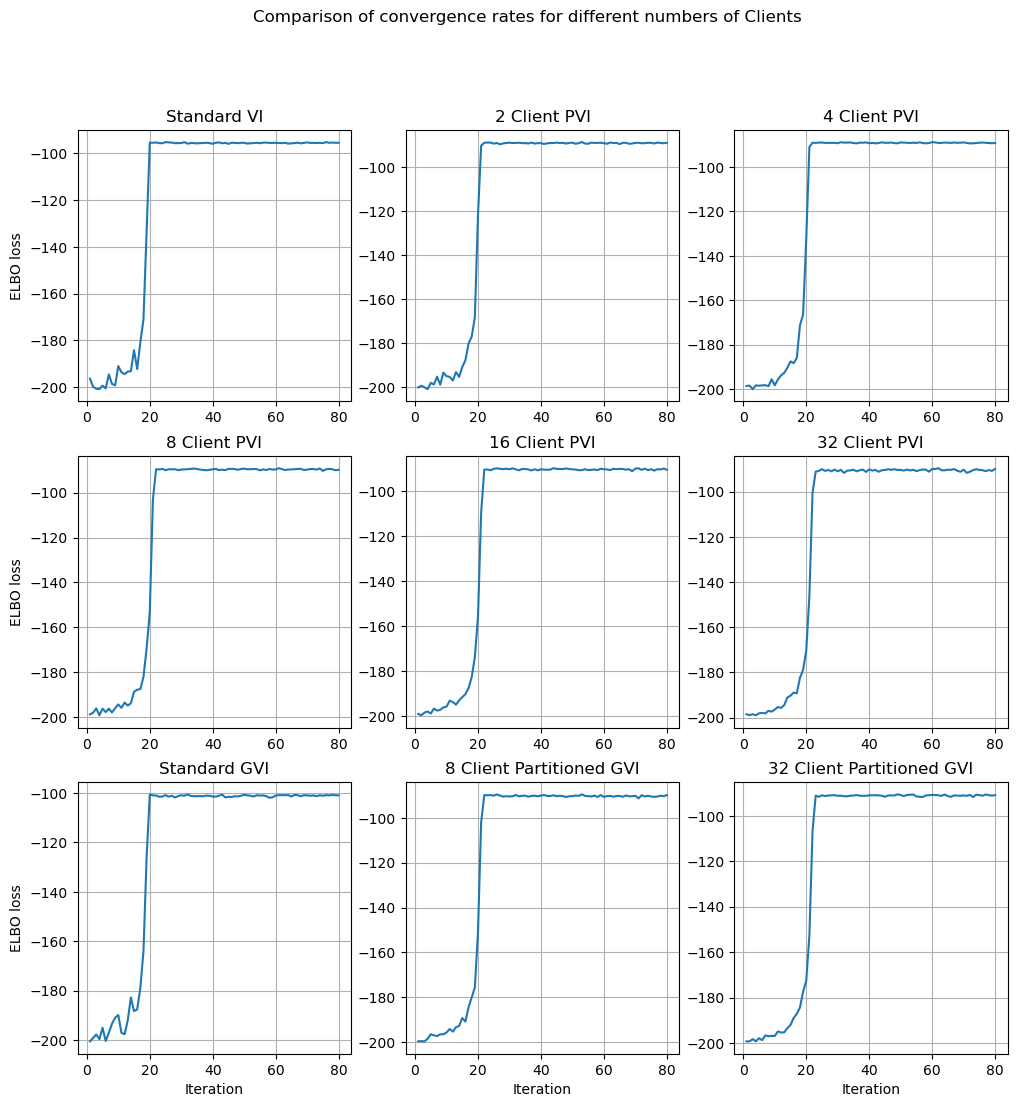

In [991]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}

gm_2 = copy.deepcopy(global_metrics)
gm_4 = copy.deepcopy(global_metrics)
gm_8 = copy.deepcopy(global_metrics)
gm_16 = copy.deepcopy(global_metrics)
gm_32 = copy.deepcopy(global_metrics)
gm_gvi_8 = copy.deepcopy(global_metrics)
gm_gvi_32 = copy.deepcopy(global_metrics)

for i in range(80):
    running_total = 0.
    for j in range((i* 2),((i+1)* 2)):
        running_total += q_new_2_c["metrics"]["elbos"][j]      
    gm_2["elbos"].append(running_total)
    running_total = 0.
    for j in range((i* 4),((i+1)* 4)):
        running_total += q_new_4_c["metrics"]["elbos"][j]      
    gm_4["elbos"].append(running_total)
    running_total = 0.
    running_total_2 = 0.
    for j in range((i* 8),((i+1)* 8)):
        running_total += q_new_8_c["metrics"]["elbos"][j]
        running_total_2 += q_new_8_ar["metrics"]["elbos"][j]
    gm_8["elbos"].append(running_total)
    gm_gvi_8["elbos"].append(running_total_2)
    running_total = 0.
    for j in range((i* 16),((i+1)* 16)):
        running_total += q_new_16_c["metrics"]["elbos"][j]
    gm_16["elbos"].append(running_total)
    running_total = 0.
    running_total_2 = 0.
    for j in range((i* 32),((i+1)* 32)):
        running_total += q_new_32_c["metrics"]["elbos"][j]
        running_total_2 += q_new_32_ar["metrics"]["elbos"][j]
    gm_32["elbos"].append(running_total)
    gm_gvi_32["elbos"].append(running_total_2)

x_vals = np.arange(1, (80+1))

fig, axs = plt.subplots(3,3, figsize=(12,12))
#fig.figure(figsize=(6,6), dpi=125)
axs[0,0].set_title("Standard VI")
axs[0,0].plot(x_vals, q_new_1_c["metrics"]["elbos"])
axs[0,0].grid(visible=True)
axs[0,1].set_title("2 Client PVI")
axs[0,1].plot(x_vals, gm_2["elbos"])
axs[0,1].grid(visible=True)
axs[0,2].set_title("4 Client PVI")
axs[0,2].plot(x_vals, gm_4["elbos"])
axs[0,2].grid(visible=True)
axs[1,0].set_title("8 Client PVI")
axs[1,0].plot(x_vals, gm_8["elbos"])
axs[1,0].grid(visible=True)
axs[1,1].set_title("16 Client PVI")
axs[1,1].plot(x_vals, gm_16["elbos"])
axs[1,1].grid(visible=True)
axs[1,2].set_title("32 Client PVI")
axs[1,2].plot(x_vals, gm_32["elbos"])
axs[1,2].grid(visible=True)
axs[2,0].set_title("Standard GVI")
axs[2,0].plot(x_vals, q_new_1_ar["metrics"]["elbos"][:100])
axs[2,0].grid(visible=True)
axs[2,1].set_title("8 Client Partitioned GVI")
axs[2,1].plot(x_vals, gm_gvi_8["elbos"])
axs[2,1].grid(visible=True)
axs[2,2].set_title("32 Client Partitioned GVI")
axs[2,2].plot(x_vals, gm_gvi_32["elbos"])
axs[2,2].grid(visible=True)
fig.suptitle("Comparison of convergence rates for different numbers of Clients")

i = 0
for ax in axs.flat:
    if i % 3 == 0:
        ax.set(ylabel='ELBO loss')
    if i > 5:
        ax.set(xlabel='Iteration')
    i += 1
plt.savefig("Number_of_Clients_and_PGVI_Elbos.png")

### Gamma Divergence Partitioned GVI

In [1024]:
parameters_gamma = {
    "w": torch.tensor(0.25),
    "a": torch.tensor([1.]),
    "b": torch.tensor([100.]),
    "D": 2,
    "N": 32,
    "Epochs": 80,
    "Divergence": "G",
    "lr": 0.02,
    "samples": 50,
    "optim_epochs": 16,
    "gamma": 1.25
}

q_global_gamma = {
    "loc": torch.nn.Parameter(torch.tensor([0.,0.])),
    "var": torch.nn.Parameter(torch.tensor([100.])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_gamma_16 = []

clients_gamma_base = {
        "client_idx": None,
        "x_n": None,
        "mean": torch.tensor([0., 0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([1.]),
        "noise_m": torch.tensor([0., 0.]),
        "noise_v": parameters_gamma["a"],
        "spherical": True,
        "require_s_n": False
    }

for j in range(16):
    temp = copy.deepcopy(clients_gamma_base)
    temp.update({'client_idx': j, 'x_n': samples_list[4][j]})
    clients_gamma_16.append(temp)

In [1025]:
q_new_16_g, t_new_16_g = PartitionedVariationalInference(q_global_gamma, clients_gamma_16, parameters_gamma)

Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([0.6158, 0.0896], requires_grad=True) 
 var:  Parameter containing:
tensor([94.8799], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([1.5179, 0.3705], requires_grad=True) 
 var:  Parameter containing:
tensor([89.7579], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([2.0775, 0.9320], requires_grad=True) 
 var:  Parameter containing:
tensor([84.6366], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([2.0642, 1.3972], requires_grad=True) 
 var:  Parameter containing:
tensor([79.5167], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([1.4167, 1.2793], requires_grad=True) 
 var:  Parameter

New global q: 
 loc:  Parameter containing:
tensor([1.9933, 1.6888], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0721], requires_grad=True)
Iteration 39:
New global q: 
 loc:  Parameter containing:
tensor([1.9994, 1.6703], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0203], requires_grad=True)
Iteration 40:
New global q: 
 loc:  Parameter containing:
tensor([2.0016, 1.7017], requires_grad=True) 
 var:  Parameter containing:
tensor([-0.0461], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([1.9880, 1.7114], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0414], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([2.0224, 1.7138], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0594], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([1.9944, 1.6803], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0070], requires_grad

New global q: 
 loc:  Parameter containing:
tensor([2.0892, 1.5995], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0198], requires_grad=True)
Iteration 78:
New global q: 
 loc:  Parameter containing:
tensor([2.0262, 1.6896], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0470], requires_grad=True)
Iteration 79:
New global q: 
 loc:  Parameter containing:
tensor([2.0456, 1.6072], requires_grad=True) 
 var:  Parameter containing:
tensor([-0.0273], requires_grad=True)
Iteration 80:
New global q: 
 loc:  Parameter containing:
tensor([2.0370, 1.6146], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0303], requires_grad=True)


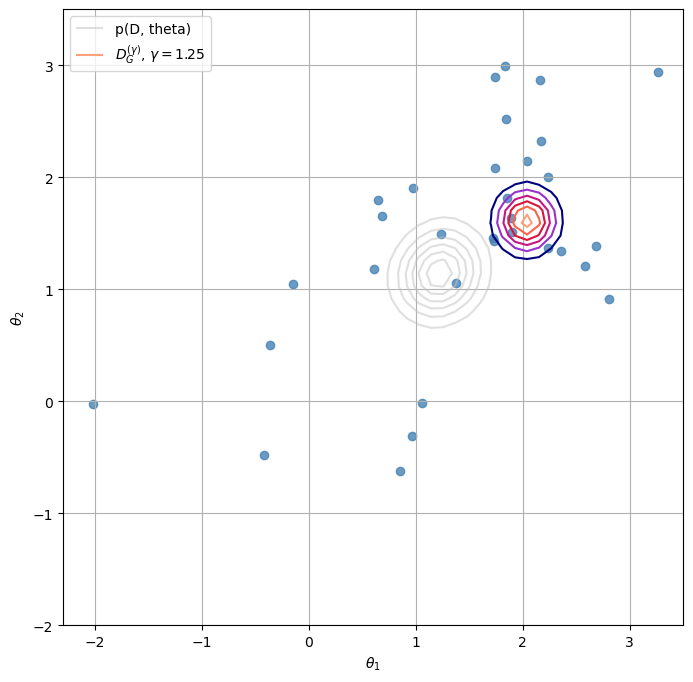

In [1026]:
x = np.linspace(-2.,3.5)
y = np.linspace(-2.,3.5)
X_q, Y_q = np.meshgrid(x, y)

plt.figure(figsize=(8,8))
Z_true_h_c = trueDistribution2D(parameters_base, t_new_32_c, -1.,3.5)

Z_gvi_g = Normal(q_new_16_g["loc"].detach().squeeze().numpy(), np.absolute(q_new_16_g["var"].detach().squeeze().numpy()), 
              [X_q, Y_q], parameters_base["D"])



c1 = plt.contour(X_q,Y_q,Z_true_h_c, colors='silver', alpha=.5)

c2 = plt.contour(X_q,Y_q,Z_gvi_g, colors = cmap1)

#plt.scatter(x_,y_,color="firebrick")
h1,_=c1.legend_elements()
h2,_=c2.legend_elements()
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
#fig.set_title("Gamma Divergence Partitioned GVI")
plt.legend([h1[0],h2[0]], ["p(D, theta)", r"$D_G^{(\gamma)}$, $\gamma=1.25$"], loc="upper left")
plt.scatter(samples_[:,0], samples_[:,1], c="steelblue", alpha=.8)
plt.grid(visible=True)
plt.show()

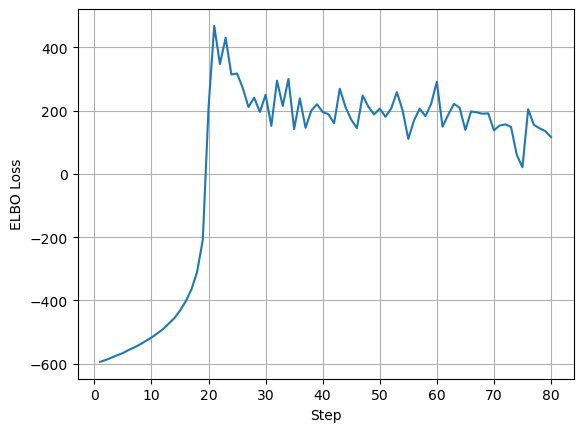

In [1027]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_gamma["Epochs"]):
    running_total = 0.
    kls = 0.
    lls = 0.
    for j in range((i* 16),((i+1)* 16)):
        running_total += q_new_16_g["metrics"]["elbos"][j]
        kls += q_new_16_g["metrics"]["kls"][j]  
        lls += q_new_16_g["metrics"]["lls"][j]  
    global_metrics["elbos"].append(running_total)
    global_metrics["kls"].append(kls)
    global_metrics["lls"].append(lls)
plot_training(global_metrics["elbos"])

## Effect of different Priors on PVI and PGVI

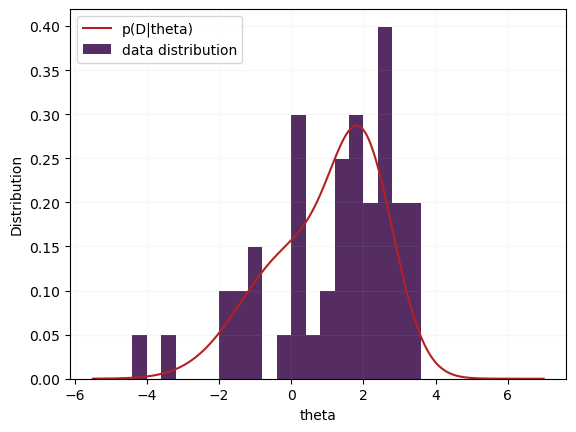

In [478]:
#Defining the model and sampling data points

mean_1_uni_ar = torch.tensor([2.])
var_1_uni_ar = torch.tensor([0.75])
mean_2_uni_ar = torch.tensor([0.])
var_2_uni_ar = torch.tensor([2.])

samples_uni_ar = Gaussian.SampleFromMixture([mean_1_uni_ar,mean_2_uni_ar], 
                                            [var_1_uni_ar,var_2_uni_ar], torch.tensor([.5,.5]), 50)
samples_per_c = homogeneous_split(samples_uni_ar, 10)

x = np.linspace(-5.5, 7, 1000)

plt.plot(x, Mix(x, 0.5, 2., 0.75, 0., 2.), color="firebrick", label="p(D|theta)")
plt.hist(samples_uni_ar.numpy(), density=True, bins=20, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

In [1194]:
parameters_pi = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([2.]),
    "b": torch.tensor([100.]),
    "D": 1,
    "N": 20,
    "Epochs": 35,
    "Divergence": "AR",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30,
    "alpha":0.5
}

q_global_pi_3 = {
    "loc": torch.nn.Parameter(torch.tensor([3.])),
    "var": torch.nn.Parameter(torch.tensor([20.])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}
q_global_pi_5 = {
    "loc": torch.nn.Parameter(torch.tensor([-5.])),
    "var": torch.nn.Parameter(torch.tensor([20.])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}
q_global_pi_20 = {
    "loc": torch.nn.Parameter(torch.tensor([20.])),
    "var": torch.nn.Parameter(torch.tensor([20.])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}
q_global_pi_25 = {
    "loc": torch.nn.Parameter(torch.tensor([21.])),
    "var": torch.nn.Parameter(torch.tensor([20.])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}
q_global_pi_30 = {
    "loc": torch.nn.Parameter(torch.tensor([22.5])),
    "var": torch.nn.Parameter(torch.tensor([20.])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}
q_global_pi_40 = {
    "loc": torch.nn.Parameter(torch.tensor([30.])),
    "var": torch.nn.Parameter(torch.tensor([20.])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}
q_global_pi_50 = {
    "loc": torch.nn.Parameter(torch.tensor([50.])),
    "var": torch.nn.Parameter(torch.tensor([100.])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_pi = []
for i in range(10):
    clients_pi.append({
        "client_idx": i,
        "x_n": samples_per_c[i],
        "mean": torch.tensor([50.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": var_1_uni,
        "noise_m": torch.tensor([0.]),
        "noise_v": parameters_pi["a"],
        "spherical": True,
        "require_s_n": False
    })
clients_pi_3 = copy.deepcopy(clients_pi)
clients_pi_5 = copy.deepcopy(clients_pi)
clients_pi_20 = copy.deepcopy(clients_pi)
clients_pi_25 = copy.deepcopy(clients_pi)
clients_pi_30 = copy.deepcopy(clients_pi)
clients_pi_40 = copy.deepcopy(clients_pi)
clients_pi_50 = copy.deepcopy(clients_pi)

In [830]:
q_new_pi_3, _ = PartitionedVariationalInference(q_global_pi_3, clients_pi_3, parameters_pi, is_1d=True)
parameters_pi.update({"optim_epochs": 50, "lr": 0.01, "Epochs": 50})
q_new_pi_5, _ = PartitionedVariationalInference(q_global_pi_5, clients_pi_5, parameters_pi, is_1d=True)
parameters_pi.update({"optim_epochs": 60, "lr": 0.01, "Epochs": 200, "alpha":0.5})
q_new_pi_20, _ = PartitionedVariationalInference(q_global_pi_20, clients_pi_20, parameters_pi, is_1d=True)
parameters_pi.update({"optim_epochs": 75, "lr": 0.1, "Epochs": 200})
q_new_pi_50, _ = PartitionedVariationalInference(q_global_pi_50, clients_pi_50, parameters_pi, is_1d=True)

Starting global q:  {'loc': Parameter containing:
tensor([50.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([47.8184], requires_grad=True) 
 var:  Parameter containing:
tensor([101.8533], requires_grad=True)
Iteration 2:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([52.2641], requires_grad=True) 
 var:  Parameter containing:
tensor([95.3966], requires_grad=True)
Iteration 3:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([50.9309], requires_grad=True) 
 var:  Parameter containing:
tensor([91.1853], requires_grad=True)
Iteration 4:
Client 0
Client 1
Client 2
Cl

Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([49.6372], requires_grad=True) 
 var:  Parameter containing:
tensor([53.2245], requires_grad=True)
Iteration 29:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([48.3266], requires_grad=True) 
 var:  Parameter containing:
tensor([51.6661], requires_grad=True)
Iteration 30:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([47.9038], requires_grad=True) 
 var:  Parameter containing:
tensor([48.3298], requires_grad=True)
Iteration 31:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([48.1889], requires_grad=True) 
 var:  Parameter containing:
tensor([47.4590], requires_grad=True)
Iterati

Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([44.6610], requires_grad=True) 
 var:  Parameter containing:
tensor([55.9232], requires_grad=True)
Iteration 57:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([47.2936], requires_grad=True) 
 var:  Parameter containing:
tensor([54.6001], requires_grad=True)
Iteration 58:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([48.4147], requires_grad=True) 
 var:  Parameter containing:
tensor([55.3045], requires_grad=True)
Iteration 59:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([47.3695], requires_grad=True) 
 var:  Parameter containing:
tensor([55.5750], requires_grad=True)
Iterati

Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([48.2952], requires_grad=True) 
 var:  Parameter containing:
tensor([52.3311], requires_grad=True)
Iteration 85:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([48.6961], requires_grad=True) 
 var:  Parameter containing:
tensor([51.1814], requires_grad=True)
Iteration 86:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([47.6745], requires_grad=True) 
 var:  Parameter containing:
tensor([52.0022], requires_grad=True)
Iteration 87:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([45.9754], requires_grad=True) 
 var:  Parameter containing:
tensor([56.9145], requires_grad=True)
Iterati

Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([49.6800], requires_grad=True) 
 var:  Parameter containing:
tensor([59.5773], requires_grad=True)
Iteration 113:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([46.0684], requires_grad=True) 
 var:  Parameter containing:
tensor([63.2350], requires_grad=True)
Iteration 114:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([44.5627], requires_grad=True) 
 var:  Parameter containing:
tensor([67.9895], requires_grad=True)
Iteration 115:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([49.3112], requires_grad=True) 
 var:  Parameter containing:
tensor([62.3598], requires_grad=True)
Iter

Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([47.5604], requires_grad=True) 
 var:  Parameter containing:
tensor([51.2662], requires_grad=True)
Iteration 141:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([46.7288], requires_grad=True) 
 var:  Parameter containing:
tensor([57.0656], requires_grad=True)
Iteration 142:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([48.1274], requires_grad=True) 
 var:  Parameter containing:
tensor([54.5608], requires_grad=True)
Iteration 143:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([46.7659], requires_grad=True) 
 var:  Parameter containing:
tensor([53.6674], requires_grad=True)
Iter

Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([48.2634], requires_grad=True) 
 var:  Parameter containing:
tensor([48.6923], requires_grad=True)
Iteration 169:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([48.4714], requires_grad=True) 
 var:  Parameter containing:
tensor([46.4055], requires_grad=True)
Iteration 170:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([46.9968], requires_grad=True) 
 var:  Parameter containing:
tensor([44.7755], requires_grad=True)
Iteration 171:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([48.6929], requires_grad=True) 
 var:  Parameter containing:
tensor([42.1258], requires_grad=True)
Iter

Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([48.7038], requires_grad=True) 
 var:  Parameter containing:
tensor([50.5341], requires_grad=True)
Iteration 197:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([45.7890], requires_grad=True) 
 var:  Parameter containing:
tensor([56.0474], requires_grad=True)
Iteration 198:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([47.8382], requires_grad=True) 
 var:  Parameter containing:
tensor([54.3167], requires_grad=True)
Iteration 199:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([49.9227], requires_grad=True) 
 var:  Parameter containing:
tensor([54.6340], requires_grad=True)
Iter

In [1195]:
parameters_pi.update({"optim_epochs": 60, "lr": 0.1, "Epochs": 1000, "alpha":0.5})
#q_new_pi_25, _ = PartitionedVariationalInference(q_global_pi_25, clients_pi_25, parameters_pi, is_1d=True)
#q_new_pi_30, _ = PartitionedVariationalInference(q_global_pi_30, clients_pi_30, parameters_pi, is_1d=True)
q_new_pi_40, _ = PartitionedVariationalInference(q_global_pi_40, clients_pi_40, parameters_pi, is_1d=True)


Starting global q:  {'loc': Parameter containing:
tensor([30.], requires_grad=True), 'var': Parameter containing:
tensor([20.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([27.2786], requires_grad=True) 
 var:  Parameter containing:
tensor([23.1619], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([27.3550], requires_grad=True) 
 var:  Parameter containing:
tensor([22.7731], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([28.4387], requires_grad=True) 
 var:  Parameter containing:
tensor([22.2860], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([27.6965], requires_grad=True) 
 var:  Parameter containing:
tensor([23.2101], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([26.2659], requires_grad=True) 
 var:  Parameter containing:
tensor([25.9671], requires

New global q: 
 loc:  Parameter containing:
tensor([27.7114], requires_grad=True) 
 var:  Parameter containing:
tensor([27.3300], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([27.8205], requires_grad=True) 
 var:  Parameter containing:
tensor([26.9246], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([27.2092], requires_grad=True) 
 var:  Parameter containing:
tensor([27.4378], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([28.2267], requires_grad=True) 
 var:  Parameter containing:
tensor([26.7236], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([27.9762], requires_grad=True) 
 var:  Parameter containing:
tensor([24.3032], requires_grad=True)
Iteration 45:
New global q: 
 loc:  Parameter containing:
tensor([27.0122], requires_grad=True) 
 var:  Parameter containing:
tensor([25.8673], requires_grad=True)
Iteration 46:
New global q: 
 

New global q: 
 loc:  Parameter containing:
tensor([27.8066], requires_grad=True) 
 var:  Parameter containing:
tensor([25.7318], requires_grad=True)
Iteration 81:
New global q: 
 loc:  Parameter containing:
tensor([26.4495], requires_grad=True) 
 var:  Parameter containing:
tensor([25.4889], requires_grad=True)
Iteration 82:
New global q: 
 loc:  Parameter containing:
tensor([27.9514], requires_grad=True) 
 var:  Parameter containing:
tensor([29.0871], requires_grad=True)
Iteration 83:
New global q: 
 loc:  Parameter containing:
tensor([27.7823], requires_grad=True) 
 var:  Parameter containing:
tensor([29.1746], requires_grad=True)
Iteration 84:
New global q: 
 loc:  Parameter containing:
tensor([27.9488], requires_grad=True) 
 var:  Parameter containing:
tensor([27.3928], requires_grad=True)
Iteration 85:
New global q: 
 loc:  Parameter containing:
tensor([26.8826], requires_grad=True) 
 var:  Parameter containing:
tensor([27.3021], requires_grad=True)
Iteration 86:
New global q: 
 

New global q: 
 loc:  Parameter containing:
tensor([27.1537], requires_grad=True) 
 var:  Parameter containing:
tensor([27.9990], requires_grad=True)
Iteration 121:
New global q: 
 loc:  Parameter containing:
tensor([28.5564], requires_grad=True) 
 var:  Parameter containing:
tensor([25.9478], requires_grad=True)
Iteration 122:
New global q: 
 loc:  Parameter containing:
tensor([28.2283], requires_grad=True) 
 var:  Parameter containing:
tensor([25.9053], requires_grad=True)
Iteration 123:
New global q: 
 loc:  Parameter containing:
tensor([28.4993], requires_grad=True) 
 var:  Parameter containing:
tensor([23.9622], requires_grad=True)
Iteration 124:
New global q: 
 loc:  Parameter containing:
tensor([25.9294], requires_grad=True) 
 var:  Parameter containing:
tensor([26.0420], requires_grad=True)
Iteration 125:
New global q: 
 loc:  Parameter containing:
tensor([29.5745], requires_grad=True) 
 var:  Parameter containing:
tensor([23.3437], requires_grad=True)
Iteration 126:
New global

New global q: 
 loc:  Parameter containing:
tensor([28.4313], requires_grad=True) 
 var:  Parameter containing:
tensor([26.9016], requires_grad=True)
Iteration 161:
New global q: 
 loc:  Parameter containing:
tensor([27.7701], requires_grad=True) 
 var:  Parameter containing:
tensor([30.4892], requires_grad=True)
Iteration 162:
New global q: 
 loc:  Parameter containing:
tensor([30.0751], requires_grad=True) 
 var:  Parameter containing:
tensor([26.2478], requires_grad=True)
Iteration 163:
New global q: 
 loc:  Parameter containing:
tensor([28.2028], requires_grad=True) 
 var:  Parameter containing:
tensor([25.0040], requires_grad=True)
Iteration 164:
New global q: 
 loc:  Parameter containing:
tensor([27.5075], requires_grad=True) 
 var:  Parameter containing:
tensor([27.1213], requires_grad=True)
Iteration 165:
New global q: 
 loc:  Parameter containing:
tensor([30.0474], requires_grad=True) 
 var:  Parameter containing:
tensor([26.6020], requires_grad=True)
Iteration 166:
New global

New global q: 
 loc:  Parameter containing:
tensor([26.6881], requires_grad=True) 
 var:  Parameter containing:
tensor([28.9385], requires_grad=True)
Iteration 201:
New global q: 
 loc:  Parameter containing:
tensor([28.8614], requires_grad=True) 
 var:  Parameter containing:
tensor([28.4467], requires_grad=True)
Iteration 202:
New global q: 
 loc:  Parameter containing:
tensor([28.6898], requires_grad=True) 
 var:  Parameter containing:
tensor([27.4598], requires_grad=True)
Iteration 203:
New global q: 
 loc:  Parameter containing:
tensor([27.4873], requires_grad=True) 
 var:  Parameter containing:
tensor([27.4157], requires_grad=True)
Iteration 204:
New global q: 
 loc:  Parameter containing:
tensor([27.2122], requires_grad=True) 
 var:  Parameter containing:
tensor([29.0256], requires_grad=True)
Iteration 205:
New global q: 
 loc:  Parameter containing:
tensor([27.8415], requires_grad=True) 
 var:  Parameter containing:
tensor([26.9231], requires_grad=True)
Iteration 206:
New global

New global q: 
 loc:  Parameter containing:
tensor([28.2914], requires_grad=True) 
 var:  Parameter containing:
tensor([25.6569], requires_grad=True)
Iteration 241:
New global q: 
 loc:  Parameter containing:
tensor([28.0032], requires_grad=True) 
 var:  Parameter containing:
tensor([28.1057], requires_grad=True)
Iteration 242:
New global q: 
 loc:  Parameter containing:
tensor([27.7163], requires_grad=True) 
 var:  Parameter containing:
tensor([28.7458], requires_grad=True)
Iteration 243:
New global q: 
 loc:  Parameter containing:
tensor([28.5780], requires_grad=True) 
 var:  Parameter containing:
tensor([27.6205], requires_grad=True)
Iteration 244:
New global q: 
 loc:  Parameter containing:
tensor([28.4406], requires_grad=True) 
 var:  Parameter containing:
tensor([27.0462], requires_grad=True)
Iteration 245:
New global q: 
 loc:  Parameter containing:
tensor([29.5293], requires_grad=True) 
 var:  Parameter containing:
tensor([24.0269], requires_grad=True)
Iteration 246:
New global

New global q: 
 loc:  Parameter containing:
tensor([27.7635], requires_grad=True) 
 var:  Parameter containing:
tensor([23.8936], requires_grad=True)
Iteration 281:
New global q: 
 loc:  Parameter containing:
tensor([27.8274], requires_grad=True) 
 var:  Parameter containing:
tensor([24.1294], requires_grad=True)
Iteration 282:
New global q: 
 loc:  Parameter containing:
tensor([27.8001], requires_grad=True) 
 var:  Parameter containing:
tensor([26.9339], requires_grad=True)
Iteration 283:
New global q: 
 loc:  Parameter containing:
tensor([29.2145], requires_grad=True) 
 var:  Parameter containing:
tensor([24.3339], requires_grad=True)
Iteration 284:
New global q: 
 loc:  Parameter containing:
tensor([26.1750], requires_grad=True) 
 var:  Parameter containing:
tensor([26.5316], requires_grad=True)
Iteration 285:
New global q: 
 loc:  Parameter containing:
tensor([28.4101], requires_grad=True) 
 var:  Parameter containing:
tensor([25.0118], requires_grad=True)
Iteration 286:
New global

New global q: 
 loc:  Parameter containing:
tensor([28.0396], requires_grad=True) 
 var:  Parameter containing:
tensor([27.2984], requires_grad=True)
Iteration 321:
New global q: 
 loc:  Parameter containing:
tensor([27.7616], requires_grad=True) 
 var:  Parameter containing:
tensor([25.5938], requires_grad=True)
Iteration 322:
New global q: 
 loc:  Parameter containing:
tensor([27.6920], requires_grad=True) 
 var:  Parameter containing:
tensor([27.6182], requires_grad=True)
Iteration 323:
New global q: 
 loc:  Parameter containing:
tensor([27.8033], requires_grad=True) 
 var:  Parameter containing:
tensor([23.0774], requires_grad=True)
Iteration 324:
New global q: 
 loc:  Parameter containing:
tensor([27.5549], requires_grad=True) 
 var:  Parameter containing:
tensor([24.3620], requires_grad=True)
Iteration 325:
New global q: 
 loc:  Parameter containing:
tensor([29.6612], requires_grad=True) 
 var:  Parameter containing:
tensor([22.3484], requires_grad=True)
Iteration 326:
New global

New global q: 
 loc:  Parameter containing:
tensor([27.6559], requires_grad=True) 
 var:  Parameter containing:
tensor([26.3112], requires_grad=True)
Iteration 361:
New global q: 
 loc:  Parameter containing:
tensor([28.6249], requires_grad=True) 
 var:  Parameter containing:
tensor([24.4202], requires_grad=True)
Iteration 362:
New global q: 
 loc:  Parameter containing:
tensor([27.0257], requires_grad=True) 
 var:  Parameter containing:
tensor([24.2686], requires_grad=True)
Iteration 363:
New global q: 
 loc:  Parameter containing:
tensor([28.8456], requires_grad=True) 
 var:  Parameter containing:
tensor([24.5140], requires_grad=True)
Iteration 364:
New global q: 
 loc:  Parameter containing:
tensor([27.7392], requires_grad=True) 
 var:  Parameter containing:
tensor([27.2620], requires_grad=True)
Iteration 365:
New global q: 
 loc:  Parameter containing:
tensor([29.5316], requires_grad=True) 
 var:  Parameter containing:
tensor([27.3094], requires_grad=True)
Iteration 366:
New global

New global q: 
 loc:  Parameter containing:
tensor([29.1804], requires_grad=True) 
 var:  Parameter containing:
tensor([24.8648], requires_grad=True)
Iteration 401:
New global q: 
 loc:  Parameter containing:
tensor([28.4522], requires_grad=True) 
 var:  Parameter containing:
tensor([25.4203], requires_grad=True)
Iteration 402:
New global q: 
 loc:  Parameter containing:
tensor([27.4306], requires_grad=True) 
 var:  Parameter containing:
tensor([27.2173], requires_grad=True)
Iteration 403:
New global q: 
 loc:  Parameter containing:
tensor([28.5673], requires_grad=True) 
 var:  Parameter containing:
tensor([27.9809], requires_grad=True)
Iteration 404:
New global q: 
 loc:  Parameter containing:
tensor([28.6526], requires_grad=True) 
 var:  Parameter containing:
tensor([25.3321], requires_grad=True)
Iteration 405:
New global q: 
 loc:  Parameter containing:
tensor([27.9671], requires_grad=True) 
 var:  Parameter containing:
tensor([23.9902], requires_grad=True)
Iteration 406:
New global

New global q: 
 loc:  Parameter containing:
tensor([29.0095], requires_grad=True) 
 var:  Parameter containing:
tensor([29.2204], requires_grad=True)
Iteration 441:
New global q: 
 loc:  Parameter containing:
tensor([28.9187], requires_grad=True) 
 var:  Parameter containing:
tensor([24.4683], requires_grad=True)
Iteration 442:
New global q: 
 loc:  Parameter containing:
tensor([27.5907], requires_grad=True) 
 var:  Parameter containing:
tensor([23.9883], requires_grad=True)
Iteration 443:
New global q: 
 loc:  Parameter containing:
tensor([27.8426], requires_grad=True) 
 var:  Parameter containing:
tensor([22.1569], requires_grad=True)
Iteration 444:
New global q: 
 loc:  Parameter containing:
tensor([28.4380], requires_grad=True) 
 var:  Parameter containing:
tensor([21.6875], requires_grad=True)
Iteration 445:
New global q: 
 loc:  Parameter containing:
tensor([27.3578], requires_grad=True) 
 var:  Parameter containing:
tensor([26.3957], requires_grad=True)
Iteration 446:
New global

New global q: 
 loc:  Parameter containing:
tensor([26.9337], requires_grad=True) 
 var:  Parameter containing:
tensor([29.4037], requires_grad=True)
Iteration 481:
New global q: 
 loc:  Parameter containing:
tensor([27.9986], requires_grad=True) 
 var:  Parameter containing:
tensor([28.1776], requires_grad=True)
Iteration 482:
New global q: 
 loc:  Parameter containing:
tensor([27.0915], requires_grad=True) 
 var:  Parameter containing:
tensor([29.8472], requires_grad=True)
Iteration 483:
New global q: 
 loc:  Parameter containing:
tensor([29.6789], requires_grad=True) 
 var:  Parameter containing:
tensor([30.6335], requires_grad=True)
Iteration 484:
New global q: 
 loc:  Parameter containing:
tensor([28.7015], requires_grad=True) 
 var:  Parameter containing:
tensor([27.6362], requires_grad=True)
Iteration 485:
New global q: 
 loc:  Parameter containing:
tensor([27.4045], requires_grad=True) 
 var:  Parameter containing:
tensor([32.6405], requires_grad=True)
Iteration 486:
New global

New global q: 
 loc:  Parameter containing:
tensor([25.1294], requires_grad=True) 
 var:  Parameter containing:
tensor([26.1485], requires_grad=True)
Iteration 521:
New global q: 
 loc:  Parameter containing:
tensor([27.0924], requires_grad=True) 
 var:  Parameter containing:
tensor([28.8854], requires_grad=True)
Iteration 522:
New global q: 
 loc:  Parameter containing:
tensor([29.4285], requires_grad=True) 
 var:  Parameter containing:
tensor([26.8502], requires_grad=True)
Iteration 523:
New global q: 
 loc:  Parameter containing:
tensor([28.8220], requires_grad=True) 
 var:  Parameter containing:
tensor([28.9593], requires_grad=True)
Iteration 524:
New global q: 
 loc:  Parameter containing:
tensor([29.1759], requires_grad=True) 
 var:  Parameter containing:
tensor([28.2645], requires_grad=True)
Iteration 525:
New global q: 
 loc:  Parameter containing:
tensor([27.0507], requires_grad=True) 
 var:  Parameter containing:
tensor([26.4270], requires_grad=True)
Iteration 526:
New global

New global q: 
 loc:  Parameter containing:
tensor([28.4229], requires_grad=True) 
 var:  Parameter containing:
tensor([26.2215], requires_grad=True)
Iteration 561:
New global q: 
 loc:  Parameter containing:
tensor([27.2693], requires_grad=True) 
 var:  Parameter containing:
tensor([25.4578], requires_grad=True)
Iteration 562:
New global q: 
 loc:  Parameter containing:
tensor([27.3688], requires_grad=True) 
 var:  Parameter containing:
tensor([27.0234], requires_grad=True)
Iteration 563:
New global q: 
 loc:  Parameter containing:
tensor([28.7969], requires_grad=True) 
 var:  Parameter containing:
tensor([28.8281], requires_grad=True)
Iteration 564:
New global q: 
 loc:  Parameter containing:
tensor([29.1360], requires_grad=True) 
 var:  Parameter containing:
tensor([28.3612], requires_grad=True)
Iteration 565:
New global q: 
 loc:  Parameter containing:
tensor([27.7328], requires_grad=True) 
 var:  Parameter containing:
tensor([26.8324], requires_grad=True)
Iteration 566:
New global

New global q: 
 loc:  Parameter containing:
tensor([27.3482], requires_grad=True) 
 var:  Parameter containing:
tensor([24.9560], requires_grad=True)
Iteration 601:
New global q: 
 loc:  Parameter containing:
tensor([27.7948], requires_grad=True) 
 var:  Parameter containing:
tensor([23.3748], requires_grad=True)
Iteration 602:
New global q: 
 loc:  Parameter containing:
tensor([26.6599], requires_grad=True) 
 var:  Parameter containing:
tensor([27.1477], requires_grad=True)
Iteration 603:
New global q: 
 loc:  Parameter containing:
tensor([28.4907], requires_grad=True) 
 var:  Parameter containing:
tensor([24.4496], requires_grad=True)
Iteration 604:
New global q: 
 loc:  Parameter containing:
tensor([28.4876], requires_grad=True) 
 var:  Parameter containing:
tensor([23.7955], requires_grad=True)
Iteration 605:
New global q: 
 loc:  Parameter containing:
tensor([28.5536], requires_grad=True) 
 var:  Parameter containing:
tensor([27.1220], requires_grad=True)
Iteration 606:
New global

New global q: 
 loc:  Parameter containing:
tensor([27.0558], requires_grad=True) 
 var:  Parameter containing:
tensor([27.2526], requires_grad=True)
Iteration 641:
New global q: 
 loc:  Parameter containing:
tensor([28.1226], requires_grad=True) 
 var:  Parameter containing:
tensor([26.5171], requires_grad=True)
Iteration 642:
New global q: 
 loc:  Parameter containing:
tensor([28.8163], requires_grad=True) 
 var:  Parameter containing:
tensor([25.0025], requires_grad=True)
Iteration 643:
New global q: 
 loc:  Parameter containing:
tensor([27.5963], requires_grad=True) 
 var:  Parameter containing:
tensor([25.4356], requires_grad=True)
Iteration 644:
New global q: 
 loc:  Parameter containing:
tensor([28.7973], requires_grad=True) 
 var:  Parameter containing:
tensor([23.8742], requires_grad=True)
Iteration 645:
New global q: 
 loc:  Parameter containing:
tensor([28.3629], requires_grad=True) 
 var:  Parameter containing:
tensor([23.4890], requires_grad=True)
Iteration 646:
New global

New global q: 
 loc:  Parameter containing:
tensor([27.4146], requires_grad=True) 
 var:  Parameter containing:
tensor([22.9444], requires_grad=True)
Iteration 681:
New global q: 
 loc:  Parameter containing:
tensor([27.2830], requires_grad=True) 
 var:  Parameter containing:
tensor([23.9719], requires_grad=True)
Iteration 682:
New global q: 
 loc:  Parameter containing:
tensor([26.6593], requires_grad=True) 
 var:  Parameter containing:
tensor([26.8708], requires_grad=True)
Iteration 683:
New global q: 
 loc:  Parameter containing:
tensor([28.3743], requires_grad=True) 
 var:  Parameter containing:
tensor([26.1818], requires_grad=True)
Iteration 684:
New global q: 
 loc:  Parameter containing:
tensor([28.4149], requires_grad=True) 
 var:  Parameter containing:
tensor([25.3249], requires_grad=True)
Iteration 685:
New global q: 
 loc:  Parameter containing:
tensor([27.2094], requires_grad=True) 
 var:  Parameter containing:
tensor([26.3216], requires_grad=True)
Iteration 686:
New global

New global q: 
 loc:  Parameter containing:
tensor([30.4809], requires_grad=True) 
 var:  Parameter containing:
tensor([30.8907], requires_grad=True)
Iteration 721:
New global q: 
 loc:  Parameter containing:
tensor([28.1970], requires_grad=True) 
 var:  Parameter containing:
tensor([28.9388], requires_grad=True)
Iteration 722:
New global q: 
 loc:  Parameter containing:
tensor([27.1014], requires_grad=True) 
 var:  Parameter containing:
tensor([29.2600], requires_grad=True)
Iteration 723:
New global q: 
 loc:  Parameter containing:
tensor([28.1921], requires_grad=True) 
 var:  Parameter containing:
tensor([28.2010], requires_grad=True)
Iteration 724:
New global q: 
 loc:  Parameter containing:
tensor([28.1589], requires_grad=True) 
 var:  Parameter containing:
tensor([28.0645], requires_grad=True)
Iteration 725:
New global q: 
 loc:  Parameter containing:
tensor([28.0203], requires_grad=True) 
 var:  Parameter containing:
tensor([27.9267], requires_grad=True)
Iteration 726:
New global

New global q: 
 loc:  Parameter containing:
tensor([29.3858], requires_grad=True) 
 var:  Parameter containing:
tensor([29.2608], requires_grad=True)
Iteration 761:
New global q: 
 loc:  Parameter containing:
tensor([27.4152], requires_grad=True) 
 var:  Parameter containing:
tensor([32.2475], requires_grad=True)
Iteration 762:
New global q: 
 loc:  Parameter containing:
tensor([28.4816], requires_grad=True) 
 var:  Parameter containing:
tensor([30.6962], requires_grad=True)
Iteration 763:
New global q: 
 loc:  Parameter containing:
tensor([28.7462], requires_grad=True) 
 var:  Parameter containing:
tensor([30.7735], requires_grad=True)
Iteration 764:
New global q: 
 loc:  Parameter containing:
tensor([27.3044], requires_grad=True) 
 var:  Parameter containing:
tensor([26.8092], requires_grad=True)
Iteration 765:
New global q: 
 loc:  Parameter containing:
tensor([28.0063], requires_grad=True) 
 var:  Parameter containing:
tensor([27.1921], requires_grad=True)
Iteration 766:
New global

New global q: 
 loc:  Parameter containing:
tensor([28.7051], requires_grad=True) 
 var:  Parameter containing:
tensor([23.6041], requires_grad=True)
Iteration 801:
New global q: 
 loc:  Parameter containing:
tensor([25.4974], requires_grad=True) 
 var:  Parameter containing:
tensor([26.8548], requires_grad=True)
Iteration 802:
New global q: 
 loc:  Parameter containing:
tensor([29.3583], requires_grad=True) 
 var:  Parameter containing:
tensor([26.9517], requires_grad=True)
Iteration 803:
New global q: 
 loc:  Parameter containing:
tensor([27.5738], requires_grad=True) 
 var:  Parameter containing:
tensor([24.9819], requires_grad=True)
Iteration 804:
New global q: 
 loc:  Parameter containing:
tensor([27.8942], requires_grad=True) 
 var:  Parameter containing:
tensor([28.6398], requires_grad=True)
Iteration 805:
New global q: 
 loc:  Parameter containing:
tensor([27.6463], requires_grad=True) 
 var:  Parameter containing:
tensor([27.0581], requires_grad=True)
Iteration 806:
New global

New global q: 
 loc:  Parameter containing:
tensor([28.2495], requires_grad=True) 
 var:  Parameter containing:
tensor([26.7461], requires_grad=True)
Iteration 841:
New global q: 
 loc:  Parameter containing:
tensor([28.9384], requires_grad=True) 
 var:  Parameter containing:
tensor([26.6697], requires_grad=True)
Iteration 842:
New global q: 
 loc:  Parameter containing:
tensor([27.2838], requires_grad=True) 
 var:  Parameter containing:
tensor([27.4699], requires_grad=True)
Iteration 843:
New global q: 
 loc:  Parameter containing:
tensor([27.2090], requires_grad=True) 
 var:  Parameter containing:
tensor([25.1643], requires_grad=True)
Iteration 844:
New global q: 
 loc:  Parameter containing:
tensor([28.5744], requires_grad=True) 
 var:  Parameter containing:
tensor([23.4285], requires_grad=True)
Iteration 845:
New global q: 
 loc:  Parameter containing:
tensor([25.9267], requires_grad=True) 
 var:  Parameter containing:
tensor([27.4009], requires_grad=True)
Iteration 846:
New global

New global q: 
 loc:  Parameter containing:
tensor([24.5981], requires_grad=True) 
 var:  Parameter containing:
tensor([26.8712], requires_grad=True)
Iteration 881:
New global q: 
 loc:  Parameter containing:
tensor([29.6138], requires_grad=True) 
 var:  Parameter containing:
tensor([24.8379], requires_grad=True)
Iteration 882:
New global q: 
 loc:  Parameter containing:
tensor([27.6550], requires_grad=True) 
 var:  Parameter containing:
tensor([27.2152], requires_grad=True)
Iteration 883:
New global q: 
 loc:  Parameter containing:
tensor([28.7873], requires_grad=True) 
 var:  Parameter containing:
tensor([26.3770], requires_grad=True)
Iteration 884:
New global q: 
 loc:  Parameter containing:
tensor([27.6079], requires_grad=True) 
 var:  Parameter containing:
tensor([25.1977], requires_grad=True)
Iteration 885:
New global q: 
 loc:  Parameter containing:
tensor([28.5831], requires_grad=True) 
 var:  Parameter containing:
tensor([23.6342], requires_grad=True)
Iteration 886:
New global

New global q: 
 loc:  Parameter containing:
tensor([28.9977], requires_grad=True) 
 var:  Parameter containing:
tensor([25.1420], requires_grad=True)
Iteration 921:
New global q: 
 loc:  Parameter containing:
tensor([29.0528], requires_grad=True) 
 var:  Parameter containing:
tensor([23.5900], requires_grad=True)
Iteration 922:
New global q: 
 loc:  Parameter containing:
tensor([25.8262], requires_grad=True) 
 var:  Parameter containing:
tensor([26.3115], requires_grad=True)
Iteration 923:
New global q: 
 loc:  Parameter containing:
tensor([29.1514], requires_grad=True) 
 var:  Parameter containing:
tensor([26.8492], requires_grad=True)
Iteration 924:
New global q: 
 loc:  Parameter containing:
tensor([30.1154], requires_grad=True) 
 var:  Parameter containing:
tensor([28.4943], requires_grad=True)
Iteration 925:
New global q: 
 loc:  Parameter containing:
tensor([27.5299], requires_grad=True) 
 var:  Parameter containing:
tensor([25.9413], requires_grad=True)
Iteration 926:
New global

New global q: 
 loc:  Parameter containing:
tensor([28.7276], requires_grad=True) 
 var:  Parameter containing:
tensor([26.2567], requires_grad=True)
Iteration 961:
New global q: 
 loc:  Parameter containing:
tensor([27.6287], requires_grad=True) 
 var:  Parameter containing:
tensor([26.5151], requires_grad=True)
Iteration 962:
New global q: 
 loc:  Parameter containing:
tensor([27.6428], requires_grad=True) 
 var:  Parameter containing:
tensor([23.9678], requires_grad=True)
Iteration 963:
New global q: 
 loc:  Parameter containing:
tensor([28.9941], requires_grad=True) 
 var:  Parameter containing:
tensor([27.2278], requires_grad=True)
Iteration 964:
New global q: 
 loc:  Parameter containing:
tensor([27.5453], requires_grad=True) 
 var:  Parameter containing:
tensor([29.1545], requires_grad=True)
Iteration 965:
New global q: 
 loc:  Parameter containing:
tensor([27.7933], requires_grad=True) 
 var:  Parameter containing:
tensor([30.5397], requires_grad=True)
Iteration 966:
New global

New global q: 
 loc:  Parameter containing:
tensor([28.0817], requires_grad=True) 
 var:  Parameter containing:
tensor([21.2751], requires_grad=True)


In [1036]:
parameters_pi.update({"Divergence": "G", "gamma":1.25, "lr":0.1, "Epochs":80})
q_new_pi_20g, _ = PartitionedVariationalInference(q_global_pi_20, clients_pi_20, parameters_pi, is_1d=True)
q_new_pi_50g, _ = PartitionedVariationalInference(q_global_pi_50, clients_pi_50, parameters_pi, is_1d=True)

Starting global q:  {'loc': Parameter containing:
tensor([20.], requires_grad=True), 'var': Parameter containing:
tensor([20.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([17.8830], requires_grad=True) 
 var:  Parameter containing:
tensor([-0.0547], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([17.8663], requires_grad=True) 
 var:  Parameter containing:
tensor([0.4536], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([17.8815], requires_grad=True) 
 var:  Parameter containing:
tensor([-0.2377], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([17.8998], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0130], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([17.9039], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1965], requires_gr

New global q: 
 loc:  Parameter containing:
tensor([17.8983], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0222], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([17.8966], requires_grad=True) 
 var:  Parameter containing:
tensor([-0.0483], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([17.9187], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1227], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([18.0557], requires_grad=True) 
 var:  Parameter containing:
tensor([0.3795], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([17.9309], requires_grad=True) 
 var:  Parameter containing:
tensor([-0.1447], requires_grad=True)
Iteration 45:
New global q: 
 loc:  Parameter containing:
tensor([17.9188], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2822], requires_grad=True)
Iteration 46:
New global q: 
 loc:

KeyboardInterrupt: 

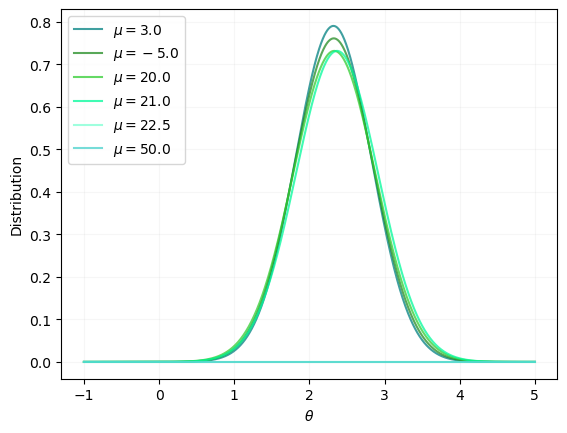

In [1188]:
x = np.linspace(-1, 5, 1000)

plt.plot(x, Normal(q_new_pi_3["loc"].detach().squeeze().numpy(), q_new_pi_3["var"].detach().squeeze().numpy(), x, 1),
         label=r"$\mu=3.0$", color=cmap2[0], alpha=.75)
plt.plot(x, Normal(q_new_pi_5["loc"].detach().squeeze().numpy(), q_new_pi_5["var"].detach().squeeze().numpy(), x, 1),
         label=r"$\mu=-5.0$", color=cmap2[1], alpha=.75)
plt.plot(x, Normal(q_new_pi_20["loc"].detach().squeeze().numpy(), q_new_pi_20["var"].detach().squeeze().numpy(), x, 1),
         label=r"$\mu=20.0$", color=cmap2[2], alpha=.75)
plt.plot(x, Normal(q_new_pi_25["loc"].detach().squeeze().numpy(), q_new_pi_20["var"].detach().squeeze().numpy(), x, 1),
         label=r"$\mu=21.0$", color=cmap2[3], alpha=.75)
plt.plot(x, Normal(q_new_pi_30["loc"].detach().squeeze().numpy(), q_new_pi_20["var"].detach().squeeze().numpy(), x, 1),
         label=r"$\mu=22.5$", color=cmap2[4], alpha=.75)
plt.plot(x, Normal(q_new_pi_50["loc"].detach().squeeze().numpy(), q_new_pi_50["var"].detach().squeeze().numpy(), x, 1),
         label=r"$\mu=50.0$", color=cmap2[5], alpha=.75)

#plt.axvline(q_new_uni["loc"].detach().squeeze().numpy(), color ="grey", label = "mean", alpha=.75)
#plt.plot(x, true_posterior, label="p(theta|D)")
#plt.plot(x, Mix(x, 0.5, 2., 0.75, 0., 2.5), color="firebrick", label="p(D|theta)")
#plt.hist(samp, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel(r"$\theta$")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

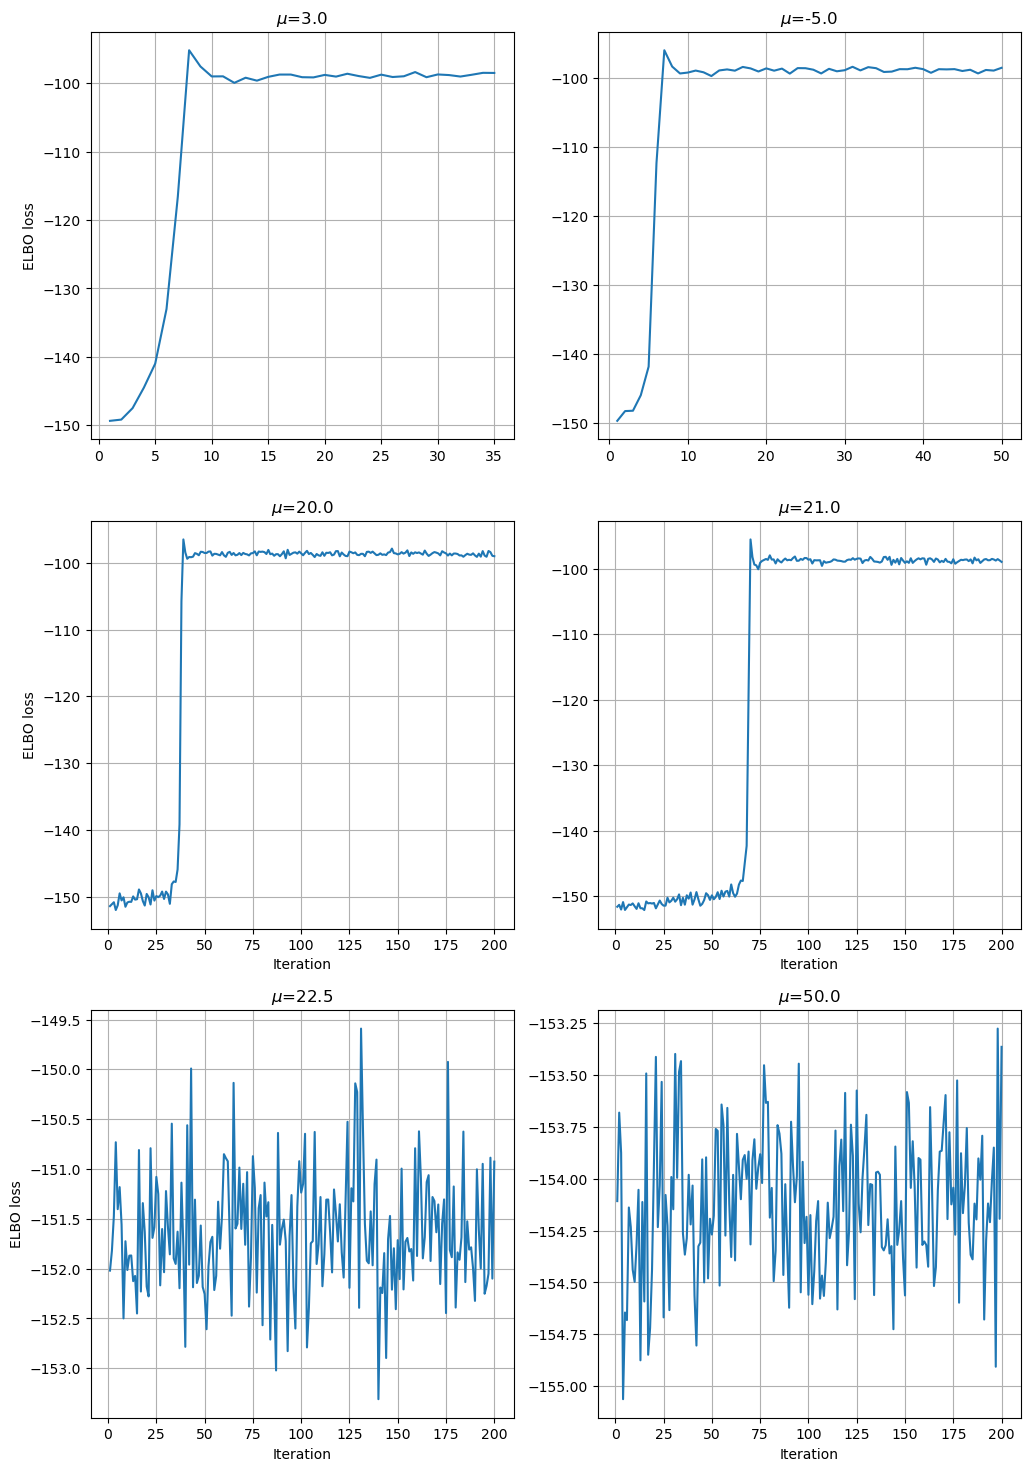

In [1192]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}

gm_3 = copy.deepcopy(global_metrics)
gm_5 = copy.deepcopy(global_metrics)
gm_20 = copy.deepcopy(global_metrics)
gm_50 = copy.deepcopy(global_metrics)
gm_25 = copy.deepcopy(global_metrics)
gm_30 = copy.deepcopy(global_metrics)

for i in range(35):
    running_total = 0.
    for j in range((i* 10),((i+1)* 10)):
        running_total += q_new_pi_3["metrics"]["elbos"][j]      
    gm_3["elbos"].append(running_total)
    
for i in range(50):
    running_total = 0.
    for j in range((i* 10),((i+1)* 10)):
        running_total += q_new_pi_5["metrics"]["elbos"][j]      
    gm_5["elbos"].append(running_total)
    
for i in range(200):
    running_total = 0.
    running_total2 = 0.
    running_total3 = 0.
    running_total4 = 0.
    for j in range((i* 10),((i+1)* 10)):
        running_total += q_new_pi_20["metrics"]["elbos"][j]
        running_total2 += q_new_pi_50["metrics"]["elbos"][j]
        running_total3 += q_new_pi_25["metrics"]["elbos"][j]
        running_total4 += q_new_pi_30["metrics"]["elbos"][j] 
    gm_20["elbos"].append(running_total)
    gm_50["elbos"].append(running_total2)
    gm_25["elbos"].append(running_total3)
    gm_30["elbos"].append(running_total4)
    
x_vals_35 = np.arange(1, (35+1))
x_vals_50 = np.arange(1, (50+1))
x_vals_200 = np.arange(1, (200+1))

fig, axs = plt.subplots(3,2, figsize=(12,18))
#fig.figure(figsize=(6,6), dpi=125)
axs[0,0].set_title(r"$\mu$=3.0")
axs[0,0].plot(x_vals_35, gm_3["elbos"])
axs[0,0].grid(visible=True)
axs[0,1].set_title(r"$\mu$=-5.0")
axs[0,1].plot(x_vals_50, gm_5["elbos"])
axs[0,1].grid(visible=True)
axs[1,0].set_title(r"$\mu$=20.0")
axs[1,0].plot(x_vals_200, gm_20["elbos"])
axs[1,0].grid(visible=True)
axs[1,1].set_title(r"$\mu$=21.0")
axs[1,1].plot(x_vals_200, gm_25["elbos"])
axs[1,1].grid(visible=True)
axs[2,0].set_title(r"$\mu$=22.5")
axs[2,0].plot(x_vals_200, gm_30["elbos"])
axs[2,0].grid(visible=True)
axs[2,1].set_title(r"$\mu$=50.0")
axs[2,1].plot(x_vals_200, gm_50["elbos"])
axs[2,1].grid(visible=True)


i = 0
for ax in axs.flat:
    if i % 2 == 0:
        ax.set(ylabel='ELBO loss')
    if i > 1:
        ax.set(xlabel='Iteration')
    i += 1
#plt.savefig("Number_of_Clients_and_PGVI_Elbos.png")

## Data set size changes in PVI performance

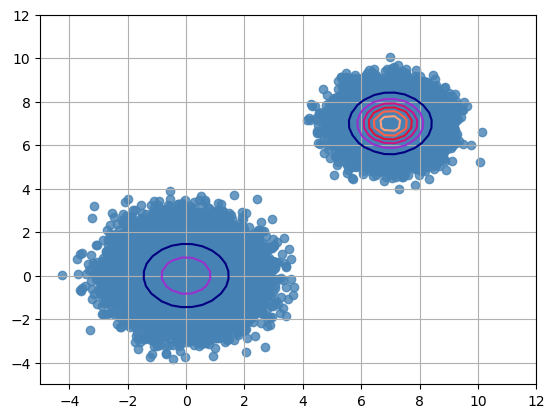

In [1045]:
#Defining the model and sampling data points
D = 2

mean_1_mult3 = 7.*torch.ones(D)
var_1_mult3 = .5*torch.eye(D)
mean_2_mult3 = torch.zeros(D)
var_2_mult3 = torch.eye(D)
w_mult = 0.45
num_clients = 100

samples_large = Gaussian.SampleFromMixture([mean_1_mult3,mean_2_mult3], [var_1_mult3,var_2_mult3], torch.tensor([.55,.45]), 60_000)
cli_samples = homogeneous_split(samples_large, num_clients)

x = y = np.linspace(-5,12)
X_, Y_ = np.meshgrid(x, y)

Z_ = Mixture([X_, Y_], 0.45, [7.,7.], .5, [0.,0.], 1., 2)

plt.contour(X_,Y_,Z_, colors=cmap1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
plt.scatter(samples_large[:,0], samples_large[:,1], c="steelblue", alpha=.8)
plt.grid(visible=True)

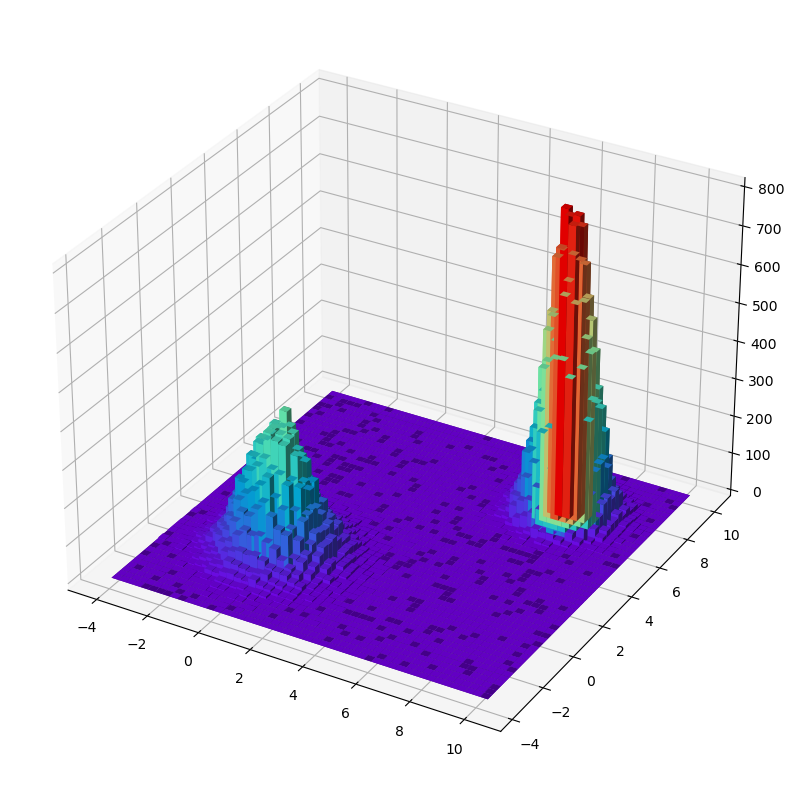

In [1046]:
from mpl_toolkits.mplot3d.axes3d import Axes3D

xdata = samples_large[:,0].numpy()
ydata = samples_large[:,1].numpy()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

hist, xedges, yedges = np.histogram2d(xdata, ydata, bins=(50,50))
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like(xpos)

dx = xedges[1]-xedges[0]
dy = yedges[1]-yedges[0]
dz = hist.flatten()

cmap = mpl.colormaps['rainbow']
max_height = np.max(dz)
min_height = np.min(dz)
rgba = [cmap((k-min_height)/max_height) for k in dz] 

ax.bar3d(xpos, ypos, zpos, dx,dy,dz, color=rgba, zsort='average')
plt.show()

In [1049]:
parameters_100 = {
    "w": torch.tensor(0.45),
    "a": torch.tensor([1.]),
    "b": torch.tensor([100.]),
    "D": 2,
    "N": 60_000,
    "Epochs": 10,
    "Divergence": "KLD",
    "lr": 1e-2,
    "samples": 50,
    "optim_epochs": 20,
    "batch_size": 64
}

q_global_100 = {
    "loc": torch.nn.Parameter(torch.tensor([0.,0.])),
    "var": torch.nn.Parameter(torch.tensor([100.])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_100 = []
for i in range(100):
    clients_100.append({
        "client_idx": i,
        "x_n": cli_samples[i],
        "mean": torch.tensor([0., 0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([.5]),
        "noise_m": torch.tensor([0., 0.]),
        "noise_v": parameters_100["a"],
        "spherical": True,
        "require_s_n": False
    })


In [1050]:
q_new_100, t_new_100 = PartitionedVariationalInference(q_global_100, clients_100, parameters_100, minibatch=True)

Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([6.5278, 6.5457], requires_grad=True) 
 var:  Parameter containing:
tensor([81.0542], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([6.9218, 6.9682], requires_grad=True) 
 var:  Parameter containing:
tensor([61.5113], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([7.2140, 7.2909], requires_grad=True) 
 var:  Parameter containing:
tensor([41.8696], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([7.0174, 6.9605], requires_grad=True) 
 var:  Parameter containing:
tensor([22.1222], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([7.0049, 7.0249], requires_grad=True) 
 var:  Parameter

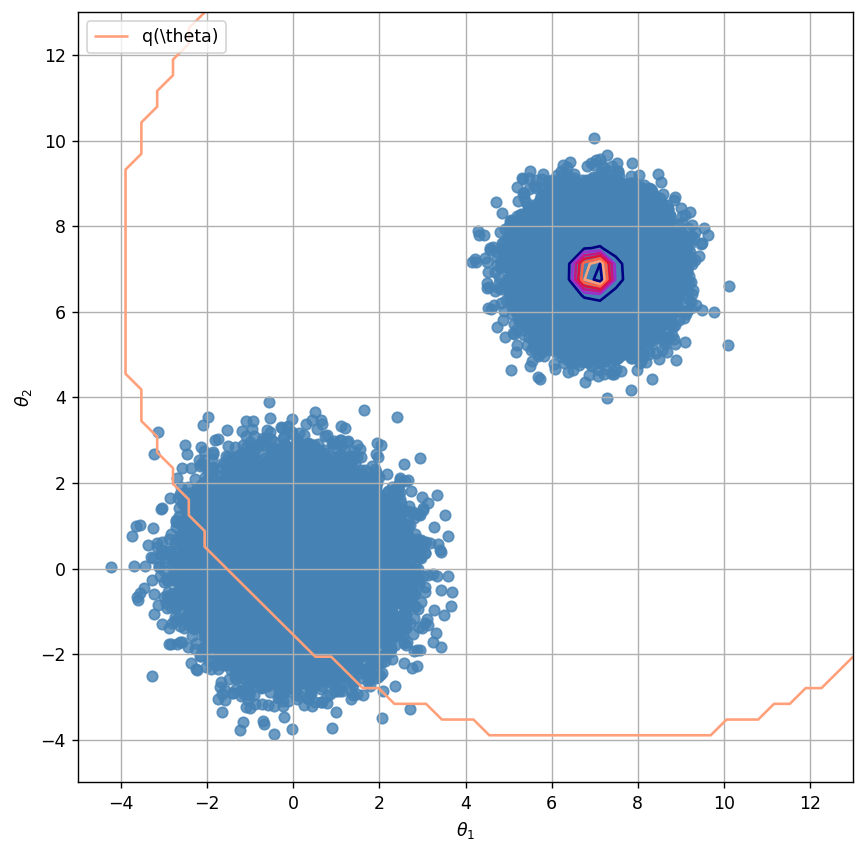

In [1177]:
x = np.linspace(-5,13)
y = np.linspace(-5,13)
X_q, Y_q = np.meshgrid(x, y)
plt.figure(figsize=(8,8), dpi=125)
Z_pvi_100 = Normal(q_new_100["loc"].detach().squeeze().numpy(), q_new_100["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters_het["D"])

#Z_true_h = trueDistribution2D(parameters_het, clients_new_het, 0.5,3.5,1, 4)

#c1 = plt.contour(X_q,Y_q,Z_true_h, colors='dodgerblue', alpha=.5)

c2 = plt.contour(X_q,Y_q,Z_pvi_100, colors = cmap1)

#c3 = plt.contour(X_q,Y_q,Z_pvi, colors=cmap2, alpha=.5)
#plt.scatter(x_,y_,color="firebrick")
#h1,_=c1.legend_elements()
h2,_=c2.legend_elements()
#h3,_=c3.legend_elements()
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
#plt.set_title("Distribution")
#plt.legend([h1[0],h2[0], h3[0]], ["p(D, theta)", "heterogeneous PVI", "homogeneous PVI"], loc="upper left")
plt.legend([h2[0]], [r"q(\theta)"], loc="upper left")
plt.scatter(samples_large[:,0], samples_large[:,1], c="steelblue", alpha=.8)
plt.grid(visible=True)
plt.show()

[-1590892.3293552762, -1549567.5370175915, -1472289.106449368, -1287004.848269567, -818347.9524016437, -130130.11089360448, -104751.6629086132, -98587.03836644378, -100217.36032276355, -98577.55679330627]


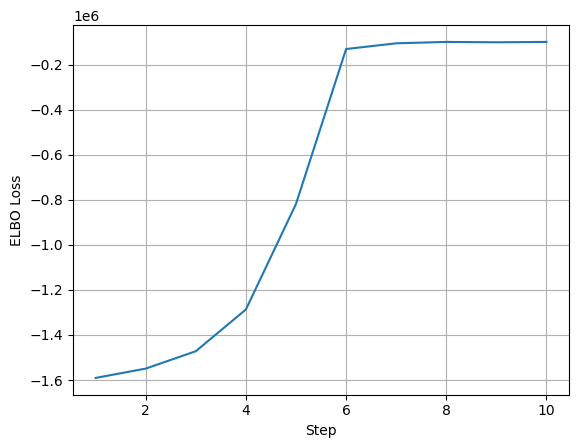

In [1053]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(10):
    running_total = 0.
    for j in range((i* 100),((i+1)* 100)):
         running_total += q_new_100["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
print(global_metrics["elbos"])
plot_training(global_metrics["elbos"])

## Non spherical Gaussians with Sequential and Synchronous Updating Schedules

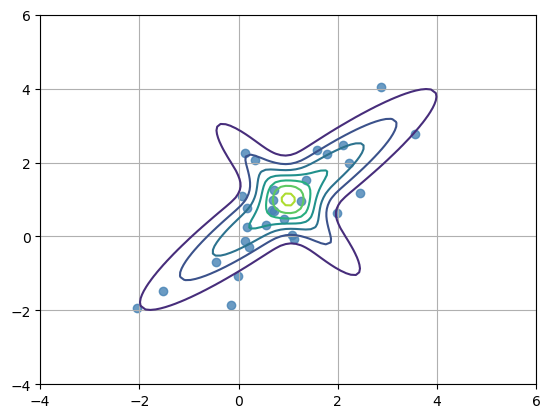

In [691]:
#Defining the model and sampling data points
D = 2

mean_1_gaus = torch.ones(D)
var_1_gaus = torch.tensor([[3., 2.8],[2.8,3.]])
mean_2_gaus = torch.ones(D)
var_2_gaus = torch.tensor([[1., -1.3],[-1.3,2.]])
w_mult = 0.25
num_clients = 3

samples_gaus = Gaussian.SampleFromMixture([mean_1_gaus,mean_2_gaus], [var_1_gaus,var_2_gaus], torch.tensor([.75,.25]), 30)
cli_gaus = homogeneous_split(samples_gaus, num_clients)

X = np.linspace(-4,6, 100)
Y = np.linspace(-4,6,100)
X, Y = np.meshgrid(X,Y)
pos = np.dstack((X,Y))
rv = multivariate_normal([1.,1.], [[3.,2.8],[2.8,3]])
rv2 = multivariate_normal([1.,1.], [[1.,-1.3],[-1.3,2.]])
Z = rv.pdf(pos)
Z2 = rv2.pdf(pos)
trial = 0.75 * Z + 0.25 * Z2
#plt.contour(X,Y,Z)
#plt.contour(X,Y,Z2, colors=cmap1)
plt.contour(X,Y,trial)
#Z_ = Gaussian.GaussianMixture([mean_1_gaus,mean_2_gaus], [var_1_gaus,var_2_gaus], torch.tensor(A), torch.tensor([.75,.25]))

#plt.contour(X_,Y_,Z_, colors=cmap1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
plt.scatter(samples_gaus[:,0], samples_gaus[:,1], c="steelblue", alpha=.8)
plt.grid(visible=True)

In [966]:
parameters_gaus = {
    "w": torch.tensor(0.25),
    "a": var_2_gaus,
    "b": torch.tensor([[1.,0.],[0.,1.]]),
    "D": 2,
    "N": 30,
    "Epochs": 75,
    "Divergence": "KLD",
    "lr": 0.0025,
    "samples": 50,
    "optim_epochs": 30
}

q_global_gaus = {
    "loc": torch.nn.Parameter(torch.tensor([4.,0.])),
    "var": torch.nn.Parameter(torch.tensor([[10.,0.],[0.,10.]])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_gaus = []
for i in range(3):
    clients_gaus.append({
        "client_idx": i,
        "x_n": cli_gaus[i],
        "mean": torch.tensor([0., 0.]),
        "variance": np.inf * torch.eye(2),
        "variance_inverse": 0*torch.eye(2),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": var_1_gaus,
        "noise_m": torch.tensor([1., 1.]),
        "noise_v": parameters_gaus["a"],
        "spherical": False,
        "require_s_n": False
    })


In [961]:
q_new_sync, t_new_sync = SynchronousPVI(q_global_gaus, clients_gaus, parameters_gaus)

Starting global q:  {'loc': Parameter containing:
tensor([4., 0.], requires_grad=True), 'var': Parameter containing:
tensor([[10.,  0.],
        [ 0., 10.]], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
Client 0
Client 1
Client 2
New global q: 
 loc:  Parameter containing:
tensor([3.7952, 0.1972], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.8310, 0.1252],
        [0.1252, 9.8136]], requires_grad=True)
Iteration 2:
Client 0
Client 1
Client 2
New global q: 
 loc:  Parameter containing:
tensor([3.5809, 0.4054], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.6553, 0.2646],
        [0.2646, 9.6122]], requires_grad=True)
Iteration 3:
Client 0
Client 1
Client 2
New global q: 
 loc:  Parameter containing:
tensor([3.3741, 0.5984], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.4566, 0.4520],
        [0.4520, 9.4130]], requires_grad=True)
Iteration 4:
Client 0
Client 1
Client 2
New global q: 
 loc:  Parameter conta

Client 1
Client 2
New global q: 
 loc:  Parameter containing:
tensor([1.0379, 0.8748], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.9337, 4.8761],
        [4.8761, 4.8403]], requires_grad=True)
Iteration 31:
Client 0
Client 1
Client 2
New global q: 
 loc:  Parameter containing:
tensor([1.0112, 0.8415], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.9230, 4.8644],
        [4.8644, 4.8344]], requires_grad=True)
Iteration 32:
Client 0
Client 1
Client 2
New global q: 
 loc:  Parameter containing:
tensor([0.9761, 0.8149], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.9083, 4.8557],
        [4.8557, 4.8243]], requires_grad=True)
Iteration 33:
Client 0
Client 1
Client 2
New global q: 
 loc:  Parameter containing:
tensor([0.9456, 0.7761], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.8967, 4.8461],
        [4.8461, 4.8155]], requires_grad=True)
Iteration 34:
Client 0
Client 1
Client 2
New global q: 
 loc:  Parameter containing:
tensor

Client 1
Client 2
New global q: 
 loc:  Parameter containing:
tensor([0.8419, 0.6705], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.5885, 4.5681],
        [4.5681, 4.5700]], requires_grad=True)
Iteration 61:
Client 0
Client 1
Client 2
New global q: 
 loc:  Parameter containing:
tensor([0.8136, 0.6436], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.5726, 4.5551],
        [4.5551, 4.5542]], requires_grad=True)
Iteration 62:
Client 0
Client 1
Client 2
New global q: 
 loc:  Parameter containing:
tensor([0.8420, 0.6704], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.5663, 4.5485],
        [4.5485, 4.5485]], requires_grad=True)
Iteration 63:
Client 0
Client 1
Client 2
New global q: 
 loc:  Parameter containing:
tensor([0.8661, 0.6972], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.5533, 4.5388],
        [4.5388, 4.5374]], requires_grad=True)
Iteration 64:
Client 0
Client 1
Client 2
New global q: 
 loc:  Parameter containing:
tensor

In [963]:
q_new_gaus, t_new_gaus = PartitionedVariationalInference(q_global_gaus, clients_gaus, parameters_gaus)

Starting global q:  {'loc': Parameter containing:
tensor([4., 0.], requires_grad=True), 'var': Parameter containing:
tensor([[10.,  0.],
        [ 0., 10.]], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([3.7837, 0.2111], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.8163, 0.1435],
        [0.1435, 9.8013]], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([3.5678, 0.4234], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.6088, 0.3394],
        [0.3394, 9.5983]], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([3.3545, 0.6284], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.4157, 0.5082],
        [0.5082, 9.3955]], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([3.1483, 0.8223], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.2114, 0.6991],


New global q: 
 loc:  Parameter containing:
tensor([0.9910, 0.8274], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.8684, 4.8334],
        [4.8334, 4.8217]], requires_grad=True)
Iteration 34:
New global q: 
 loc:  Parameter containing:
tensor([0.9587, 0.7874], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.8483, 4.8165],
        [4.8165, 4.8055]], requires_grad=True)
Iteration 35:
New global q: 
 loc:  Parameter containing:
tensor([0.9564, 0.7859], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.8401, 4.8084],
        [4.8084, 4.7983]], requires_grad=True)
Iteration 36:
New global q: 
 loc:  Parameter containing:
tensor([0.9472, 0.7737], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.8296, 4.8012],
        [4.8012, 4.7897]], requires_grad=True)
Iteration 37:
New global q: 
 loc:  Parameter containing:
tensor([0.9325, 0.7640], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.8189, 4.7853],
        [4.7853, 4.7727]], requ

New global q: 
 loc:  Parameter containing:
tensor([0.8825, 0.7151], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.4593, 4.4445],
        [4.4445, 4.4464]], requires_grad=True)
Iteration 67:
New global q: 
 loc:  Parameter containing:
tensor([0.8940, 0.7295], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.4523, 4.4378],
        [4.4378, 4.4401]], requires_grad=True)
Iteration 68:
New global q: 
 loc:  Parameter containing:
tensor([0.8823, 0.7116], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.4422, 4.4283],
        [4.4283, 4.4317]], requires_grad=True)
Iteration 69:
New global q: 
 loc:  Parameter containing:
tensor([0.8990, 0.7270], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.4309, 4.4119],
        [4.4119, 4.4193]], requires_grad=True)
Iteration 70:
New global q: 
 loc:  Parameter containing:
tensor([0.9063, 0.7321], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.4162, 4.4001],
        [4.4001, 4.4052]], requ

In [965]:
parameters_gaus.update({"Divergence":"AR", "alpha":.5})
q_new_gaus_ar, t_new_gaus_ar = PartitionedVariationalInference(q_global_gaus, clients_gaus, parameters_gaus)

Starting global q:  {'loc': Parameter containing:
tensor([4., 0.], requires_grad=True), 'var': Parameter containing:
tensor([[10.,  0.],
        [ 0., 10.]], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([3.7844, 0.2109], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.8182, 0.1480],
        [0.1480, 9.8086]], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([3.5727, 0.4136], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.6463, 0.2887],
        [0.2887, 9.6052]], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([3.3601, 0.6099], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.4395, 0.4826],
        [0.4826, 9.3923]], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([3.1505, 0.8091], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.2385, 0.6781],


New global q: 
 loc:  Parameter containing:
tensor([0.9436, 0.7544], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.7911, 4.7672],
        [4.7672, 4.7721]], requires_grad=True)
Iteration 34:
New global q: 
 loc:  Parameter containing:
tensor([0.9328, 0.7618], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.7779, 4.7555],
        [4.7555, 4.7646]], requires_grad=True)
Iteration 35:
New global q: 
 loc:  Parameter containing:
tensor([0.9266, 0.7500], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.7427, 4.7296],
        [4.7296, 4.7576]], requires_grad=True)
Iteration 36:
New global q: 
 loc:  Parameter containing:
tensor([0.9132, 0.7323], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.7256, 4.7195],
        [4.7195, 4.7488]], requires_grad=True)
Iteration 37:
New global q: 
 loc:  Parameter containing:
tensor([0.9111, 0.7237], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.6988, 4.6971],
        [4.6971, 4.7393]], requ

New global q: 
 loc:  Parameter containing:
tensor([0.8930, 0.7181], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.1186, 4.2571],
        [4.2571, 4.4253]], requires_grad=True)
Iteration 67:
New global q: 
 loc:  Parameter containing:
tensor([0.9254, 0.7396], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.1065, 4.2441],
        [4.2441, 4.4189]], requires_grad=True)
Iteration 68:
New global q: 
 loc:  Parameter containing:
tensor([0.9279, 0.7399], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.0946, 4.2336],
        [4.2336, 4.4127]], requires_grad=True)
Iteration 69:
New global q: 
 loc:  Parameter containing:
tensor([0.9048, 0.7262], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.0715, 4.2174],
        [4.2174, 4.4031]], requires_grad=True)
Iteration 70:
New global q: 
 loc:  Parameter containing:
tensor([0.8970, 0.7123], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.0571, 4.2083],
        [4.2083, 4.3952]], requ

In [967]:
parameters_gaus.update({"Divergence":"AR", "alpha":.5})
q_new_sync_ar, t_new_sync_ar = SynchronousPVI(q_global_gaus, clients_gaus, parameters_gaus)

Starting global q:  {'loc': Parameter containing:
tensor([4., 0.], requires_grad=True), 'var': Parameter containing:
tensor([[10.,  0.],
        [ 0., 10.]], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
Client 0
Client 1
Client 2
New global q: 
 loc:  Parameter containing:
tensor([3.7935, 0.2025], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.8607, 0.0761],
        [0.0761, 9.8062]], requires_grad=True)
Iteration 2:
Client 0
Client 1
Client 2
New global q: 
 loc:  Parameter containing:
tensor([3.5867, 0.4042], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.6761, 0.2266],
        [0.2266, 9.6206]], requires_grad=True)
Iteration 3:
Client 0
Client 1
Client 2
New global q: 
 loc:  Parameter containing:
tensor([3.3816, 0.5992], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.5000, 0.3831],
        [0.3831, 9.4254]], requires_grad=True)
Iteration 4:
Client 0
Client 1
Client 2
New global q: 
 loc:  Parameter conta

Client 1
Client 2
New global q: 
 loc:  Parameter containing:
tensor([1.1082, 0.9267], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.9062, 4.8505],
        [4.8505, 4.8299]], requires_grad=True)
Iteration 31:
Client 0
Client 1
Client 2
New global q: 
 loc:  Parameter containing:
tensor([1.0073, 0.8378], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.8787, 4.8316],
        [4.8316, 4.8124]], requires_grad=True)
Iteration 32:
Client 0
Client 1
Client 2
New global q: 
 loc:  Parameter containing:
tensor([0.9715, 0.8068], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.8674, 4.8206],
        [4.8206, 4.8082]], requires_grad=True)
Iteration 33:
Client 0
Client 1
Client 2
New global q: 
 loc:  Parameter containing:
tensor([0.9589, 0.7782], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.8515, 4.8015],
        [4.8015, 4.8082]], requires_grad=True)
Iteration 34:
Client 0
Client 1
Client 2
New global q: 
 loc:  Parameter containing:
tensor

Client 1
Client 2
New global q: 
 loc:  Parameter containing:
tensor([0.8441, 0.6543], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.2889, 4.3769],
        [4.3769, 4.5062]], requires_grad=True)
Iteration 61:
Client 0
Client 1
Client 2
New global q: 
 loc:  Parameter containing:
tensor([0.8419, 0.6612], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.2765, 4.3642],
        [4.3642, 4.5032]], requires_grad=True)
Iteration 62:
Client 0
Client 1
Client 2
New global q: 
 loc:  Parameter containing:
tensor([0.8313, 0.6595], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.2523, 4.3504],
        [4.3504, 4.4846]], requires_grad=True)
Iteration 63:
Client 0
Client 1
Client 2
New global q: 
 loc:  Parameter containing:
tensor([0.8464, 0.6682], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.2338, 4.3382],
        [4.3382, 4.4761]], requires_grad=True)
Iteration 64:
Client 0
Client 1
Client 2
New global q: 
 loc:  Parameter containing:
tensor

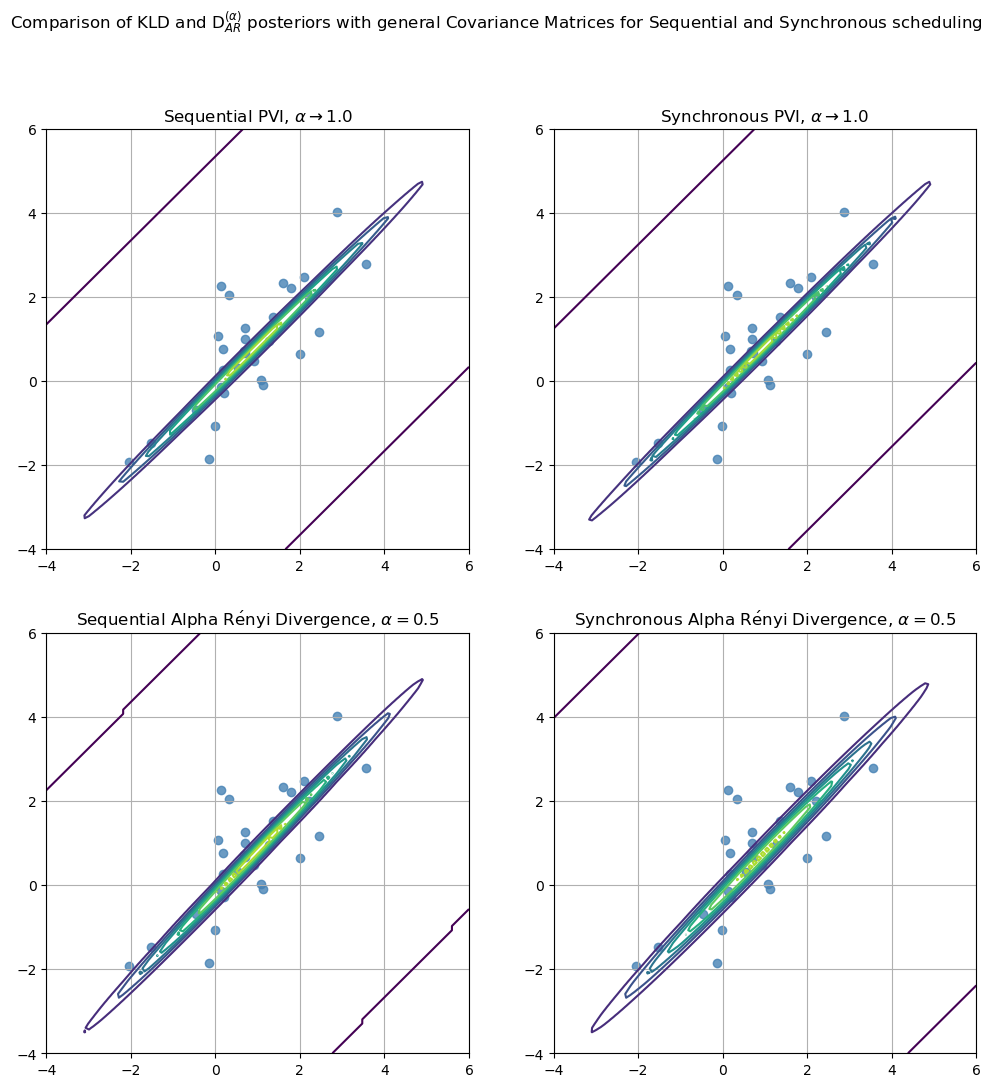

In [976]:
X = np.linspace(-4,6, 100)
Y = np.linspace(-4,6,100)
X, Y = np.meshgrid(X,Y)
pos = np.dstack((X,Y))
rv = multivariate_normal(q_new_gaus["loc"].detach().numpy(), q_new_gaus["var"].detach().numpy())
Z = rv.pdf(pos)
rvsync = multivariate_normal(q_new_sync["loc"].detach().numpy(), q_new_sync["var"].detach().numpy())
Zsync = rvsync.pdf(pos)
rv2 = multivariate_normal(q_new_gaus_ar["loc"].detach().numpy(), q_new_gaus_ar["var"].detach().numpy())
Zar = rv2.pdf(pos)
rv2sync = multivariate_normal(q_new_sync_ar["loc"].detach().numpy(), q_new_sync_ar["var"].detach().numpy())
Zarsync = rv2sync.pdf(pos)

#plt.scatter(samples_gaus[:,0], samples_gaus[:,1], c="steelblue", alpha=.8)
#plt.grid(visible=True)


fig, axs = plt.subplots(2,2, figsize=(12,12))
#fig.figure(figsize=(6,6), dpi=125)
axs[0,0].set_title(r"Sequential PVI, $\alpha\rightarrow 1.0$")
axs[0,0].contour(X,Y,Z)
axs[0,0].scatter(samples_gaus[:,0], samples_gaus[:,1], c="steelblue", alpha=.8)
axs[0,0].grid(visible=True)
axs[0,1].set_title(r"Synchronous PVI, $\alpha\rightarrow 1.0$")
axs[0,1].contour(X,Y,Zsync)
axs[0,1].scatter(samples_gaus[:,0], samples_gaus[:,1], c="steelblue", alpha=.8)
axs[0,1].grid(visible=True)
axs[1,0].set_title(r"Sequential Alpha R$\'\mathrm{e}$nyi Divergence, $\alpha=0.5$")
axs[1,0].contour(X,Y,Zar)
axs[1,0].scatter(samples_gaus[:,0], samples_gaus[:,1], c="steelblue", alpha=.8)
axs[1,0].grid(visible=True)
axs[1,1].set_title(r"Synchronous Alpha R$\'\mathrm{e}$nyi Divergence, $\alpha=0.5$")
axs[1,1].contour(X,Y,Zarsync)
axs[1,1].scatter(samples_gaus[:,0], samples_gaus[:,1], c="steelblue", alpha=.8)
axs[1,1].grid(visible=True)
fig.suptitle(r"Comparison of KLD and $\mathrm{D}_{AR}^{(\alpha)}$ posteriors with general Covariance Matrices for Sequential and Synchronous scheduling")

plt.show()

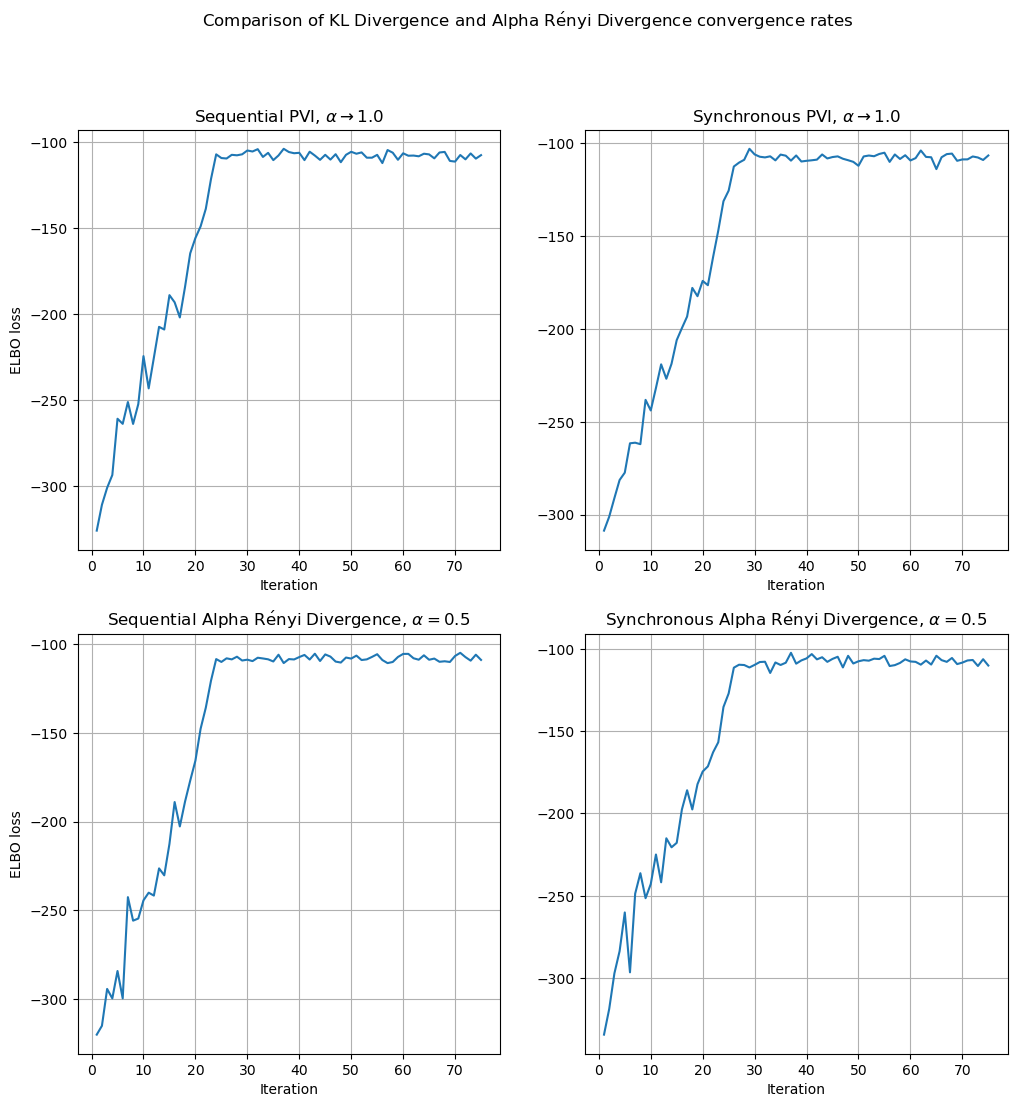

In [969]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
global_metrics2 = copy.deepcopy(global_metrics)


for i in range(parameters_gaus["Epochs"]):
    running_total = 0.
    running_total2 = 0.

    for j in range((i* 3),((i+1)* 3)):
        running_total += q_new_gaus["metrics"]["elbos"][j]
        running_total2 += q_new_gaus_ar["metrics"]["elbos"][j]
    global_metrics["elbos"].append(running_total)
    global_metrics2["elbos"].append(running_total2)


x_vals_50 = np.arange(1, (parameters_gaus["Epochs"]+1))


fig, axs = plt.subplots(2,2, figsize=(12,12))
#fig.figure(figsize=(6,6), dpi=125)
axs[0,0].set_title(r"Sequential PVI, $\alpha\rightarrow1.0$")
axs[0,0].plot(x_vals_50, global_metrics["elbos"])
axs[0,0].grid(visible=True)
axs[1,0].set_title(r"Sequential Alpha R$\'\mathrm{e}$nyi Divergence, $\alpha=0.5$")
axs[1,0].plot(x_vals_50, global_metrics2["elbos"])
axs[1,0].grid(visible=True)
axs[0,1].set_title(r"Synchronous PVI, $\alpha\rightarrow1.0$")
axs[0,1].plot(x_vals_50, q_new_sync["metrics"]["elbos"])
axs[0,1].grid(visible=True)
axs[1,1].set_title(r"Synchronous Alpha R$\'\mathrm{e}$nyi Divergence, $\alpha=0.5$")
axs[1,1].plot(x_vals_50, q_new_sync_ar["metrics"]["elbos"])
axs[1,1].grid(visible=True)

fig.suptitle(r"Comparison of KL Divergence and Alpha R$\'\mathrm{e}$nyi Divergence convergence rates")

i = 0
for ax in axs.flat:
    if i % 2 == 0:
        ax.set(ylabel='ELBO loss')
    ax.set(xlabel='Iteration')
    i += 1
#plt.savefig("Number_of_Clients_and_PGVI_Elbos.png")

## Epsilon Contaminated model

## Synchronous PVI update schedule

## Synthetic Asynchronous Schedule

In [1093]:
parameters_async = {
    "w": torch.tensor(0.25),
    "a": var_2_gaus,
    "b": torch.tensor([[1.,0.],[0.,1.]]),
    "D": 2,
    "N": 30,
    "Epochs": 80,
    "Divergence": "KLD",
    "lr": 0.0025,
    "samples": 50,
    "optim_epochs": 30
}

q_global_async = {
    "loc": torch.nn.Parameter(torch.tensor([4.,0.])),
    "var": torch.nn.Parameter(torch.tensor([[10.,0.],[0.,10.]])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

schedule = [2,5,1]
clients_async = []
for i in range(3):
    clients_async.append({
        "client_idx": i,
        "x_n": cli_gaus[i],
        "mean": torch.tensor([0., 0.]),
        "variance": np.inf * torch.eye(2),
        "variance_inverse": 0*torch.eye(2),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": var_1_gaus,
        "noise_m": torch.tensor([1., 1.]),
        "noise_v": parameters_async["a"],
        "spherical": False,
        "require_s_n": False,
        "wait_time": schedule[i],
        "q_new": {
            "loc": None,
            "var": None
        },
        "q_old": {
            "loc": None,
            "var": None
        }
    })


In [1082]:
q_new_async, t_new_async = AsynchronousPVI(q_global_async, clients_async, parameters_async)

Starting global q:  {'loc': Parameter containing:
tensor([4., 0.], requires_grad=True), 'var': Parameter containing:
tensor([[10.,  0.],
        [ 0., 10.]], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
Client 0 with wait time:  2
Client 1 with wait time:  5
Client 2 with wait time:  1
New global q: 
 loc:  Parameter containing:
tensor([4., 0.], requires_grad=True) 
 var:  Parameter containing:
tensor([[10.,  0.],
        [ 0., 10.]], requires_grad=True)
Iteration 2:
Client 2 with wait time:  1
New global q: 
 loc:  Parameter containing:
tensor([3.9284, 0.0716], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.9624e+00, 9.6287e-03],
        [9.6287e-03, 9.9443e+00]], requires_grad=True)
Iteration 3:
Client 0 with wait time:  2
Client 2 with wait time:  1
New global q: 
 loc:  Parameter containing:
tensor([3.7881, 0.2113], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.8341, 0.1152],
        [0.1152, 9.8404]], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.6802, 1.8966], requires_grad=True) 
 var:  Parameter containing:
tensor([[6.9922, 2.8710],
        [2.8710, 6.9717]], requires_grad=True)
Iteration 29:
Client 0 with wait time:  2
Client 2 with wait time:  1
New global q: 
 loc:  Parameter containing:
tensor([1.6724, 1.8780], requires_grad=True) 
 var:  Parameter containing:
tensor([[6.8539, 3.0103],
        [3.0103, 6.8335]], requires_grad=True)
Iteration 30:
Client 2 with wait time:  1
New global q: 
 loc:  Parameter containing:
tensor([1.6220, 1.9247], requires_grad=True) 
 var:  Parameter containing:
tensor([[6.7811, 3.0838],
        [3.0838, 6.7581]], requires_grad=True)
Iteration 31:
Client 0 with wait time:  2
Client 1 with wait time:  5
Client 2 with wait time:  1
New global q: 
 loc:  Parameter containing:
tensor([1.6505, 1.8366], requires_grad=True) 
 var:  Parameter containing:
tensor([[6.6009, 3.2652],
        [3.2652, 6.5797]], requires_grad=True)
Iteration 32:
Client 2

Client 2 with wait time:  1
New global q: 
 loc:  Parameter containing:
tensor([1.3446, 1.1911], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.8576, 4.8489],
        [4.8489, 4.8605]], requires_grad=True)
Iteration 57:
Client 0 with wait time:  2
Client 2 with wait time:  1
New global q: 
 loc:  Parameter containing:
tensor([1.2996, 1.1370], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.8473, 4.8408],
        [4.8408, 4.8524]], requires_grad=True)
Iteration 58:
Client 2 with wait time:  1
New global q: 
 loc:  Parameter containing:
tensor([1.3095, 1.1469], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.8445, 4.8398],
        [4.8398, 4.8505]], requires_grad=True)
Iteration 59:
Client 0 with wait time:  2
Client 2 with wait time:  1
New global q: 
 loc:  Parameter containing:
tensor([1.2597, 1.0945], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.8405, 4.8370],
        [4.8370, 4.8468]], requires_grad=True)
Iteration 60:
Client 2

In [1094]:
parameters_async.update({"Divergence":"AR", "alpha":.5})
q_new_async_ar, t_new_async_ar = AsynchronousPVI(q_global_async, clients_async, parameters_async)

Starting global q:  {'loc': Parameter containing:
tensor([4., 0.], requires_grad=True), 'var': Parameter containing:
tensor([[10.,  0.],
        [ 0., 10.]], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 0:
Client 0 with wait time:  2
Client 1 with wait time:  5
Client 2 with wait time:  1
New global q: 
 loc:  Parameter containing:
tensor([4., 0.], requires_grad=True) 
 var:  Parameter containing:
tensor([[10.,  0.],
        [ 0., 10.]], requires_grad=True)
Iteration 1:
Client 2 with wait time:  1
New global q: 
 loc:  Parameter containing:
tensor([3.9286, 0.0721], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.9446, 0.0300],
        [0.0300, 9.9379]], requires_grad=True)
Iteration 2:
Client 0 with wait time:  2
Client 2 with wait time:  1
New global q: 
 loc:  Parameter containing:
tensor([3.7860, 0.2145], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.8207, 0.1269],
        [0.1269, 9.8310]], requires_grad=True)
Iteration 

New global q: 
 loc:  Parameter containing:
tensor([1.6979, 1.9335], requires_grad=True) 
 var:  Parameter containing:
tensor([[7.0045, 2.8197],
        [2.8197, 6.9500]], requires_grad=True)
Iteration 28:
Client 0 with wait time:  2
Client 2 with wait time:  1
New global q: 
 loc:  Parameter containing:
tensor([1.7179, 1.8896], requires_grad=True) 
 var:  Parameter containing:
tensor([[6.8681, 2.9572],
        [2.9572, 6.8114]], requires_grad=True)
Iteration 29:
Client 2 with wait time:  1
New global q: 
 loc:  Parameter containing:
tensor([1.6806, 1.9237], requires_grad=True) 
 var:  Parameter containing:
tensor([[6.7934, 3.0316],
        [3.0316, 6.7383]], requires_grad=True)
Iteration 30:
Client 0 with wait time:  2
Client 1 with wait time:  5
Client 2 with wait time:  1
New global q: 
 loc:  Parameter containing:
tensor([1.7317, 1.8348], requires_grad=True) 
 var:  Parameter containing:
tensor([[6.6177, 3.2090],
        [3.2090, 6.5571]], requires_grad=True)
Iteration 31:
Client 2

Client 2 with wait time:  1
New global q: 
 loc:  Parameter containing:
tensor([1.3286, 1.1783], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.8408, 4.8023],
        [4.8023, 4.8047]], requires_grad=True)
Iteration 56:
Client 0 with wait time:  2
Client 2 with wait time:  1
New global q: 
 loc:  Parameter containing:
tensor([1.2842, 1.1282], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.8283, 4.7883],
        [4.7883, 4.7932]], requires_grad=True)
Iteration 57:
Client 2 with wait time:  1
New global q: 
 loc:  Parameter containing:
tensor([1.3086, 1.1434], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.8237, 4.7831],
        [4.7831, 4.7890]], requires_grad=True)
Iteration 58:
Client 0 with wait time:  2
Client 2 with wait time:  1
New global q: 
 loc:  Parameter containing:
tensor([1.2694, 1.0937], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.8071, 4.7734],
        [4.7734, 4.7791]], requires_grad=True)
Iteration 59:
Client 2

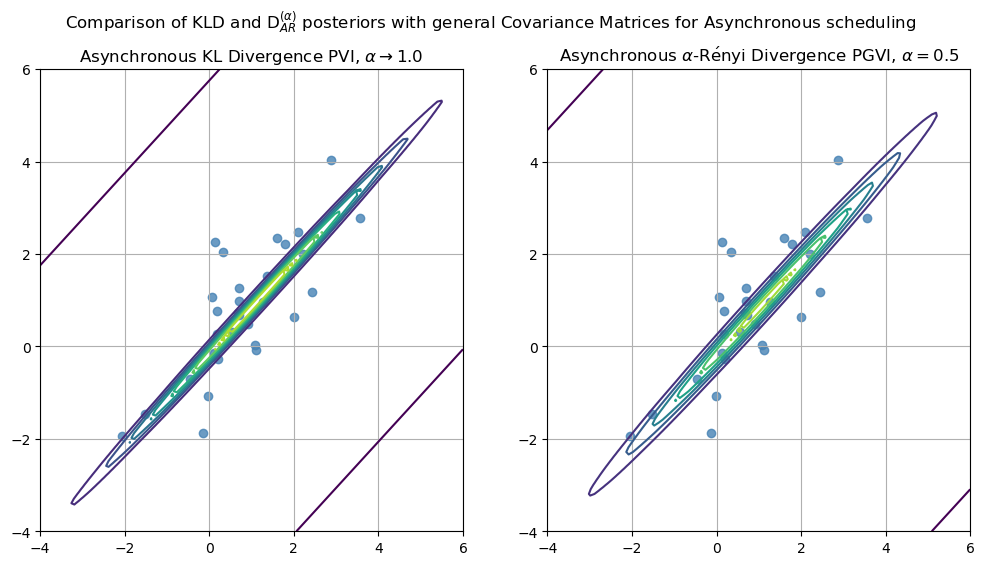

In [1098]:
X = np.linspace(-4,6,100)
Y = np.linspace(-4,6,100)
X, Y = np.meshgrid(X,Y)
pos = np.dstack((X,Y))
rv = multivariate_normal(q_new_async["loc"].detach().numpy(), q_new_async["var"].detach().numpy())
Z = rv.pdf(pos)
rv2 = multivariate_normal(q_new_async_ar["loc"].detach().numpy(), q_new_async_ar["var"].detach().numpy())
Zar = rv2.pdf(pos)

fig, axs = plt.subplots(1,2, figsize=(12,6))
plt.suptitle("Asynchronous Update Schedule")
axs[0].set_title(r"Asynchronous KL Divergence PVI, $\alpha\rightarrow1.0$")
axs[0].contour(X,Y,Z)
axs[0].scatter(samples_gaus[:,0], samples_gaus[:,1], c="steelblue", alpha=.8)
axs[0].grid(visible=True)
axs[1].set_title(r"Asynchronous $\alpha$-R$\'\mathrm{e}$nyi Divergence PGVI, $\alpha=0.5$")
axs[1].contour(X,Y,Zar)
axs[1].scatter(samples_gaus[:,0], samples_gaus[:,1], c="steelblue", alpha=.8)
axs[1].grid(visible=True)
fig.suptitle(r"Comparison of KLD and $\mathrm{D}_{AR}^{(\alpha)}$ posteriors with general Covariance Matrices for Asynchronous scheduling")

plt.show()

#### Currently we cannot generate ELBOs since PVI has an additive nature of client ELBOs up to a constant independent of $\theta$, however asynchronous doesn't allow us to pool the ELBOs since iterations are finished at different times and compiled at different stages of the algorithm

#### Ideas are welcome

### Plotting Sequential, Synchronous and Asynchronous approximate posteriors for PVI and PGVI

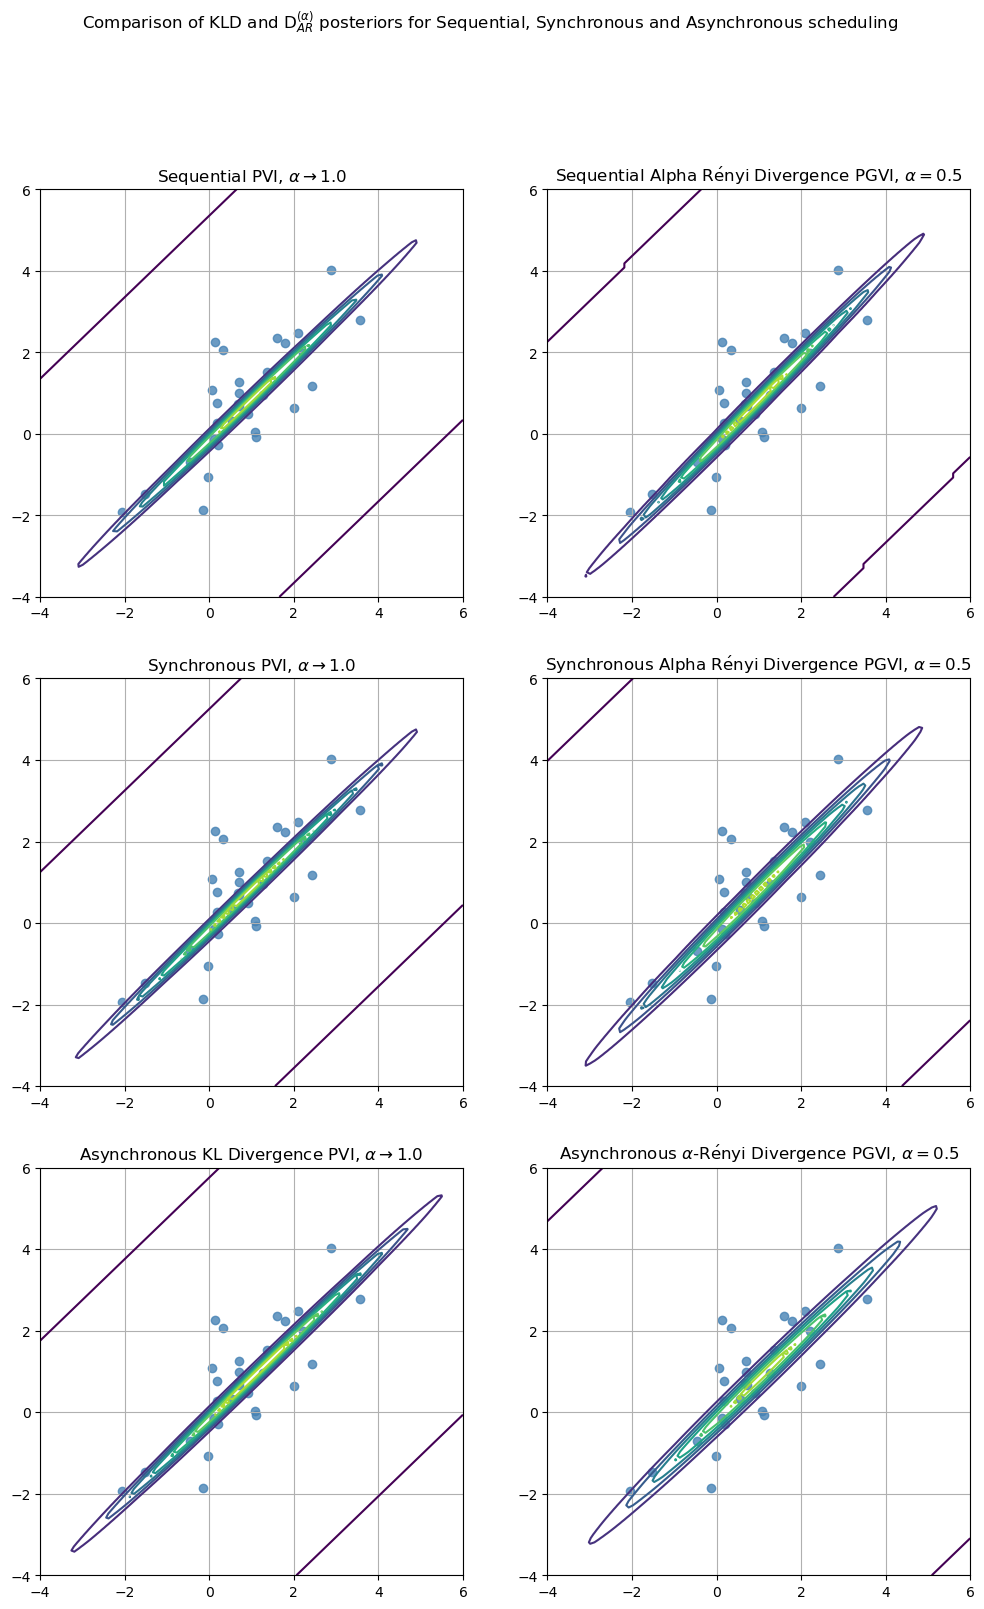

In [1126]:
X = np.linspace(-4,6, 100)
Y = np.linspace(-4,6,100)
X, Y = np.meshgrid(X,Y)
pos = np.dstack((X,Y))
rv = multivariate_normal(q_new_gaus["loc"].detach().numpy(), q_new_gaus["var"].detach().numpy())
Z = rv.pdf(pos)
rvsync = multivariate_normal(q_new_sync["loc"].detach().numpy(), q_new_sync["var"].detach().numpy())
Zsync = rvsync.pdf(pos)
rv2 = multivariate_normal(q_new_gaus_ar["loc"].detach().numpy(), q_new_gaus_ar["var"].detach().numpy())
Zar = rv2.pdf(pos)
rv2sync = multivariate_normal(q_new_sync_ar["loc"].detach().numpy(), q_new_sync_ar["var"].detach().numpy())
Zarsync = rv2sync.pdf(pos)
rvasync = multivariate_normal(q_new_async["loc"].detach().numpy(), q_new_async["var"].detach().numpy())
Zasync = rvasync.pdf(pos)
rv2async = multivariate_normal(q_new_async_ar["loc"].detach().numpy(), q_new_async_ar["var"].detach().numpy())
Zarasync = rv2async.pdf(pos)
#plt.scatter(samples_gaus[:,0], samples_gaus[:,1], c="steelblue", alpha=.8)
#plt.grid(visible=True)


fig, axs = plt.subplots(3,2, figsize=(12,18))
#fig.figure(figsize=(6,6), dpi=125)
axs[0,0].set_title(r"Sequential PVI, $\alpha\rightarrow 1.0$")
axs[0,0].contour(X,Y,Z)
axs[0,0].scatter(samples_gaus[:,0], samples_gaus[:,1], c="steelblue", alpha=.8)
axs[0,0].grid(visible=True)
axs[1,0].set_title(r"Synchronous PVI, $\alpha\rightarrow 1.0$")
axs[1,0].contour(X,Y,Zsync)
axs[1,0].scatter(samples_gaus[:,0], samples_gaus[:,1], c="steelblue", alpha=.8)
axs[1,0].grid(visible=True)
axs[0,1].set_title(r"Sequential Alpha R$\'\mathrm{e}$nyi Divergence PGVI, $\alpha=0.5$")
axs[0,1].contour(X,Y,Zar)
axs[0,1].scatter(samples_gaus[:,0], samples_gaus[:,1], c="steelblue", alpha=.8)
axs[0,1].grid(visible=True)
axs[1,1].set_title(r"Synchronous Alpha R$\'\mathrm{e}$nyi Divergence PGVI, $\alpha=0.5$")
axs[1,1].contour(X,Y,Zarsync)
axs[1,1].scatter(samples_gaus[:,0], samples_gaus[:,1], c="steelblue", alpha=.8)
axs[1,1].grid(visible=True)
axs[2,0].set_title(r"Asynchronous KL Divergence PVI, $\alpha\rightarrow1.0$")
axs[2,0].contour(X,Y,Zasync)
axs[2,0].scatter(samples_gaus[:,0], samples_gaus[:,1], c="steelblue", alpha=.8)
axs[2,0].grid(visible=True)
axs[2,1].set_title(r"Asynchronous $\alpha$-R$\'\mathrm{e}$nyi Divergence PGVI, $\alpha=0.5$")
axs[2,1].contour(X,Y,Zarasync)
axs[2,1].scatter(samples_gaus[:,0], samples_gaus[:,1], c="steelblue", alpha=.8)
axs[2,1].grid(visible=True)
fig.suptitle(r"Comparison of KLD and $\mathrm{D}_{AR}^{(\alpha)}$ posteriors for Sequential, Synchronous and Asynchronous scheduling")

plt.show()

# Real Dataset

## Crab Data set, Campbell and Mahon (1974)
Data: https://datarepository.wolframcloud.com/resources/Sample-Data-Crab-Measures

Paper: https://www.mimuw.edu.pl/~pokar/StatystykaII/DANE/CampbellMahon.pdf

In [1176]:
df = pd.read_csv('../../../data/crab_measures.csv')
df.head()

Color   Sex  Index               FrontalLobeSize  \
0  blue  male      1  Quantity[8.1, "Millimeters"]   
1  blue  male      2  Quantity[8.8, "Millimeters"]   
2  blue  male      3  Quantity[9.2, "Millimeters"]   
3  blue  male      4  Quantity[9.6, "Millimeters"]   
4  blue  male      5  Quantity[9.8, "Millimeters"]   

                      RearWidth                 CarapaceLength  \
0  Quantity[6.7, "Millimeters"]  Quantity[16.1, "Millimeters"]   
1  Quantity[7.7, "Millimeters"]  Quantity[18.1, "Millimeters"]   
2  Quantity[7.8, "Millimeters"]    Quantity[19, "Millimeters"]   
3  Quantity[7.9, "Millimeters"]  Quantity[20.1, "Millimeters"]   
4    Quantity[8, "Millimeters"]  Quantity[20.3, "Millimeters"]   

                   CarapaceWidth                     BodyDepth  
0    Quantity[19, "Millimeters"]    Quantity[7, "Millimeters"]  
1  Quantity[20.8, "Millimeters"]  Quantity[7.4, "Millimeters"]  
2  Quantity[22.4, "Millimeters"]  Quantity[7.7, "Millimeters"]  
3  Quantity[23.1, "Millimeters"]  Quantity[8.2, "Millimeters"]  
4    Quantity[23, "Millimeters"]  Quantity[8.2, "Millimeters"]

In [1173]:
data = []
cd = []
for i in range(200):
    colour = 'b' if df["Color"][i] == "blue" else 'o'
    gender = 0 if df["Sex"][i] == "male" else 1
    temp = df["FrontalLobeSize"][i]
    a = temp.split('[')[1]
    fl = a.split(',')[0]
    
    temp = df["RearWidth"][i]
    a = temp.split('[')[1]
    rw = a.split(',')[0]
    
    temp = df["CarapaceLength"][i]
    a = temp.split('[')[1]
    cl = a.split(',')[0]
    
    temp = df["CarapaceWidth"][i]
    a = temp.split('[')[1]
    cw = a.split(',')[0]
    
    temp = df["BodyDepth"][i]
    a = temp.split('[')[1]
    bd = a.split(',')[0]
    
    data.append([colour, gender, float(fl), float(rw), float(cl), float(cw), float(bd)])
    cd.append([float(fl), float(rw), float(cl), float(cw), float(bd)])
crab_data = torch.tensor(cd)

In [1169]:
blue = []
orange = []
for row in data:
    if row[0] == 'b':
        blue.append(row[1:])
    else:
        orange.append(row[1:])

blue_males = []
blue_females = []
orange_males = []
orange_females = []
for row in blue:
    if row[0] == 0:
        blue_males.append(row[1:])
    else:
        blue_females.append(row[1:])
for row in orange:
    if row[0] == 0:
        orange_males.append(row[1:])
    else:
        orange_females.append(row[1:])
        
bm = torch.tensor(blue_males)
bf = torch.tensor(blue_females)
om = torch.tensor(orange_males)
of = torch.tensor(orange_females)